In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers
import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig, AutoTokenizer
from transformers import AdamW, BertForSequenceClassification, BertForMaskedLM
from tqdm import tqdm, trange
import spacy
import pandas as pd
from ast import literal_eval
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
#import lucem_illud
import bert_utils, preprocessing
import sklearn


In [ ]:
%matplotlib inline

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, MaxPool1D
import tensorflow as tf
from tensorflow import keras

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Test util functions and scripts on toy

In [ ]:
df = pd.read_csv("data/sp_bb_metro_matched.csv").loc[:100].to_csv("data/mini.csv")

In [ ]:
df

In [ ]:
preprocessing.segment_lyrics("data/mini.csv")

In [ ]:
df = pd.read_csv("output/segmented.csv")
df

title  \
0   Baby It's Cold Outside (feat. Christina Aguilera)   
1                                             Soldier   
2                                         Satisfy You   
3                                             Changes   
4              Let Me Entertain You - Remastered 2011   
5                      You Don't Know Me - Radio Edit   
6                                             Secrets   
7        Stand Out - From "How to Build a Better Boy"   
8                                       Juke Box Hero   
9                          We Own It (Fast & Furious)   
10        Don't Let It Break Your Heart - Single Edit   
11                                       Been A While   
12                   Dancing On My Own - Tiësto Remix   
13                                         Phenomenal   
14                                     Beautiful Life   
15                                                Try   
16                                Now That We're Dead   
17                                          Love Sosa   
18               Girlfriend in a Coma - 2011 Remaster   
19                                       Did It Again   
20                                              Morph   
21         Cheerleader - Felix Jaehn Remix Radio Edit   
22                            Why Don't You Get A Job   
23                          Heartless (feat. Mustard)   
24                                        Say My Name   
25            Nothing Really Matters - Afrojack Remix   
26                                        Who Are You   
27  I Heard It Through The Grapevine - Single Version   
28                              Get the Party Started   
29                                        Stray Lines   
30                    Who Needs You - Remastered 2011   
31                                               7/11   
32                           Getting Away With Murder   
33                                Smile - Years Remix   
34                                           My Nigga   
35                                              Unity   
36                                      pete davidson   
37              This Is How We Party (with Icona Pop)   
38                                    Corduroy Dreams   
39                                         Go to Hell   
40                                          Paparazzi   
41                     Jet Airliner - Remastered 2017   
42                                             Say It   
43                  Save My Night - BlasterJaxx Remix   
44                                             Switch   
45                No Hands (feat. Roscoe Dash & Wale)   
46                               CAN YOU HEAR ME NOW?   

                          artist  \
0                    CeeLo Green   
1                       James TW   
2                          Diddy   
3                           2Pac   
4                          Queen   
5                      Jax Jones   
6                     The Weeknd   
7              Sabrina Carpenter   
8                      Foreigner   
9                       2 Chainz   
10               Louis Tomlinson   
11                     Sam Feldt   
12                   Calum Scott   
13                        Eminem   
14              Lost Frequencies   
15                          P!nk   
16                     Metallica   
17                    Chief Keef   
18                    The Smiths   
19                     Lil Tecca   
20             Twenty One Pilots   
21                           OMI   
22                 The Offspring   
23                        Polo G   
24                    Lil Yachty   
25                     Mr. Probz   
26                       The Who   
27  Creedence Clearwater Revival   
28                          P!nk   
29                       Mishaal   
30                         Queen   
31                       Beyoncé   
32                    Papa Roach   
33                      Galantis   
34                            YG   
35     Dimitri 

In [ ]:
tokenized = preprocessing.tokenize("output/segmented.csv")

In [ ]:
tokenized

artist                                             lyrics  year  \
0       CeeLo Green  I really can't stay Baby it's cold outside I'v...  2012   
1       CeeLo Green  I really can't stay Baby it's cold outside I'v...  2012   
2       CeeLo Green  I really can't stay Baby it's cold outside I'v...  2012   
3       CeeLo Green  I really can't stay Baby it's cold outside I'v...  2012   
4       CeeLo Green  I really can't stay Baby it's cold outside I'v...  2012   
...             ...                                                ...   ...   
2721  Bishop Briggs  Sitting by the pool, thought that you were thr...  2019   
2722  Bishop Briggs  Sitting by the pool, thought that you were thr...  2019   
2723  Bishop Briggs  Sitting by the pool, thought that you were thr...  2019   
2724  Bishop Briggs  Sitting by the pool, thought that you were thr...  2019   
2725  Bishop Briggs  Sitting by the pool, thought that you were thr...  2019   

      popularity    edm  latin    pop    r&b    rap   rock   Gender year_bin  \
0           41.0  False  False  False   True  False  False  Unknown    2010s   
1           41.0  False  False  False   True  False  False  Unknown    2010s   
2           41.0  False  False  False   True  False  False  Unknown    2010s   
3           41.0  False  False  False   True  False  False  Unknown    2010s   
4           41.0  False  False  False   True  False  False  Unknown    2010s   
...          ...    ...    ...    ...    ...    ...    ...      ...      ...   
2721        52.0  False  False  False  False  False   True  Unknown    2010s   
2722        52.0  False  False  False  False  False   True  Unknown    2010s   
2723        52.0  False  False  False  False  False   True  Unknown    2010s   
2724        52.0  False  False  False  False  False   True  Unknown    2010s   
2725        52.0  False  False  False  False  False   True  Unknown    2010s   

       artist_lower  gender_matched  \
0       ceelo green               0   
1       ceelo green               0   
2       ceelo green               0   
3       ceelo green               0   
4       ceelo green               0   
...             ...             ...   
2721  bishop briggs               1   
2722  bishop briggs               1   
2723  bishop briggs               1   
2724  bishop briggs               1   
2725  bishop briggs               1   

                                              segmented  song_index  \
0                              I really can't stay Baby           0   
1                                     it's cold outside           0   
2                                   I've got to go away           0   
3                                                  Baby           0   
4                                   it's cold out there           0   
...                                                 ...         ...   
2721  oh-oh, oh-oh-oh-oh Oh-oh-oh, oh-oh-oh-oh Oh-oh...          46   
2722                                              oh-oh          46   
2723                                               -oh)          46   
2724                               Can you hear me now?          46   
2725                                   Can you hear me?          46   

                                         tokenized_text  
0      [[CLS], i, really, can, ', t, stay, baby, [SEP]]  
1               [[CLS], it, ', s, cold, outside, [SEP]]  
2           [[CLS], i, ', ve, got, to, go, away, [SEP]]  
3                                  [[CLS], baby, [SEP]]  
4            [[CLS], it, ', s, cold, out, there, [SEP]]  
...                                                 ...  
2721  [[CLS], oh, -, oh, ,, oh, -, oh, -, oh, -, oh,...  
2722                          [[CLS], oh, -, oh, [SEP]]  
2723                           [[CLS], -, oh, ), [SEP]]  
2724         [[CLS], can, you, hear, me, now, ?, [SEP]]  
2725              [[CLS], can, you, hear, me, ?, [SEP]]  

[2726 rows x 17 columns]

In [ ]:
preprocessing.set_up_mlm(tokenized)

Percentage of tokens that are bad words: 0.014126937701082188
Number of masked tokens after random masking: 4696
Perc of masked token/total tokens 0.13735010236911377


In [ ]:
import train
import model

In [ ]:
!python3 ./train.py output/inputs.npy 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Finetuning for 1 epochs
  0% 0/86 [00:00<?, ?it/s]./train.p

In [ ]:
import main

In [ ]:
!python3 main.py "data/mini.csv"

Percentage of tokens that are bad words: 0.014126937701082188
Number of masked tokens after random masking: 4747
Perc of masked token/total tokens 0.1388417665984206


#Data Preparation

Issue with the dataset: each data sources contain different columns. The lyric formats are not exactly the same for billboard, spotify and metro lyrics.

In [ ]:
data.gender_matched.value_counts() #not balanced

unknown                  111201
group                     87401
male                      28900
female                     8091
non-binary                  317
androgynous                  76
agender                      36
genderfluid                  32
genderqueer                  12
transgender woman            12
transgender                   6
gender non-conforming         1
Name: gender_matched, dtype: int64

In [ ]:
def convert_gender(g):
    if g not in ['male', 'female', 'group']:
        return 'Non-binary'
    else:
        return g
def gender_encoder(g):
    if g not in ['male', 'female']:
        return 2 #non-binary
    elif g == 'female':
        return 1
    else:
        return 0 #male


In [ ]:
df = data[~data.gender_matched.isin(["Unknown", "group","unknown"])].reset_index(drop = True)
df['gender_matched'] = df.gender_matched.apply(lambda x: gender_encoder(x))

In [ ]:
df.gender_matched.value_counts()

0    28900
1     8091
2      492
Name: gender_matched, dtype: int64

#### Sentence Segmentation

MOVE TO MIDWAY TO PERFORM SEGMENTATION 

In [ ]:
data.lyrics

0         The trees, are singing in the wind The sky blu...
1         NA Yeah, Spyderman and Freeze in full effect U...
2         I really can't stay Baby it's cold outside I'v...
3         Get up out of my business You don't keep me fr...
4         Hold your breath, don't look down, keep trying...
                                ...                        
236080    I gotta say Boy after only just a couple of da...
236081    I helped you find her diamond ring You made me...
236082    Look at the couple in the corner booth Looks a...
236083    When I fly off this mortal earth And I'm measu...
236084    I heard from a friend of a friend of a friend ...
Name: lyrics, Length: 236085, dtype: object

In [ ]:
len(data)

236085

In [ ]:
len(sentences)

37483

In [ ]:
data['segmented'] = None
nlp = spacy.load('en')

lyrics = data.lyrics.values.tolist()
for i, para in enumerate(lyrics):
    tokens = nlp(para)
    lst = []
    for sent in tokens.sents:
        lst.append(sent.string.strip())
    #print(lst)
    data.at[i, 'segmented'] = lst

In [ ]:
df['song_index'] = df.index.tolist()

In [ ]:
df.to_csv("mlm_lyrics.csv")

## Tokenize

In [ ]:
df = pd.read_csv("mlm_lyrics.csv", index_col = 0)

In [ ]:
segmented = [literal_eval(x) for x in df.segmented.to_list()]

In [ ]:
df['segmented'] = segmented

In [ ]:
df = df.explode('segmented')
df

title       artist  \
0      Baby It's Cold Outside (feat. Christina Aguilera)  CeeLo Green   
0      Baby It's Cold Outside (feat. Christina Aguilera)  CeeLo Green   
0      Baby It's Cold Outside (feat. Christina Aguilera)  CeeLo Green   
0      Baby It's Cold Outside (feat. Christina Aguilera)  CeeLo Green   
0      Baby It's Cold Outside (feat. Christina Aguilera)  CeeLo Green   
...                                                  ...          ...   
37482                                    Brahm S Lullaby  Dean Martin   
37482                                    Brahm S Lullaby  Dean Martin   
37482                                    Brahm S Lullaby  Dean Martin   
37482                                    Brahm S Lullaby  Dean Martin   
37482                                    Brahm S Lullaby  Dean Martin   

                                                  lyrics  year  popularity  \
0      I really can't stay Baby it's cold outside I'v...  2012        41.0   
0      I really can't stay Baby it's cold outside I'v...  2012        41.0   
0      I really can't stay Baby it's cold outside I'v...  2012        41.0   
0      I really can't stay Baby it's cold outside I'v...  2012        41.0   
0      I really can't stay Baby it's cold outside I'v...  2012        41.0   
...                                                  ...   ...         ...   
37482  Lullaby and good night with pink roses bed lig...  2014         NaN   
37482  Lullaby and good night with pink roses bed lig...  2014         NaN   
37482  Lullaby and good night with pink roses bed lig...  2014         NaN   
37482  Lullaby and good night with pink roses bed lig...  2014         NaN   
37482  Lullaby and good night with pink roses bed lig...  2014         NaN   

         edm  latin    pop    r&b    rap   rock   Gender year_bin  \
0      False  False  False   True  False  False  Unknown    2010s   
0      False  False  False   True  False  False  Unknown    2010s   
0      False  False  False   True  False  False  Unknown    2010s   
0      False  False  False   True  False  False  Unknown    2010s   
0      False  False  False   True  False  False  Unknown    2010s   
...      ...    ...    ...    ...    ...    ...      ...      ...   
37482  False  False  False  False  False  False  Unknown    2010s   
37482  False  False  False  False  False  False  Unknown    2010s   
37482  False  False  False  False  False  False  Unknown    2010s   
37482  False  False  False  False  False  False  Unknown    2010s   
37482  False  False  False  False  False  False  Unknown    2010s   

      artist_lower  gender_matched  \
0      ceelo green               0   
0      ceelo green               0   
0      ceelo green               0   
0      ceelo green               0   
0      ceelo green               0   
...            ...             ...   
37482  dean martin               0   
37482  dean martin               0   
37482  dean martin               0   
37482  dean martin               0   
37482  dean martin               0   

                                               segmented  song_index  
0                               I really can't stay Baby           0  
0                                      it's cold outside           0  
0                                    I've got to go away           0  
0                                                   Baby           0  
0                                    it's cold out there           0  
...                                                  ...         ...  
37482  Lullaby and good night with pink roses bed lig...       37482  
37482  is your bed close your eyes and rest your head...       37482  
37482  mother's right here beside you I'll protect yo...       37482  
37482                           you will wake in my arms       37482  
37482  Guardian angels are near so sleep on with no f...       37482  

[1647695 rows x 17 columns]

In [ ]:
# Create sentence and label lists
sentences = df.segmented.values.tolist()

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
#labels = df.gender_matched.values

In [ ]:
MAX_LEN = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
df['tokenized_text'] = tokenized_texts
sentences = df.tokenized_text.to_list()
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in sentences]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
df.to_csv("mlm_tokenized.csv")

In [ ]:
sentences[10]

['[CLS]', ',', 'please', 'don', "'", 't', 'hurry', '[SEP]']

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/mlm_tokenized.csv", index_col = 0)
tokenized_text = [literal_eval(x) for x in df.tokenized_text.to_list()]
df['tokenized_text'] = tokenized_text

In [ ]:
df = df.reset_index(drop = True)

#BERT MLM

## Set up Input & Masks

### Create True Label for MLM

In [ ]:
labels = input_ids.copy()

### Use bad-words.txt to generate masked tokens 
Mask words that are "bad" words + randomly masking 15% of the tokens

In [ ]:
with open('bad-words.txt', 'r') as fp:
    bad_wrds = fp.read().split('\n')

In [ ]:
bad_wrds_ids= [tokenizer.convert_tokens_to_ids(x) for x in bad_wrds]

In [ ]:
bad_wrds_ids = set(bad_wrds_ids)

In [ ]:
len(bad_wrds_ids)

312

In [ ]:
mask_arr = np.asarray([wrd in bad_wrds_ids for sent in input_ids for wrd in sent]).reshape(input_ids.shape)
mask_arr

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
sum([wrd in bad_wrds_ids for sent in input_ids for wrd in sent])/sum([len(sent) for sent in sentences]) #percentage of tokens that are bad words and masked. 0.01351043435727458

0.01351043435727458

In [ ]:
rand = np.random.rand(input_ids.shape[0], input_ids.shape[1])

In [ ]:
sep_tokens = np.asarray([wrd not in [101, 102, 0] for sent in input_ids for wrd in sent]).reshape(input_ids.shape) #do not mask [CLS], [SEP]

In [ ]:
mask_arr = np.logical_or(mask_arr, np.logical_and((rand < 0.15), sep_tokens))

In [ ]:
np.sum(mask_arr) #number of masked tokens 2482339

2480896

In [ ]:
np.sum(mask_arr)/sum([len(sent) for sent in sentences])  #perc of masked token/total tokens 0.13467135995375143

0.13459307460577385

In [ ]:
mask_arr.shape

(1647695, 128)

In [ ]:
selection = []

for i in range(mask_arr.shape[0]):
    selection.append(np.flatnonzero(mask_arr[i]).tolist())

selection[0]

[6]

In [ ]:
for i in range(mask_arr.shape[0]): #set mask token id to input_ids
    input_ids[i, selection[i]] = 103

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [i == 103 for i in seq]
    attention_masks.append(seq_mask)

#attention_masks= np.array(attention_masks. dtype = "int")
attention_masks= np.array(attention_masks, dtype = "int")
attention_masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
np.sum(attention_masks) #2482339

2482541

In [ ]:
#inputs = {'input_ids': input_ids, 'labels': labels, 'attention_mask': attention_masks}

In [ ]:
1647695*0.5

823847.5

In [ ]:
inputs_mini = {'input_ids': torch.from_numpy(input_ids[:823847]), 'labels': torch.from_numpy(labels[:823847]), 'attention_mask': torch.from_numpy(attention_masks[:823847])}

In [ ]:
inputs = {'input_ids': input_ids, 'labels': labels, 'attention_mask': attention_masks}
with open('inputs.npy', 'wb') as f:
    np.save(f, input_ids)
    np.save(f, labels)
    np.save(f, attention_masks)

In [ ]:
input_ids[mask_arr]

array([103, 103, 103, ..., 103, 103, 103])

In [ ]:
with open('inputs_mini.npy', 'wb') as f:
    np.save(f, input_ids[:100])
    np.save(f, labels[:100])
    np.save(f, attention_masks[:100])

## Dataloader Class

In [ ]:
class LyricsMLMDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
dataset = LyricsMLMDataset(inputs_mini)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

## Model

In [ ]:
model = BertForMaskedLM.from_pretrained("bert-base-uncased")
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
model.train()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
optim = AdamW(model.parameters(), lr=1e-7)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


## Training

In [ ]:
epochs = 1

for epoch in range(epochs):
    loop = tqdm(dataloader, leave = True)
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss=outputs.loss
        loss.backward()
        optim.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/25746 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Epoch 0: 100%|██████████| 25746/25746 [3:21:09<00:00,  2.13it/s, loss=0.102]


In [ ]:
#torch.save(model, 'path/to/model')
model.save_pretrained('mlm_bert')

#Evaluation

## mlm_bert_mini

In [ ]:
model = BertForMaskedLM.from_pretrained("/content/drive/MyDrive/mlm_bert_mini")

In [ ]:
text = "That's my best friend, she a real bad" + tokenizer.mask_token
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

That's my best friend, she a real bad.
That's my best friend, she a real bad!
That's my best friend, she a real bad;
That's my best friend, she a real bad?
That's my best friend, she a real bad...
That's my best friend, she a real bad##ass
That's my best friend, she a real badcause
That's my best friend, she a real badthing
That's my best friend, she a real bad,
That's my best friend, she a real badass


### b_df - masks for lyrics that uses "bitch"

In [ ]:
df = df.reset_index(drop = True)

b_df = df.tokenized_text.apply(lambda x: "bitch" in x)

In [ ]:
df.iloc[8531].segmented

"All these bitches' flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"

In [ ]:
text = "All these " + tokenizer.mask_token + " flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All these cash flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these money flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these blood flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these shit flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these life flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these energy flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these time flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these air flows is my mini-me Body smoking, so they call me Y

In [ ]:
print(df.iloc[1568163].segmented)

And I don't wanna hear it stop being a bitch You making me respect you less


In [ ]:
text = "And I don't wanna hear it stop being a " + tokenizer.mask_token + " You making me respect you less"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

And I don't wanna hear it stop being a joke You making me respect you less
And I don't wanna hear it stop being a song You making me respect you less
And I don't wanna hear it stop being a bitch You making me respect you less
And I don't wanna hear it stop being a reason You making me respect you less
And I don't wanna hear it stop being a fight You making me respect you less
And I don't wanna hear it stop being a mess You making me respect you less
And I don't wanna hear it stop being a fuck You making me respect you less
And I don't wanna hear it stop being a habit You making me respect you less
And I don't wanna hear it stop being a noise You making me respect you less
And I don't wanna hear it stop being a problem You making me respect you less


##mlm_bert_base

In [ ]:
!unzip /content/mlm_bert_base.zip -d /content/

Archive:  /content/mlm_bert_base.zip
   creating: /content/mlm_bert_base/
  inflating: /content/__MACOSX/._mlm_bert_base  
  inflating: /content/mlm_bert_base/config.json  
  inflating: /content/mlm_bert_base/pytorch_model.bin  


In [ ]:
model = BertForMaskedLM.from_pretrained("/content/mlm_bert_base")

In [ ]:
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
text = "That's my best friend, she a real bad" + tokenizer.mask_token
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

That's my best friend, she a real bad.
That's my best friend, she a real bad!
That's my best friend, she a real bad;
That's my best friend, she a real bad?
That's my best friend, she a real bad...
That's my best friend, she a real bad##ass
That's my best friend, she a real badcause
That's my best friend, she a real badthing
That's my best friend, she a real bad,
That's my best friend, she a real badass


### b_df - masks for lyrics that uses "bitch"

In [ ]:
df = df.reset_index(drop = True)

b_df = df.tokenized_text.apply(lambda x: "bitch" in x)

In [ ]:
set(df[b_df & df.gender_matched == 0].artist)

{'Oleta Adams',
 'C. Tangana',
 'Oliver Heldens',
 'Cash Cash',
 'Tom Petty and The Heartbreakers',
 'Tyrese',
 'G-Eazy',
 'Mark Morrison',
 'Jesse McCartney',
 'Sonique',
 'Blueface',
 'Kings of Leon',
 'Boyz II Men',
 'Estelle',
 'Don Diablo',
 'TLC',
 'Loreena McKennitt',
 'INXS',
 'Axwell /\\ Ingrosso',
 'Alanis Morissette',
 'Mariah Carey',
 'Lord Huron',
 'VHS Collection',
 'Martin Solveig',
 'Kali Uchis',
 'Lou Gramm',
 'Game',
 'Lil Nas X',
 'Seeb',
 'Sebastian Ingrosso',
 'Gordon Lightfoot',
 'Hardwell',
 'Surfaces',
 'Snow',
 'Grey',
 'Aventura',
 'Marshmello',
 'Audrey Mika',
 'Erykah Badu',
 'Bob Dylan',
 'Michael Schulte',
 'Blacklite District',
 'Nirvana',
 'Sunshine Anderson',
 'Lorde',
 'Soundgarden',
 'Linda Ronstadt',
 'Billie Eilish',
 'Delbert McClinton',
 '2Pac',
 'Sublime',
 'Andy Grammer',
 'Anderson .Paak',
 'Janis Joplin',
 'Toby Keith',
 'Ashlee Simpson',
 'Will Smith',
 'Arlo Guthrie',
 'Sisqo',
 'Jimmy Eat World',
 'Claire',
 'Jason Mraz',
 'Emmanuel',
 'Con

In [ ]:
b_df[[5]]

5    False
Name: tokenized_text, dtype: bool

In [ ]:
df[b_df & (df.gender_matched == 0)].loc[df.tokenized_text.apply(lambda x: len(x)>20)]

title      artist  \
301      Let Me Entertain You - Remastered 2011       Queen   
1081                                  Love Sosa  Chief Keef   
1150                               Did It Again   Lil Tecca   
1326                  Heartless (feat. Mustard)      Polo G   
1375                                Say My Name  Lil Yachty   
...                                         ...         ...   
1636098                              Been Havin     G Herbo   
1636354                              Yea I Know     G Herbo   
1636765                              Lord Knows     G Herbo   
1636821                       Waitin For Nothin     G Herbo   
1636831                       Waitin For Nothin     G Herbo   

                                                    lyrics  year  popularity  \
301      Hey, it's a sellout! Hey! Let me welcome you, ...  1978        41.0   
1081     Fuckers in school telling me, always in the ba...  2012        64.0   
1150     We love you, Tecca I got a pack, hit 'em and d...  2019        41.0   
1326     Mustard on the beat, ho My youngin's heartless...  2019        76.0   
1375     I want you to say my name, say my name Say my,...  2017        54.0   
...                                                    ...   ...         ...   
1636098   Intro G Herbo G HERBO Hook Niggas know that I...  2016         NaN   
1636354   My feet can't touch the ground touch the grou...  2016         NaN   
1636765  Yo Metro don't trust you I'm gon shoot you Met...  2015         NaN   
1636821   I'm just livin man Just trying to get to the ...  2015         NaN   
1636831   I'm just livin man Just trying to get to the ...  2015         NaN   

           edm  latin    pop    r&b    rap   rock   Gender year_bin  \
301      False  False  False  False  False   True  Unknown    1970s   
1081     False  False  False  False   True  False  Unknown    2010s   
1150     False  False  False  False   True  False  Unknown    2010s   
1326     False  False  False   True  False  False  Unknown    2010s   
1375     False  False  False  False   True  False  Unknown    2010s   
...        ...    ...    ...    ...    ...    ...      ...      ...   
1636098  False  False  False  False  False  False  Unknown    2010s   
1636354  False  False  False  False  False  False  Unknown    2010s   
1636765  False  False  False  False  False  False  Unknown    2010s   
1636821  False  False  False  False  False  False  Unknown    2010s   
1636831  False  False  False  False  False  False  Unknown    2010s   

        artist_lower  gender_matched  \
301            queen               0   
1081      chief keef               0   
1150       lil tecca               0   
1326          polo g               0   
1375      lil yachty               0   
...              ...             ...   
1636098      g herbo               0   
1636354      g herbo               0   
1636765      g herbo               0   
1636821      g herbo               0   
1636831      g herbo               0   

                                                 segmented  song_index  \
301      a son-of-a-bitch-of-a-time Come on, let me ent...           4   
1081     Fore you get hit with this lava, bitch, I'm th...          17   
1150     Versatile, freelance, fuck any bitch nigga, it...          19   
1326     the bag, I was fucking all the freak hoes Ball...          23   
1375     Gettin' chauffeured 'round While my bad bitch ...          24   
...                                                    ...         ...   
1636098  my sophomore high school teacher said what I c...       36898   
1636354  ridin round crazy Ratchets got me wishin that ...       36901   
1636765  Off the rip hide your bitch in here 'Cause a r...       36907   
1636821  when was nothing Have the nerve to ask me why ...       36908   
1636831  niggas only worried bout makin names Chasing a...       36908   

                                            tokenized_text  
301      [[CLS], a, son, -, of, -, a, -,

#### Female Artists

In [ ]:
df.iloc[8531].segmented

"All these bitches' flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"

In [ ]:
#Side to Side Ariana Grande & Nicki Minaj
text = "All these " + tokenizer.mask_token + " flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All these cash flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these money flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these blood flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these shit flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these energy flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these life flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these air flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these time flows is my mini-me Body smoking, so they call me Y

In [ ]:
print(df.iloc[1568163].segmented) 

And I don't wanna hear it stop being a bitch You making me respect you less


In [ ]:
#Estelle - More Than Friends
text = "And I don't wanna hear it stop being a " + tokenizer.mask_token + " You making me respect you less"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

And I don't wanna hear it stop being a joke You making me respect you less
And I don't wanna hear it stop being a bitch You making me respect you less
And I don't wanna hear it stop being a reason You making me respect you less
And I don't wanna hear it stop being a song You making me respect you less
And I don't wanna hear it stop being a fight You making me respect you less
And I don't wanna hear it stop being a problem You making me respect you less
And I don't wanna hear it stop being a noise You making me respect you less
And I don't wanna hear it stop being a threat You making me respect you less
And I don't wanna hear it stop being a fuck You making me respect you less
And I don't wanna hear it stop being a habit You making me respect you less


In [ ]:
print(df.iloc[131854].segmented) #Cardi B Money

All a bad bitch need is the (Money flow)


In [ ]:
text = "All a bad " + tokenizer.mask_token + " need is the (Money flow)"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All a bad person need is the (Money flow)
All a bad man need is the (Money flow)
All a bad company need is the (Money flow)
All a bad guy need is the (Money flow)
All a bad friend need is the (Money flow)
All a bad people need is the (Money flow)
All a bad business need is the (Money flow)
All a bad ##man need is the (Money flow)
All a bad thing need is the (Money flow)
All a bad money need is the (Money flow)


In [ ]:
print(df.iloc[530317].segmented) #Rihanna 

But the hottest bitch in heels right here


In [ ]:
text = "But the hottest " + tokenizer.mask_token + " in heels right here"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

But the hottest girl in heels right here
But the hottest woman in heels right here
But the hottest thing in heels right here
But the hottest man in heels right here
But the hottest guy in heels right here
But the hottest chick in heels right here
But the hottest lady in heels right here
But the hottest person in heels right here
But the hottest babe in heels right here
But the hottest boy in heels right here


The trained mlm generated pretty good and reasonable choices! Looks like the model is understanding the curse words prertty well!

#### Male Artists

In [ ]:
print(df.iloc[1375].segmented) 

Gettin' chauffeured 'round While my bad bitch smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout


In [ ]:
#Lil Yatchy
text = "Gettin' chauffeured 'round While my bad " + tokenizer.mask_token + " smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

Gettin' chauffeured 'round While my bad was smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad is smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad breath smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad luck smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad eye smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad ass smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'roun

In [ ]:
print(df.iloc[1150].segmented) 

Versatile, freelance, fuck any bitch nigga, it depends Only with the shits if you a 10, pickin' any bitch,


In [ ]:
text = "Versatile, freelance, fuck any " + tokenizer.mask_token + " nigga, it depends Only with the shits if you a 10"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

Versatile, freelance, fuck any fucking nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any damn nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any other nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any good nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any goddamn nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any new nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any shit nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any more nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any kinda nigga, it depends Only with the shits if you a 10
Versatile, freelance, fuck any bad nigga, it depends Only with the shits if you a 10


In [ ]:
print(df.iloc[1636831].segmented) 

niggas only worried bout makin names Chasing after bitches don't want money they just chasin fame


In [ ]:
#GHerbo - Waitin' For Nothin'
text = "niggas only worried bout makin names Chasing after " + tokenizer.mask_token + " don't want money they just chasin fame"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

niggas only worried bout makin names Chasing after you don't want money they just chasin fame
niggas only worried bout makin names Chasing after people don't want money they just chasin fame
niggas only worried bout makin names Chasing after they don't want money they just chasin fame
niggas only worried bout makin names Chasing after we don't want money they just chasin fame
niggas only worried bout makin names Chasing after them don't want money they just chasin fame
niggas only worried bout makin names Chasing after that don't want money they just chasin fame
niggas only worried bout makin names Chasing after things don't want money they just chasin fame
niggas only worried bout makin names Chasing after money don't want money they just chasin fame
niggas only worried bout makin names Chasing after who don't want money they just chasin fame
niggas only worried bout makin names Chasing after i don't want money they just chasin fame


## mlm_bert untrained

In [ ]:
model_untrained = BertForMaskedLM.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
model_untrained.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
text = "That's my best friend, she a real bad" + tokenizer.mask_token
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

That's my best friend, she a real bad.
That's my best friend, she a real bad!
That's my best friend, she a real bad;
That's my best friend, she a real bad?
That's my best friend, she a real bad##ass
That's my best friend, she a real badgirl
That's my best friend, she a real badass
That's my best friend, she a real bad,
That's my best friend, she a real bad...
That's my best friend, she a real badthing


### b_df - masks for lyrics that uses "bitch"

#### Female Artists

In [ ]:
df.iloc[8531].segmented

"All these bitches' flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"

In [ ]:
text = "All these " + tokenizer.mask_token + " flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All these blood flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these money flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these music flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these shit flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these cash flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these life flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these traffic flows is my mini-me Body smoking, so they call me Young Nicki Chimney Rappers in they feelings 'cause they feelin' me
All these energy flows is my mini-me Body smoking, so they call

In [ ]:
print(df.iloc[1568163].segmented)

And I don't wanna hear it stop being a bitch You making me respect you less


In [ ]:
text = "And I don't wanna hear it stop being a " + tokenizer.mask_token + " You making me respect you less"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

And I don't wanna hear it stop being a song You making me respect you less
And I don't wanna hear it stop being a bitch You making me respect you less
And I don't wanna hear it stop being a reason You making me respect you less
And I don't wanna hear it stop being a way You making me respect you less
And I don't wanna hear it stop being a . You making me respect you less
And I don't wanna hear it stop being a noise You making me respect you less
And I don't wanna hear it stop being a ... You making me respect you less
And I don't wanna hear it stop being a saying You making me respect you less
And I don't wanna hear it stop being a fuck You making me respect you less
And I don't wanna hear it stop being a joke You making me respect you less


In [ ]:
print(df.iloc[131854].segmented)

All a bad bitch need is the (Money flow)


In [ ]:
text = "All a bad " + tokenizer.mask_token + " need is the (Money flow)"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

All a bad person need is the (Money flow)
All a bad man need is the (Money flow)
All a bad company need is the (Money flow)
All a bad guy need is the (Money flow)
All a bad business need is the (Money flow)
All a bad people need is the (Money flow)
All a bad economy need is the (Money flow)
All a bad ##man need is the (Money flow)
All a bad bank need is the (Money flow)
All a bad customer need is the (Money flow)


In [ ]:
text = "But the hottest " + tokenizer.mask_token + " in heels right here"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

But the hottest girl in heels right here
But the hottest woman in heels right here
But the hottest guy in heels right here
But the hottest thing in heels right here
But the hottest man in heels right here
But the hottest chick in heels right here
But the hottest one in heels right here
But the hottest lady in heels right here
But the hottest person in heels right here
But the hottest boy in heels right here


#### Male Artists

In [ ]:
#Lil Yatchy
text = "Gettin' chauffeured 'round While my bad " + tokenizer.mask_token + " smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

Gettin' chauffeured 'round While my bad is smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad was smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad breath smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad eye smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad ass smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'round While my bad side smokin' on loud If you had seen half the shit I've seen You would prolly fiend, for a taste, for a taste of the clout
Gettin' chauffeured 'roun

In [ ]:
#GHerbo - Waitin' For Nothin'
text = "niggas only worried bout makin names Chasing after " + tokenizer.mask_token + " don't want money they just chasin fame"
input = tokenizer.encode_plus(text, return_tensors = "pt").to(device)
mask_index = torch.where(input["input_ids"][0] == tokenizer.mask_token_id)
output = model_untrained(**input)
logits = output.logits
softmax = F.softmax(logits, dim = -1)
mask_word = softmax[0, mask_index, :]
top_10 = torch.topk(mask_word, 10, dim = 1)[1][0]
for token in top_10:
   word = tokenizer.decode([token])
   new_sentence = text.replace(tokenizer.mask_token, word)
   print(new_sentence)

niggas only worried bout makin names Chasing after you don't want money they just chasin fame
niggas only worried bout makin names Chasing after they don't want money they just chasin fame
niggas only worried bout makin names Chasing after people don't want money they just chasin fame
niggas only worried bout makin names Chasing after them don't want money they just chasin fame
niggas only worried bout makin names Chasing after who don't want money they just chasin fame
niggas only worried bout makin names Chasing after , don't want money they just chasin fame
niggas only worried bout makin names Chasing after money don't want money they just chasin fame
niggas only worried bout makin names Chasing after that don't want money they just chasin fame
niggas only worried bout makin names Chasing after . don't want money they just chasin fame
niggas only worried bout makin names Chasing after and don't want money they just chasin fame


# Extract Embeddings: Original BERT base

In [ ]:
from sklearn import *
import seaborn as sns

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [ ]:
!unzip /content/lyrics_bert/mlm_bert_base.zip -d lyrics-bert 

Archive:  /content/lyrics_bert/mlm_bert_base.zip
replace lyrics-bert/__MACOSX/._mlm_bert_base? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lyrics-bert/__MACOSX/._mlm_bert_base  
replace lyrics-bert/mlm_bert_base/config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lyrics-bert/mlm_bert_base/config.json  
replace lyrics-bert/mlm_bert_base/pytorch_model.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: lyrics-bert/mlm_bert_base/pytorch_model.bin  y
y



## All Slurs

In [ ]:
whore_lst = [w for w in bad_wrds if "whore" in w]
fuck_lst = [w for w in bad_wrds if "fuck" in w]
shit_lst = [w for w in bad_wrds if "shit" in w]
sissy_lst = [w for w in bad_wrds if "sissy" in w]
slut_lst = [w for w in bad_wrds if "slut" in w]
hoe_lst = [w for w in bad_wrds if "hoe" in w]
hoe_lst.append("hoe")
bitch_lst = [w for w in bad_wrds if "bitch" in w]
shorty_lst = [w for w in bad_wrds if "shorty" in w or "shawty" in w]
shorty_lst.append("shorty")
shorty_lst.append("shawty")
#skeezer_lst = ["skeezer"]

In [ ]:
lsts = [bitch_lst, whore_lst, hoe_lst, fuck_lst, shit_lst, sissy_lst, slut_lst, shorty_lst]

In [ ]:
slurs_df = df.tokenized_text.apply(lambda x: bert_utils.find_words(x, lsts))

In [ ]:
bitch_df = df[slurs_df.apply(lambda x: x[0])]
whore_df = df[slurs_df.apply(lambda x: x[1])]
hoe_df = df[slurs_df.apply(lambda x: x[2])]
fuck_df = df[slurs_df.apply(lambda x: x[3])]
shit_df = df[slurs_df.apply(lambda x: x[4])]
sissy_df = df[slurs_df.apply(lambda x: x[5])]
slut_df = df[slurs_df.apply(lambda x: x[6])]
shorty_df = df[slurs_df.apply(lambda x: x[7])]

In [ ]:
print(f"{len(bitch_df)} sentences contain word related to bitch")
print(f"{len(whore_df)} sentences contain word related to whore")
print(f"{len(hoe_df)} sentences contain word related to hoe")
print(f"{len(sissy_df)} sentences contain word related to sissy")
print(f"{len(slut_df)} sentences contain word related to slut")
print(f"{len(shorty_df)} sentences contain word related to shorty")
print(f"{len()} sentences contain word related to fuck")
print(f"{len(shit_df)} sentences contain word related to shit")

17329 sentences contain word related to bitch
263 sentences contain word related to whore
0 sentences contain word related to hoe
0 sentences contain word related to sissy
0 sentences contain word related to slut
0 sentences contain word related to shorty
24128 sentences contain word related to fuck
18503 sentences contain word related to shit


In [ ]:
bitch_df.to_csv("bitch.csv", index = False)
whore_df.to_csv("whore_df.csv", index = False)
fuck_df.to_csv("fuck_df.csv", index = False)
shit_df.to_csv("shit_df.csv", index = False)

##B word

In [ ]:
bitch_df = bitch_df.reset_index(drop = True)

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
bitch_df.gender_matched.value_counts()

0    16199
1      917
2      213
Name: gender_matched, dtype: int64

In [ ]:
bitch_sample = bitch_df.groupby("gender_matched").sample(100, random_state=7).reset_index(drop=True)

In [ ]:
bitch_sample.head()

title          artist  \
0                             Bang Bang       YNW Melly   
1                            Dance Move  French Montana   
2                                  KIKA         6ix9ine   
3                   The Real Slim Shady          Eminem   
4  Pandemonium (feat. Wale & Rick Ross)       Meek Mill   

                                              lyrics  year  popularity    edm  \
0  Ayy, look Know what I'm sayin', I'm straight o...  2019        78.0  False   
1  Bust a dance move Pop a bottle pop a tag and b...  2012         NaN  False   
2  Bitch, we in the city on that hot shit Lookin'...  2018        18.0  False   
3  May I have your attention, please? May I have ...  2005        10.0  False   
4  Three passports, three first class Tickets to ...  2011        32.0  False   

   latin    pop    r&b   rap   rock   Gender year_bin    artist_lower  \
0  False  False  False  True  False  Unknown    2010s       ynw melly   
1  False  False  False  True  False  Unknown    2010s  french montana   
2  False  False  False  True  False  Unknown    2010s         6ix9ine   
3  False  False  False  True  False  Unknown    2000s          eminem   
4  False  False  False  True  False  Unknown    2010s       meek mill   

   gender_matched                                          segmented  \
0               0  , uh I'm tryna get it in, these bitches snorti...   
1               0  Shorty want this money tell that bitch to bust...   
2               0  John Cena shit, I can't see the bitch In the D...   
3               0  So I can sit next to Carson Daly and Fred Durs...   
4               0  Three's for the bitches that be fucking for th...   

   song_index                                     tokenized_text  
0        4953  [[CLS], ,, uh, i, ', m, try, ##na, get, it, in...  
1       14390  [[CLS], short, ##y, want, this, money, tell, t...  
2        5171  [[CLS], john, ce, ##na, shit, ,, i, can, ', t,...  
3        1344  [[CLS], so, i, can, sit, next, to, carson, dal...  
4        3064  [[CLS], three, ', s, for, the, bitch, ##es, th...

In [ ]:
song_idx = bitch_sample.song_index.values

In [ ]:
sents = bitch_sample.segmented.values.tolist()

In [ ]:
len(sents)

300

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, bitch_lst, layers = [-2]) #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

### Visualize Embeddings

In [ ]:
len(emb_lst_b)

266

In [ ]:
len(na_lst)

34

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(266, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 44).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched

0      0
1      0
2      0
3      0
4      0
      ..
292    2
293    2
295    2
296    2
299    2
Name: gender_matched, Length: 266, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


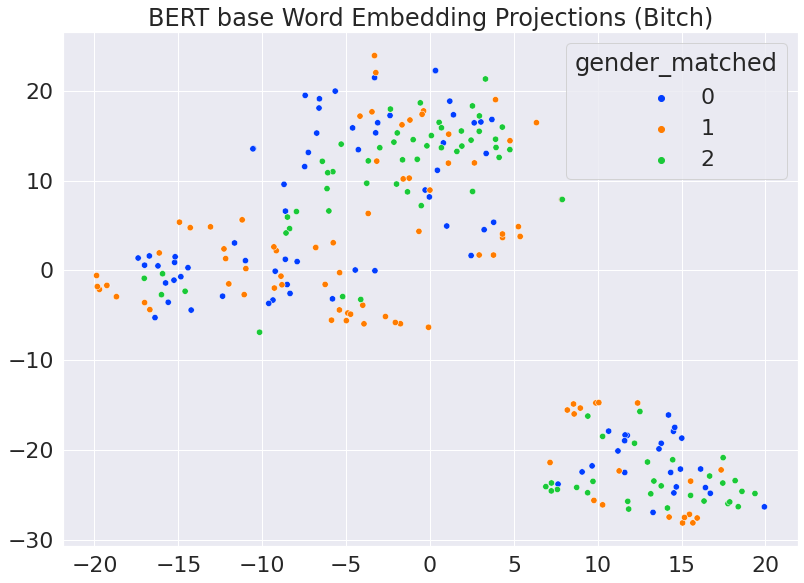

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1, hue = bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("BERT base Word Embedding Projections (Bitch)")
plt.savefig("plot/b_word.png")

##Wh word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
whore_df = pd.read_csv("whore_df.csv")

In [ ]:
whore_df.gender_matched.value_counts()

0    237
1     24
2      2
Name: gender_matched, dtype: int64

In [ ]:
whore_df = whore_df.reset_index(drop=True)

In [ ]:
whore_df

title        artist  \
0               Cemetry Gates - 2011 Remaster    The Smiths   
1                                     No More     Disturbed   
2                                     No More     Disturbed   
3                                     No More     Disturbed   
4                                     No More     Disturbed   
..                                        ...           ...   
258  There S Not A Problem My Squad Can T Fix  Busta Rhymes   
259                               Wife In Law  Busta Rhymes   
260                                 Violators  Busta Rhymes   
261                           Sin Of The City   Duran Duran   
262                           Hail Mary Remix       G Herbo   

                                                lyrics  year  popularity  \
0    A dreaded sunny day So I meet you at the cemet...  1986        52.0   
1    Once again we hear them calling for war It doe...  2018        57.0   
2    Once again we hear them calling for war It doe...  2018        57.0   
3    Once again we hear them calling for war It doe...  2018        57.0   
4    Once again we hear them calling for war It doe...  2018        57.0   
..                                                 ...   ...         ...   
258  C'mon yeah villain C'mon aight I got this side...  2006         NaN   
259  Yeah yeah yeah yeah Yeah yeah yeah yeah Yeah y...  2006         NaN   
260   Let's get it started get it started Let's kee...  2006         NaN   
261  Coat check girl up in Happyland Has a violent ...  1993         NaN   
262   Intro Huh Niggas already know what it is with...  2016         NaN   

       edm  latin    pop    r&b    rap   rock   Gender year_bin  artist_lower  \
0    False  False  False  False  False   True  Unknown    1980s    the smiths   
1    False  False  False  False  False   True  Unknown    2010s     disturbed   
2    False  False  False  False  False   True  Unknown    2010s     disturbed   
3    False  False  False  False  False   True  Unknown    2010s     disturbed   
4    False  False  False  False  False   True  Unknown    2010s     disturbed   
..     ...    ...    ...    ...    ...    ...      ...      ...           ...   
258  False  False  False  False   True  False  Unknown    2000s  busta rhymes   
259  False  False  False  False   True  False  Unknown    2000s  busta rhymes   
260  False  False  False  False   True  False  Unknown    2000s  busta rhymes   
261  False  False  False  False  False   True  Unknown    1990s   duran duran   
262  False  False  False  False  False  False  Unknown    2010s       g herbo   

     gender_matched                                          segmented  \
0                 0  was ripped Some dizzy whore, 1804 A dreaded su...   
1                 0  It's time to make them realize We will no long...   
2                 0  It's time to make them realize We will no long...   
3                 0  It's time to make them realize We will no long...   
4                 0  It's time to make them realize We will no long...   
..              ...                                                ...   
258               0  fly whores and tours Fillin my pipe with no me...   
259               0  my bitch for the triflin whore Type of bitch t...   
260               0                                    you see a whore   
261               0  The city has more a hundred thousand wars All ...   
262               0  Essex Iced out whores on my necklace War where...   

     song_index                                     tokenized_text  
0            47  ['[CLS]', 'was', 'ripped', 'some', 'dizzy', 'w...  
1           342  ['[CLS]', 'it', "'", 's', 'time', 'to', 'make'...  
2           342  ['[CLS]', 'it', "'", 's', 'time', 'to', 'make'...  
3           342  ['[CLS]', 'it', "'", 's', 'time', 'to', 'make'...  
4           342  ['[CLS]', 'it', "'", 's', 'time', 'to', 'make'...  
..          ...                                                ...  
258       35549  ['[CLS]'

In [ ]:
sents = whore_df.segmented.values.tolist()

In [ ]:
len(sents)

263

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, whore_lst, layers = [-2]) #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_wh = torch.stack(emb_lst).numpy()
embs_wh.shape

(225, 768)

In [ ]:
len(na_lst)

38

In [ ]:
embs_wh=embs_wh.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_wh)
reduced= pca.transform(embs_wh)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


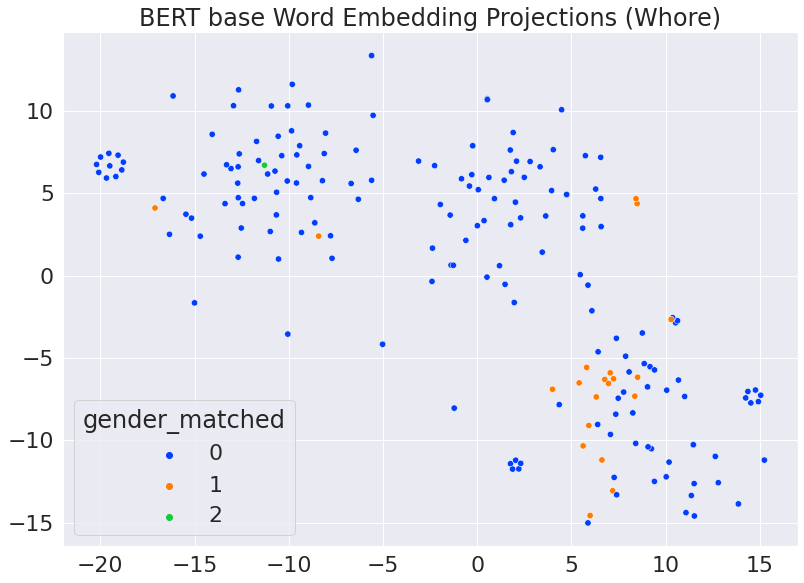

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = whore_df.loc[~whore_df.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("BERT base Word Embedding Projections (Whore)")
plt.savefig("plot/wh_word.png")

##F word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
fuck_df = pd.read_csv("fuck_df.csv")

In [ ]:
fuck_df.gender_matched.value_counts()

0    23061
1      874
2      193
Name: gender_matched, dtype: int64

In [ ]:
fuck_sample = fuck_df.groupby("gender_matched").sample(193, random_state=42).reset_index(drop=True)

In [ ]:
fuck_sample

title                     artist  \
0                          Lemme Freak                  Lil Dicky   
1                            Freestyle                        Dmx   
2        Instagram - Bassjackers Remix  Dimitri Vegas & Like Mike   
3                        Tiimmy Turner                  Desiigner   
4                              Burn Mf    Five Finger Death Punch   
..                                 ...                        ...   
574                        After Party               Adore Delano   
575  The Way (feat. Chance the Rapper)                    Kehlani   
576                            Echelon                 Angel Haze   
577  The Way (feat. Chance the Rapper)                    Kehlani   
578                        After Party               Adore Delano   

                                                lyrics  year  popularity  \
0    Drunk, faded Browned out, looking all shady Tw...  2015        63.0   
1    Uh uh uh Niggaz gettin trampled on what's all ...  2006         NaN   
2    NA Just bought a black Ferrari House in the hi...  2019        21.0   
3    Yeah, yeah, yeah, yeah Grrrrraaaah Yeah, yeah,...  2016        72.0   
4    My heart is frozen My soul's been broken The w...  2013         NaN   
..                                                 ...   ...         ...   
574  It's 2 AM your fingertips are running down my ...  2016         NaN   
575  You so damn important Everything you do shows ...  2015        66.0   
576  I'm in that new school G5 wagon Color Komodo d...  2013         NaN   
577  You so damn important Everything you do shows ...  2015        66.0   
578  It's 2 AM your fingertips are running down my ...  2016         NaN   

       edm  latin    pop    r&b    rap   rock   Gender year_bin  \
0    False  False  False  False   True  False  Unknown    2010s   
1    False  False  False  False   True  False  Unknown    2000s   
2     True  False  False  False  False  False  Unknown    2010s   
3    False  False  False  False   True  False  Unknown    2010s   
4    False  False  False  False  False  False  Unknown    2010s   
..     ...    ...    ...    ...    ...    ...      ...      ...   
574  False  False   True  False  False  False  Unknown    2010s   
575  False  False  False   True  False  False  Unknown    2010s   
576  False  False  False  False   True  False  Unknown    2010s   
577  False  False  False   True  False  False  Unknown    2010s   
578  False  False   True  False  False  False  Unknown    2010s   

                artist_lower  gender_matched  \
0                  lil dicky               0   
1                        dmx               0   
2    dimitri vegas like mike               0   
3                  desiigner               0   
4    five finger death punch               0   
..                       ...             ...   
574             adore delano               2   
575                  kehlani               2   
576               angel haze               2   
577                  kehlani               2   
578             adore delano               2   

                                             segmented  song_index  \
0    then I don't work with these people," she star...         235   
1         And then I snuff em out four to the mid fuck       16686   
2    I don't give a fuck about your Instagram Fly a...        1453   
3             , she fuckin' for BET Wildin' for wallet        2984   
4                                   mother fucker burn       27056   
..                                                 ...         ...   
574                           and I'll fuck who I want        9695   
575          when we fuck, RE/MAXIt get hot than a mug        5335   
576                                   I'm on that fuck        9967   
577  It's the way you love, the way you fuck, the w...        5335   
578  and I'll fuck who I want Fuck who I want fuck ...        9695   

                                        tokenized_text  
0    [[CLS]

In [ ]:
sents = fuck_sample.segmented.values.tolist()

In [ ]:
len(sents)

579

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, fuck_lst, layers = [-2]) #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

### Visualize Embeddings

In [ ]:
embs_f = torch.stack(emb_lst).numpy()
embs_f.shape

(549, 768)

In [ ]:
len(na_lst)

30

In [ ]:
embs_f=embs_f.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_f)
reduced= pca.transform(embs_f)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


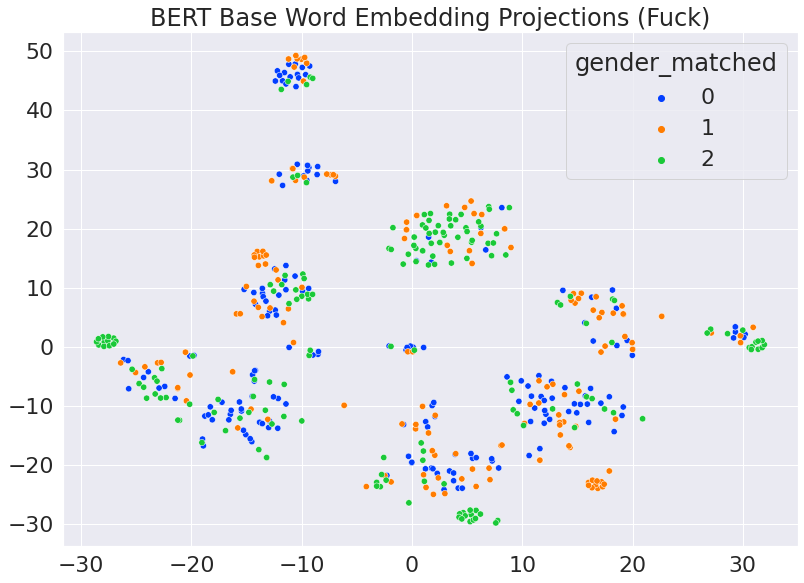

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = fuck_sample.loc[~fuck_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("BERT Base Word Embedding Projections (Fuck)")
plt.savefig("f_word.png")

##Sh word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
shit_df = pd.read_csv("shit_df.csv")

In [ ]:
shit_df.gender_matched.value_counts()

0    17576
1      816
2      111
Name: gender_matched, dtype: int64

In [ ]:
shit_sample = shit_df.groupby("gender_matched").sample(111, random_state=42).reset_index(drop=True)

In [ ]:
shit_sample

title        artist  \
0                                   Music       Fat Joe   
1      Things We Be Doin For Money Part 2  Busta Rhymes   
2    Pandemonium (feat. Wale & Rick Ross)     Meek Mill   
3                                    Isis  Joyner Lucas   
4                                  BURIED        27CLUB   
..                                    ...           ...   
328                         Drunk In Love    Angel Haze   
329                               Echelon    Angel Haze   
330                            Impossible    Angel Haze   
331                   Live It Up Practice    Angel Haze   
332                          Werkin Girls    Angel Haze   

                                                lyrics  year  popularity  \
0     Coca Krillz mania BX T S til I die muh'fucker...  2009         NaN   
1    Huh yeah fuck that Niggas is gon have to get i...  2008         NaN   
2    Three passports, three first class Tickets to ...  2011        32.0   
3    Attention Deficit Hyperactivity Disorder, or b...  2019        78.0   
4    Feeling like I'm buried alive Got me thinking ...  2019        46.0   
..                                                 ...   ...         ...   
328  I've been thinking I've been thinking Ya if I ...  2014         NaN   
329  I'm in that new school G5 wagon Color Komodo d...  2013         NaN   
330   There is no part of me left in my brain I am ...  2015         NaN   
331  Verse1 Heart Broken too often love wasted no p...  2012         NaN   
332  Okay I'm Rambo I ramshack I'm next to that che...  2012         NaN   

       edm  latin    pop    r&b   rap   rock   Gender year_bin  artist_lower  \
0    False  False  False  False  True  False  Unknown    2000s       fat joe   
1    False  False  False  False  True  False  Unknown    2000s  busta rhymes   
2    False  False  False  False  True  False  Unknown    2010s     meek mill   
3    False  False  False  False  True  False  Unknown    2010s  joyner lucas   
4    False  False  False  False  True  False  Unknown    2010s        27club   
..     ...    ...    ...    ...   ...    ...      ...      ...           ...   
328  False  False  False  False  True  False  Unknown    2010s    angel haze   
329  False  False  False  False  True  False  Unknown    2010s    angel haze   
330  False  False  False  False  True  False  Unknown    2010s    angel haze   
331  False  False  False  False  True  False  Unknown    2010s    angel haze   
332  False  False  False  False  True  False  Unknown    2010s    angel haze   

     gender_matched                                          segmented  \
0                 0                               I don't do shit Bein   
1                 0                                           bullshit   
2                 0  That's game bitch ain't shit, nudies and some ...   
3                 0                        I've come to body this shit   
4                 0  Hey You on some fake shit Never thought that y...   
..              ...                                                ...   
328               2                                       shit go down   
329               2  all the latest Killing these motherfuckers And...   
330               2  this shit's a problem man I just go through my...   
331               2  but im going cant feel shit thats boring thats...   
332               2  Hold up Money and more money is the only shit ...   

     song_index                                     tokenized_text  
0         13173  ['[CLS]', 'i', 'don', "'", 't', 'do', 'shit', ...  
1         35618                     ['[CLS]', 'bullshit', '[SEP]']  
2          3064  ['[CLS]', 'that', "'", 's', 'game', 'bitch', '...  
3          2592  ['[CLS]', 'i', "'", 've', 'come', 'to', 'body'...  
4          1363  ['[CLS]', 'hey', 'you', 'on', 'some', 'fake', ...  
..          ...                                                ...  
328        9994           ['[CLS]', 'shit', 'go', 'down', '[SEP]']  
329        9

In [ ]:
sents = shit_sample.segmented.values.tolist()

In [ ]:
len(sents)

333

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, shit_lst, layers = [-2]) #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_sh = torch.stack(emb_lst).numpy()
embs_sh.shape

(307, 768)

In [ ]:
len(na_lst)

26

In [ ]:
embs_sh=embs_sh.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_sh)
reduced= pca.transform(embs_sh)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


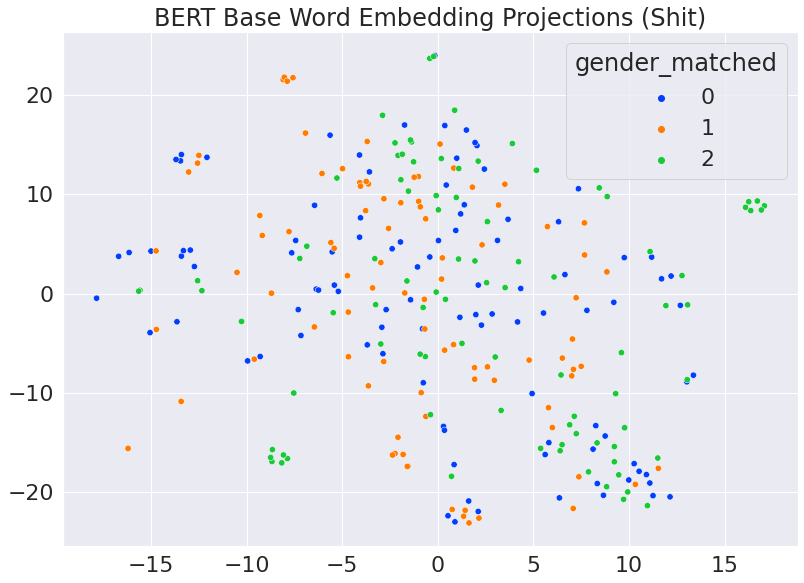

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = shit_sample.loc[~shit_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("BERT Base Word Embedding Projections (Shit)")
plt.savefig("sh_word.png")

# Extract Embeddings

In [ ]:
from sklearn import *
import seaborn as sns

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [ ]:
!unzip /content/lyrics-bert.zip -d lyrics-bert 

Archive:  /content/lyrics-bert.zip
   creating: lyrics-bert/lyrics-bert/
  inflating: lyrics-bert/__MACOSX/._lyrics-bert  
  inflating: lyrics-bert/lyrics-bert/config.json  
  inflating: lyrics-bert/lyrics-bert/pytorch_model.bin  


In [ ]:
!unzip /content/lyrics-bert2.zip -d lyrics-bert2 

Archive:  /content/lyrics-bert2.zip
   creating: lyrics-bert2/lyric-bert2/
  inflating: lyrics-bert2/lyric-bert2/.DS_Store  
  inflating: lyrics-bert2/__MACOSX/lyric-bert2/._.DS_Store  
  inflating: lyrics-bert2/lyric-bert2/config.json  
  inflating: lyrics-bert2/lyric-bert2/pytorch_model.bin  


## All Slurs

In [ ]:
whore_lst = [w for w in bad_wrds if "whore" in w]
fuck_lst = [w for w in bad_wrds if "fuck" in w]
shit_lst = [w for w in bad_wrds if "shit" in w]
sissy_lst = [w for w in bad_wrds if "sissy" in w]
slut_lst = [w for w in bad_wrds if "slut" in w]
hoe_lst = [w for w in bad_wrds if "hoe" in w]
hoe_lst.append("hoe")
bitch_lst = [w for w in bad_wrds if "bitch" in w]
shorty_lst = [w for w in bad_wrds if "shorty" in w or "shawty" in w]
shorty_lst.append("shorty")
shorty_lst.append("shawty")
#skeezer_lst = ["skeezer"]

In [ ]:
lsts = [bitch_lst, whore_lst, hoe_lst, fuck_lst, shit_lst, sissy_lst, slut_lst, shorty_lst]

In [ ]:
slurs_df = df.tokenized_text.apply(lambda x: bert_utils.find_words(x, lsts))

In [ ]:
bitch_df = df[slurs_df.apply(lambda x: x[0])]
whore_df = df[slurs_df.apply(lambda x: x[1])]
hoe_df = df[slurs_df.apply(lambda x: x[2])]
fuck_df = df[slurs_df.apply(lambda x: x[3])]
shit_df = df[slurs_df.apply(lambda x: x[4])]
sissy_df = df[slurs_df.apply(lambda x: x[5])]
slut_df = df[slurs_df.apply(lambda x: x[6])]
shorty_df = df[slurs_df.apply(lambda x: x[7])]

In [ ]:
print(f"{len(bitch_df)} sentences contain word related to bitch")
print(f"{len(whore_df)} sentences contain word related to whore")
print(f"{len(hoe_df)} sentences contain word related to hoe")
print(f"{len(sissy_df)} sentences contain word related to sissy")
print(f"{len(slut_df)} sentences contain word related to slut")
print(f"{len(shorty_df)} sentences contain word related to shorty")
print(f"{len()} sentences contain word related to fuck")
print(f"{len(shit_df)} sentences contain word related to shit")

17329 sentences contain word related to bitch
263 sentences contain word related to whore
0 sentences contain word related to hoe
0 sentences contain word related to sissy
0 sentences contain word related to slut
0 sentences contain word related to shorty
24128 sentences contain word related to fuck
18503 sentences contain word related to shit


In [ ]:
bitch_df.to_csv("bitch.csv", index = False)
whore_df.to_csv("whore_df.csv", index = False)
fuck_df.to_csv("fuck_df.csv", index = False)
shit_df.to_csv("shit_df.csv", index = False)

##B word

In [ ]:
bitch_df = pd.read_csv("bitch.csv")
bitch_df = bitch_df.reset_index(drop = True)

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
bitch_df.gender_matched.value_counts()

0    16199
1      917
2      213
Name: gender_matched, dtype: int64

In [ ]:
bitch_sample = bitch_df.groupby("gender_matched").sample(100, random_state=7).reset_index(drop=True)

In [ ]:
bitch_sample.head()

title          artist  \
0                             Bang Bang       YNW Melly   
1                            Dance Move  French Montana   
2                                  KIKA         6ix9ine   
3                   The Real Slim Shady          Eminem   
4  Pandemonium (feat. Wale & Rick Ross)       Meek Mill   

                                              lyrics  year  popularity    edm  \
0  Ayy, look Know what I'm sayin', I'm straight o...  2019        78.0  False   
1  Bust a dance move Pop a bottle pop a tag and b...  2012         NaN  False   
2  Bitch, we in the city on that hot shit Lookin'...  2018        18.0  False   
3  May I have your attention, please? May I have ...  2005        10.0  False   
4  Three passports, three first class Tickets to ...  2011        32.0  False   

   latin    pop    r&b   rap   rock   Gender year_bin    artist_lower  \
0  False  False  False  True  False  Unknown    2010s       ynw melly   
1  False  False  False  True  False  Unknown    2010s  french montana   
2  False  False  False  True  False  Unknown    2010s         6ix9ine   
3  False  False  False  True  False  Unknown    2000s          eminem   
4  False  False  False  True  False  Unknown    2010s       meek mill   

   gender_matched                                          segmented  \
0               0  , uh I'm tryna get it in, these bitches snorti...   
1               0  Shorty want this money tell that bitch to bust...   
2               0  John Cena shit, I can't see the bitch In the D...   
3               0  So I can sit next to Carson Daly and Fred Durs...   
4               0  Three's for the bitches that be fucking for th...   

   song_index                                     tokenized_text  
0        4953  [[CLS], ,, uh, i, ', m, try, ##na, get, it, in...  
1       14390  [[CLS], short, ##y, want, this, money, tell, t...  
2        5171  [[CLS], john, ce, ##na, shit, ,, i, can, ', t,...  
3        1344  [[CLS], so, i, can, sit, next, to, carson, dal...  
4        3064  [[CLS], three, ', s, for, the, bitch, ##es, th...

In [ ]:
sents = bitch_sample.segmented.values.tolist()

In [ ]:
len(sents)

300

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, bitch_lst, layers = [-2], model = "/content/lyrics-bert") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

### Visualize Embeddings

In [ ]:
len(emb_lst_b)

266

In [ ]:
len(na_lst)

34

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(266, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 44).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched

0      0
1      0
2      0
3      0
4      0
      ..
292    2
293    2
295    2
296    2
299    2
Name: gender_matched, Length: 266, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


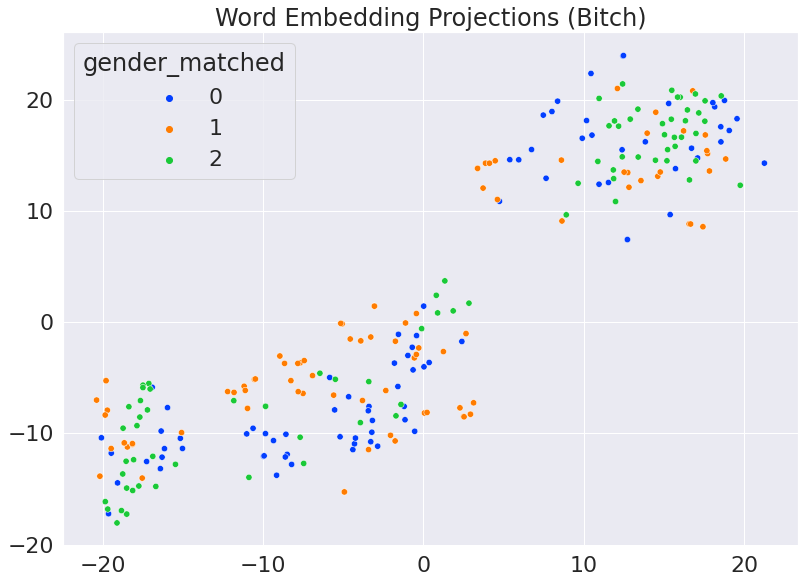

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1, hue = bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("Word Embedding Projections (Bitch)")
plt.savefig("plot/b_word.png")

##Wh word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
whore_df = pd.read_csv("whore_df.csv")

In [ ]:
whore_df.gender_matched.value_counts()

0    237
1     24
2      2
Name: gender_matched, dtype: int64

In [ ]:
whore_df = whore_df.reset_index(drop=True)

In [ ]:
whore_df

title        artist  \
0               Cemetry Gates - 2011 Remaster    The Smiths   
1                                     No More     Disturbed   
2                                     No More     Disturbed   
3                                     No More     Disturbed   
4                                     No More     Disturbed   
..                                        ...           ...   
258  There S Not A Problem My Squad Can T Fix  Busta Rhymes   
259                               Wife In Law  Busta Rhymes   
260                                 Violators  Busta Rhymes   
261                           Sin Of The City   Duran Duran   
262                           Hail Mary Remix       G Herbo   

                                                lyrics  year  popularity  \
0    A dreaded sunny day So I meet you at the cemet...  1986        52.0   
1    Once again we hear them calling for war It doe...  2018        57.0   
2    Once again we hear them calling for war It doe...  2018        57.0   
3    Once again we hear them calling for war It doe...  2018        57.0   
4    Once again we hear them calling for war It doe...  2018        57.0   
..                                                 ...   ...         ...   
258  C'mon yeah villain C'mon aight I got this side...  2006         NaN   
259  Yeah yeah yeah yeah Yeah yeah yeah yeah Yeah y...  2006         NaN   
260   Let's get it started get it started Let's kee...  2006         NaN   
261  Coat check girl up in Happyland Has a violent ...  1993         NaN   
262   Intro Huh Niggas already know what it is with...  2016         NaN   

       edm  latin    pop    r&b    rap   rock   Gender year_bin  artist_lower  \
0    False  False  False  False  False   True  Unknown    1980s    the smiths   
1    False  False  False  False  False   True  Unknown    2010s     disturbed   
2    False  False  False  False  False   True  Unknown    2010s     disturbed   
3    False  False  False  False  False   True  Unknown    2010s     disturbed   
4    False  False  False  False  False   True  Unknown    2010s     disturbed   
..     ...    ...    ...    ...    ...    ...      ...      ...           ...   
258  False  False  False  False   True  False  Unknown    2000s  busta rhymes   
259  False  False  False  False   True  False  Unknown    2000s  busta rhymes   
260  False  False  False  False   True  False  Unknown    2000s  busta rhymes   
261  False  False  False  False  False   True  Unknown    1990s   duran duran   
262  False  False  False  False  False  False  Unknown    2010s       g herbo   

     gender_matched                                          segmented  \
0                 0  was ripped Some dizzy whore, 1804 A dreaded su...   
1                 0  It's time to make them realize We will no long...   
2                 0  It's time to make them realize We will no long...   
3                 0  It's time to make them realize We will no long...   
4                 0  It's time to make them realize We will no long...   
..              ...                                                ...   
258               0  fly whores and tours Fillin my pipe with no me...   
259               0  my bitch for the triflin whore Type of bitch t...   
260               0                                    you see a whore   
261               0  The city has more a hundred thousand wars All ...   
262               0  Essex Iced out whores on my necklace War where...   

     song_index                                     tokenized_text  
0            47  [[CLS], was, ripped, some, dizzy, whore, ,, 18...  
1           342  [[CLS], it, ', s, time, to, make, them, realiz...  
2           342  [[CLS], it, ', s, time, to, make, them, realiz...  
3           342  [[CLS], it, ', s, time, to, make, them, realiz...  
4           342  [[CLS], it, ', s, time, to, make, them, realiz...  
..          ...                                                ...  
258       35549  [[CLS], 

In [ ]:
sents = whore_df.segmented.values.tolist()

In [ ]:
len(sents)

263

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, whore_lst, layers = [-2], model = "/content/lyrics-bert") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_wh = torch.stack(emb_lst).numpy()
embs_wh.shape

(225, 768)

In [ ]:
len(na_lst)

38

In [ ]:
embs_wh=embs_wh.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_wh)
reduced= pca.transform(embs_wh)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


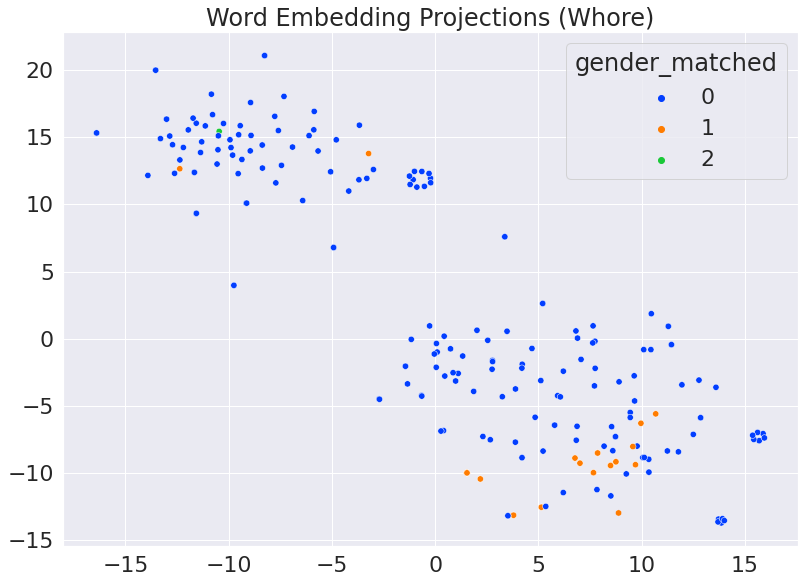

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = whore_df.loc[~whore_df.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("Word Embedding Projections (Whore)")
plt.savefig("plot/wh_word.png")

##F word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
fuck_df = pd.read_csv("fuck_df.csv")

In [ ]:
fuck_df.gender_matched.value_counts()

0    23061
1      874
2      193
Name: gender_matched, dtype: int64

In [ ]:
fuck_sample = fuck_df.groupby("gender_matched").sample(193, random_state=42).reset_index(drop=True)

In [ ]:
fuck_sample

title                     artist  \
0                          Lemme Freak                  Lil Dicky   
1                            Freestyle                        Dmx   
2        Instagram - Bassjackers Remix  Dimitri Vegas & Like Mike   
3                        Tiimmy Turner                  Desiigner   
4                              Burn Mf    Five Finger Death Punch   
..                                 ...                        ...   
574                        After Party               Adore Delano   
575  The Way (feat. Chance the Rapper)                    Kehlani   
576                            Echelon                 Angel Haze   
577  The Way (feat. Chance the Rapper)                    Kehlani   
578                        After Party               Adore Delano   

                                                lyrics  year  popularity  \
0    Drunk, faded Browned out, looking all shady Tw...  2015        63.0   
1    Uh uh uh Niggaz gettin trampled on what's all ...  2006         NaN   
2    NA Just bought a black Ferrari House in the hi...  2019        21.0   
3    Yeah, yeah, yeah, yeah Grrrrraaaah Yeah, yeah,...  2016        72.0   
4    My heart is frozen My soul's been broken The w...  2013         NaN   
..                                                 ...   ...         ...   
574  It's 2 AM your fingertips are running down my ...  2016         NaN   
575  You so damn important Everything you do shows ...  2015        66.0   
576  I'm in that new school G5 wagon Color Komodo d...  2013         NaN   
577  You so damn important Everything you do shows ...  2015        66.0   
578  It's 2 AM your fingertips are running down my ...  2016         NaN   

       edm  latin    pop    r&b    rap   rock   Gender year_bin  \
0    False  False  False  False   True  False  Unknown    2010s   
1    False  False  False  False   True  False  Unknown    2000s   
2     True  False  False  False  False  False  Unknown    2010s   
3    False  False  False  False   True  False  Unknown    2010s   
4    False  False  False  False  False  False  Unknown    2010s   
..     ...    ...    ...    ...    ...    ...      ...      ...   
574  False  False   True  False  False  False  Unknown    2010s   
575  False  False  False   True  False  False  Unknown    2010s   
576  False  False  False  False   True  False  Unknown    2010s   
577  False  False  False   True  False  False  Unknown    2010s   
578  False  False   True  False  False  False  Unknown    2010s   

                artist_lower  gender_matched  \
0                  lil dicky               0   
1                        dmx               0   
2    dimitri vegas like mike               0   
3                  desiigner               0   
4    five finger death punch               0   
..                       ...             ...   
574             adore delano               2   
575                  kehlani               2   
576               angel haze               2   
577                  kehlani               2   
578             adore delano               2   

                                             segmented  song_index  \
0    then I don't work with these people," she star...         235   
1         And then I snuff em out four to the mid fuck       16686   
2    I don't give a fuck about your Instagram Fly a...        1453   
3             , she fuckin' for BET Wildin' for wallet        2984   
4                                   mother fucker burn       27056   
..                                                 ...         ...   
574                           and I'll fuck who I want        9695   
575          when we fuck, RE/MAXIt get hot than a mug        5335   
576                                   I'm on that fuck        9967   
577  It's the way you love, the way you fuck, the w...        5335   
578  and I'll fuck who I want Fuck who I want fuck ...        9695   

                                        tokenized_text  
0    [[CLS]

In [ ]:
sents = fuck_sample.segmented.values.tolist()

In [ ]:
len(sents)

579

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, fuck_lst, layers = [-2], model = "/content/lyrics-bert") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_f = torch.stack(emb_lst).numpy()
embs_f.shape

(549, 768)

In [ ]:
len(na_lst)

30

In [ ]:
embs_f=embs_f.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_f)
reduced= pca.transform(embs_f)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


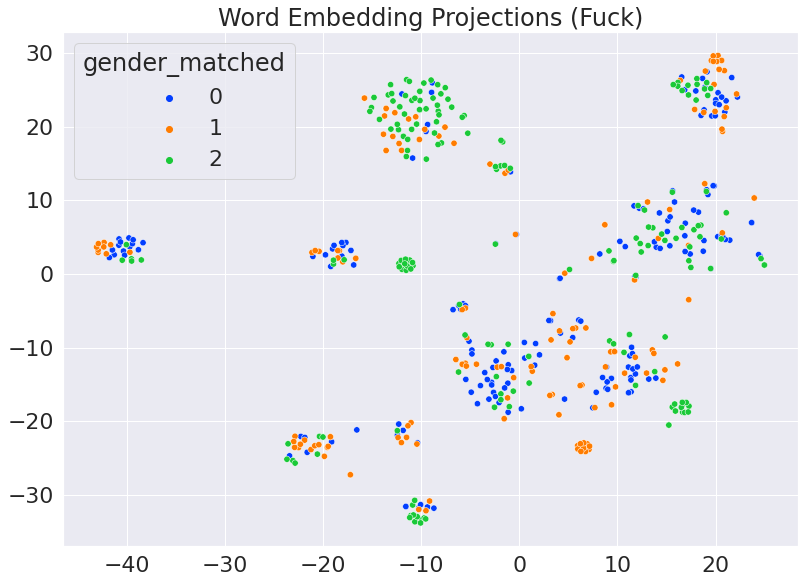

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = fuck_sample.loc[~fuck_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("Word Embedding Projections (Fuck)")
plt.savefig("plot/f_word.png")

##Sh word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
shit_df = pd.read_csv("shit_df.csv")

In [ ]:
shit_df.gender_matched.value_counts()

0    17576
1      816
2      111
Name: gender_matched, dtype: int64

In [ ]:
shit_sample = shit_df.groupby("gender_matched").sample(111, random_state=42).reset_index(drop=True)

In [ ]:
shit_sample

title        artist  \
0                                   Music       Fat Joe   
1      Things We Be Doin For Money Part 2  Busta Rhymes   
2    Pandemonium (feat. Wale & Rick Ross)     Meek Mill   
3                                    Isis  Joyner Lucas   
4                                  BURIED        27CLUB   
..                                    ...           ...   
328                         Drunk In Love    Angel Haze   
329                               Echelon    Angel Haze   
330                            Impossible    Angel Haze   
331                   Live It Up Practice    Angel Haze   
332                          Werkin Girls    Angel Haze   

                                                lyrics  year  popularity  \
0     Coca Krillz mania BX T S til I die muh'fucker...  2009         NaN   
1    Huh yeah fuck that Niggas is gon have to get i...  2008         NaN   
2    Three passports, three first class Tickets to ...  2011        32.0   
3    Attention Deficit Hyperactivity Disorder, or b...  2019        78.0   
4    Feeling like I'm buried alive Got me thinking ...  2019        46.0   
..                                                 ...   ...         ...   
328  I've been thinking I've been thinking Ya if I ...  2014         NaN   
329  I'm in that new school G5 wagon Color Komodo d...  2013         NaN   
330   There is no part of me left in my brain I am ...  2015         NaN   
331  Verse1 Heart Broken too often love wasted no p...  2012         NaN   
332  Okay I'm Rambo I ramshack I'm next to that che...  2012         NaN   

       edm  latin    pop    r&b   rap   rock   Gender year_bin  artist_lower  \
0    False  False  False  False  True  False  Unknown    2000s       fat joe   
1    False  False  False  False  True  False  Unknown    2000s  busta rhymes   
2    False  False  False  False  True  False  Unknown    2010s     meek mill   
3    False  False  False  False  True  False  Unknown    2010s  joyner lucas   
4    False  False  False  False  True  False  Unknown    2010s        27club   
..     ...    ...    ...    ...   ...    ...      ...      ...           ...   
328  False  False  False  False  True  False  Unknown    2010s    angel haze   
329  False  False  False  False  True  False  Unknown    2010s    angel haze   
330  False  False  False  False  True  False  Unknown    2010s    angel haze   
331  False  False  False  False  True  False  Unknown    2010s    angel haze   
332  False  False  False  False  True  False  Unknown    2010s    angel haze   

     gender_matched                                          segmented  \
0                 0                               I don't do shit Bein   
1                 0                                           bullshit   
2                 0  That's game bitch ain't shit, nudies and some ...   
3                 0                        I've come to body this shit   
4                 0  Hey You on some fake shit Never thought that y...   
..              ...                                                ...   
328               2                                       shit go down   
329               2  all the latest Killing these motherfuckers And...   
330               2  this shit's a problem man I just go through my...   
331               2  but im going cant feel shit thats boring thats...   
332               2  Hold up Money and more money is the only shit ...   

     song_index                                     tokenized_text  
0         13173  ['[CLS]', 'i', 'don', "'", 't', 'do', 'shit', ...  
1         35618                     ['[CLS]', 'bullshit', '[SEP]']  
2          3064  ['[CLS]', 'that', "'", 's', 'game', 'bitch', '...  
3          2592  ['[CLS]', 'i', "'", 've', 'come', 'to', 'body'...  
4          1363  ['[CLS]', 'hey', 'you', 'on', 'some', 'fake', ...  
..          ...                                                ...  
328        9994           ['[CLS]', 'shit', 'go', 'down', '[SEP]']  
329        9

In [ ]:
sents = shit_sample.segmented.values.tolist()

In [ ]:
len(sents)

333

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, shit_lst, layers = [-2], model = "/content/lyrics-bert") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_sh = torch.stack(emb_lst).numpy()
embs_sh.shape

(307, 768)

In [ ]:
len(na_lst)

26

In [ ]:
embs_sh=embs_sh.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_sh)
reduced= pca.transform(embs_sh)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


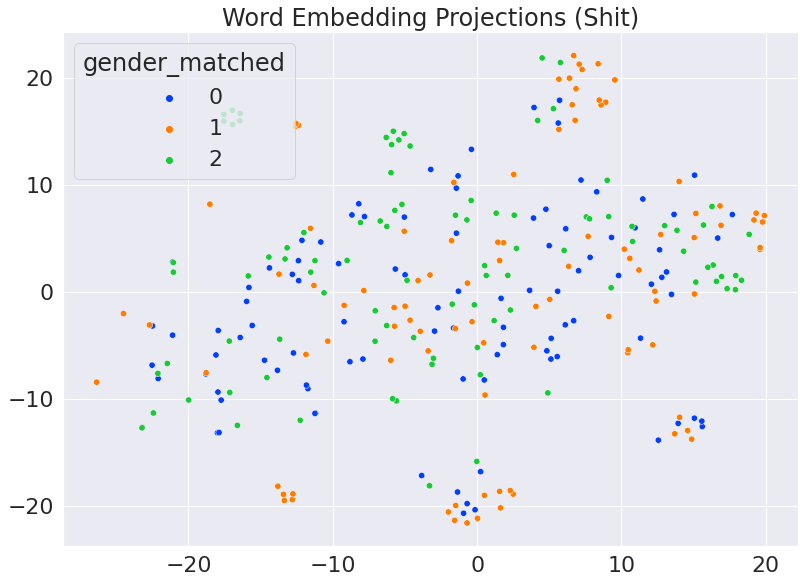

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = shit_sample.loc[~shit_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("Word Embedding Projections (Shit)")
plt.savefig("plot/sh_word.png")

# Viz with lyrics-bert2

In [ ]:
from sklearn import *
import seaborn as sns

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

In [ ]:
!unzip /content/lyrics-bert.zip -d lyrics-bert 

Archive:  /content/lyrics-bert.zip
   creating: lyrics-bert/lyrics-bert/
  inflating: lyrics-bert/__MACOSX/._lyrics-bert  
  inflating: lyrics-bert/lyrics-bert/config.json  
  inflating: lyrics-bert/lyrics-bert/pytorch_model.bin  


In [ ]:
!unzip /content/lyrics-bert2.zip -d /content/lyrics-bert2

Archive:  /content/lyrics-bert2.zip
warning [/content/lyrics-bert2.zip]:  100561043 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  100561043
  (attempting to re-compensate)
error: invalid zip file with overlapped components (possible zip bomb)


## All Slurs

In [ ]:
#whore_lst = [w for w in bad_wrds if "whore" in w]
fuck_lst = [w for w in bad_wrds if "fuck" in w]
shit_lst = [w for w in bad_wrds if "shit" in w]
#sissy_lst = [w for w in bad_wrds if "sissy" in w]
#slut_lst = [w for w in bad_wrds if "slut" in w]
#hoe_lst = [w for w in bad_wrds if "hoe" in w]
#hoe_lst.append("hoe")
bitch_lst = [w for w in bad_wrds if "bitch" in w]
#shorty_lst = [w for w in bad_wrds if "shorty" in w or "shawty" in w]
#shorty_lst.append("shorty")
#shorty_lst.append("shawty")
#skeezer_lst = ["skeezer"]

In [ ]:
lsts = [bitch_lst, fuck_lst, shit_lst]

In [ ]:
slurs_df = df.tokenized_text.apply(lambda x: bert_utils.find_words(x, lsts))

In [ ]:
slurs_df

0          [False, False, False]
1          [False, False, False]
2          [False, False, False]
3          [False, False, False]
4          [False, False, False]
                   ...          
1647690    [False, False, False]
1647691    [False, False, False]
1647692    [False, False, False]
1647693    [False, False, False]
1647694    [False, False, False]
Name: tokenized_text, Length: 1647695, dtype: object

In [ ]:
bitch_df = df[slurs_df.apply(lambda x: x[0])]
#whore_df = df[slurs_df.apply(lambda x: x[1])]
#hoe_df = df[slurs_df.apply(lambda x: x[2])]
fuck_df = df[slurs_df.apply(lambda x: x[1])]
shit_df = df[slurs_df.apply(lambda x: x[2])]
#sissy_df = df[slurs_df.apply(lambda x: x[5])]
#slut_df = df[slurs_df.apply(lambda x: x[6])]
#shorty_df = df[slurs_df.apply(lambda x: x[7])]

In [ ]:
print(f"{len(bitch_df)} sentences contain word related to bitch")
#print(f"{len(whore_df)} sentences contain word related to whore")
#print(f"{len(hoe_df)} sentences contain word related to hoe")
#print(f"{len(sissy_df)} sentences contain word related to sissy")
#print(f"{len(slut_df)} sentences contain word related to slut")
#print(f"{len(shorty_df)} sentences contain word related to shorty")
print(f"{len(fuck_df)} sentences contain word related to fuck")
print(f"{len(shit_df)} sentences contain word related to shit")

17329 sentences contain word related to bitch
24128 sentences contain word related to fuck
18503 sentences contain word related to shit


In [ ]:
bitch_df.to_csv("bitch.csv", index = False)
whore_df.to_csv("whore_df.csv", index = False)
fuck_df.to_csv("fuck_df.csv", index = False)
shit_df.to_csv("shit_df.csv", index = False)

##B word

In [ ]:
bitch_df = pd.read_csv("bitch_df.csv")
bitch_df = bitch_df.reset_index(drop = True)

In [ ]:
bitch_df.gender_matched.value_counts()

male          16199
female          917
non-binary      213
Name: gender_matched, dtype: int64

In [ ]:
bitch_df.year_bin.value_counts()

2010s    11867
2000s     4971
1990s      438
1970s       40
1980s       13
Name: year_bin, dtype: int64

In [ ]:
bitch_df = pd.read_csv("bitch_df.csv")
bitch_df

In [ ]:
'''
def recode_gender(x):
    if x == 0:
        return "male"
    elif x == 1:
        return "female"
    else:
        return "non-binary"
bitch_df['gender_matched'] = bitch_df.gender_matched.apply(lambda x: recode_gender(x))
'''

'\ndef recode_gender(x):\n    if x == 0:\n        return "male"\n    elif x == 1:\n        return "female"\n    else:\n        return "non-binary"\nbitch_df[\'gender_matched\'] = bitch_df.gender_matched.apply(lambda x: recode_gender(x))\n'

In [ ]:
! python viz.py bad-words.txt "bitch" /content/bitch_df.csv /content/lyrics-bert2

Working on year 1970s...
Found 40 sentences containing the insult...
Fetching embeddings from /content/lyrics-bert2 model
Some weights of the model checkpoint at /content/lyrics-bert2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the m

In [ ]:
bitch_df.to_csv("bitch_df.csv", index = None)

In [ ]:
bitch_df = pd.read_csv("bitch_df.csv")
bitch_df

title      artist  \
0      Let Me Entertain You - Remastered 2011       Queen   
1                                   Love Sosa  Chief Keef   
2                                   Love Sosa  Chief Keef   
3                                   Love Sosa  Chief Keef   
4                                   Love Sosa  Chief Keef   
...                                       ...         ...   
17324                              Lord Knows     G Herbo   
17325                       Waitin For Nothin     G Herbo   
17326                       Waitin For Nothin     G Herbo   
17327                       Waitin For Nothin     G Herbo   
17328              Good Times Jamie Xx Rework    Dua Lipa   

                                                  lyrics  year  popularity  \
0      Hey, it's a sellout! Hey! Let me welcome you, ...  1978        41.0   
1      Fuckers in school telling me, always in the ba...  2012        64.0   
2      Fuckers in school telling me, always in the ba...  2012        64.0   
3      Fuckers in school telling me, always in the ba...  2012        64.0   
4      Fuckers in school telling me, always in the ba...  2012        64.0   
...                                                  ...   ...         ...   
17324  Yo Metro don't trust you I'm gon shoot you Met...  2015         NaN   
17325   I'm just livin man Just trying to get to the ...  2015         NaN   
17326   I'm just livin man Just trying to get to the ...  2015         NaN   
17327   I'm just livin man Just trying to get to the ...  2015         NaN   
17328  All I need is a little bit of honey oh yes we ...  2015         NaN   

         edm  latin    pop    r&b    rap   rock   Gender year_bin  \
0      False  False  False  False  False   True  Unknown    1970s   
1      False  False  False  False   True  False  Unknown    2010s   
2      False  False  False  False   True  False  Unknown    2010s   
3      False  False  False  False   True  False  Unknown    2010s   
4      False  False  False  False   True  False  Unknown    2010s   
...      ...    ...    ...    ...    ...    ...      ...      ...   
17324  False  False  False  False  False  False  Unknown    2010s   
17325  False  False  False  False  False  False  Unknown    2010s   
17326  False  False  False  False  False  False  Unknown    2010s   
17327  False  False  False  False  False  False  Unknown    2010s   
17328  False  False   True  False  False  False  Unknown    2010s   

      artist_lower gender_matched  \
0            queen           male   
1       chief keef           male   
2       chief keef           male   
3       chief keef           male   
4       chief keef           male   
...            ...            ...   
17324      g herbo           male   
17325      g herbo           male   
17326      g herbo           male   
17327      g herbo           male   
17328     dua lipa         female   

                                               segmented  song_index  \
0      a son-of-a-bitch-of-a-time Come on, let me ent...           4   
1                     Love sosa, bitches love sosa, huh?          17   
2                These bitches love Sosa O End or no end          17   
3                                These bitches love Sosa          17   
4      These bitches see Chief Sosa, I swear to God, ...          17   
...                                                  ...         ...   
17324      And these Balmain jeans makin me bougie Bitch       36907   
17325  when was nothing Have the nerve to ask me why ...       36908   
17326  niggas only worried bout makin names Chasing a...       36908   
17327                                     but that bitch       36908   
17328                         I know that bitch tripping       36928   

                                          tokenized_text  
0      ['[CLS]', 'a', 'son', '-', 'of', '-', 'a', '-'...  
1      ['[CLS]', 'love', 'so', '##sa', ',', 'bitch', ...  
2      ['[CLS]', 'these', 'bitch', '##es', 'love', 's.

In [ ]:
for i, y_b in enumerate(['1970s', '1980s', '1990s', '2000s', '2010s']):
    print(i)
    print(y_b)

0
1970s
1
1980s
2
1990s
3
2000s
4
2010s


Year 1970s has too many sentences, will truncate/randomly sample a subset
Working on year 1970s...
Found 3 sentences containing the insult...
Fetching embeddings from /content/lyrics-bert2 model
Successfully retrieved 3 embeddings...
Year 1980s has too many sentences, will truncate/randomly sample a subset
Working on year 1980s...
Found 3 sentences containing the insult...
Fetching embeddings from /content/lyrics-bert2 model


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Successfully retrieved 3 embeddings...
Year 1990s has too many sentences, will truncate/randomly sample a subset
Working on year 1990s...
Found 6 sentences containing the insult...
Fetching embeddings from /content/lyrics-bert2 model


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Successfully retrieved 6 embeddings...
Year 2000s has too many sentences, will truncate/randomly sample a subset
Working on year 2000s...
Found 6 sentences containing the insult...
Fetching embeddings from /content/lyrics-bert2 model


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Successfully retrieved 6 embeddings...
Year 2010s has too many sentences, will truncate/randomly sample a subset
Working on year 2010s...
Found 9 sentences containing the insult...
Fetching embeddings from /content/lyrics-bert2 model


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Successfully retrieved 9 embeddings...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


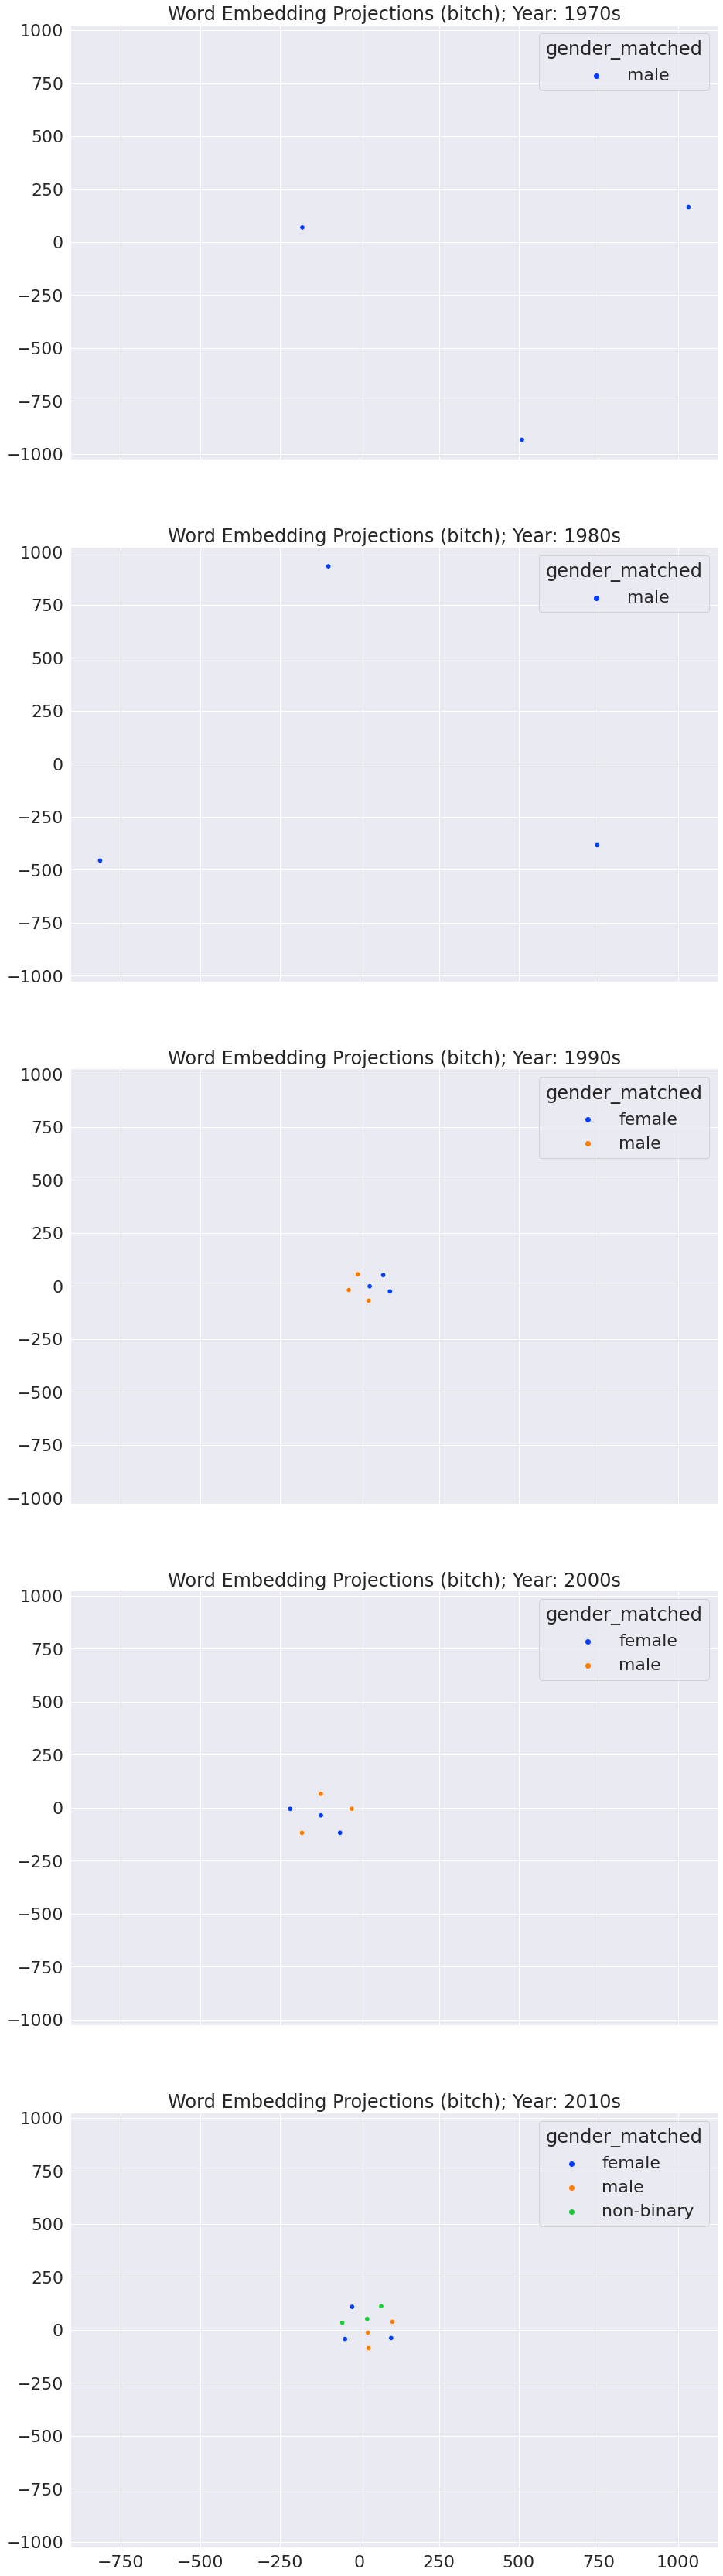

In [ ]:
model = "/content/lyrics-bert2"
slur = bitch_df
word = "bitch"
slur_lst = bitch_lst
#fig.suptitle('Sharing both axes')
fig, axs = plt.subplots(5, 1, figsize=(15, 60),sharex=True, sharey=True)

for idx, y_b in enumerate(['1970s', '1980s', '1990s', '2000s', '2010s']):
    y_df = slur[slur.year_bin == y_b].reset_index(drop = True)
    #alpha_ = 1
    if len(y_df) > 9:
        print(f"Year {y_b} has too many sentences, will truncate/randomly sample a subset")
        min_num = min(y_df.gender_matched.value_counts().reset_index().gender_matched)
        y_df = y_df.groupby("gender_matched").sample(min(min_num, 3), random_state=7).reset_index(drop=True)
        #alpha_ = 0.3
    print(f"Working on year {y_b}...")
    sents = y_df.segmented.values.tolist()
    print(f"Found {len(sents)} sentences containing the insult...")
    print(f"Fetching embeddings from {model} model")
    emb_lst = []
    na_lst = []
    for i, sent in enumerate(sents):
        emb = bert_utils.main(sent, slur_lst, layers = [-2], model = model) #use the second to last layer as word embedding
        if torch.isnan(emb).any().numpy():
            na_lst.append(i)
        else:
            emb_lst.append(emb)
    print(f"Successfully retrieved {len(emb_lst)} embeddings...")
    embs = torch.stack(emb_lst).numpy()
    embs = embs.astype(np.float64)

    pca= decomposition.PCA(n_components = min(embs.shape[0],44)).fit(embs)
    reduced = pca.transform(embs)
    tsne = manifold.TSNE(n_components = 2).fit_transform(reduced)
    gender = y_df.loc[~y_df.index.isin(na_lst)].gender_matched

    sns.set(font_scale=2)
    sns.scatterplot(tsne[:, 0], tsne[:, 1], hue = gender,\
                            palette="bright", s=40, ax = axs[idx]).set(title=f"Word Embedding Projections ({word}); Year: {y_b}")

plt.savefig("output/clusterEvolution.png")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


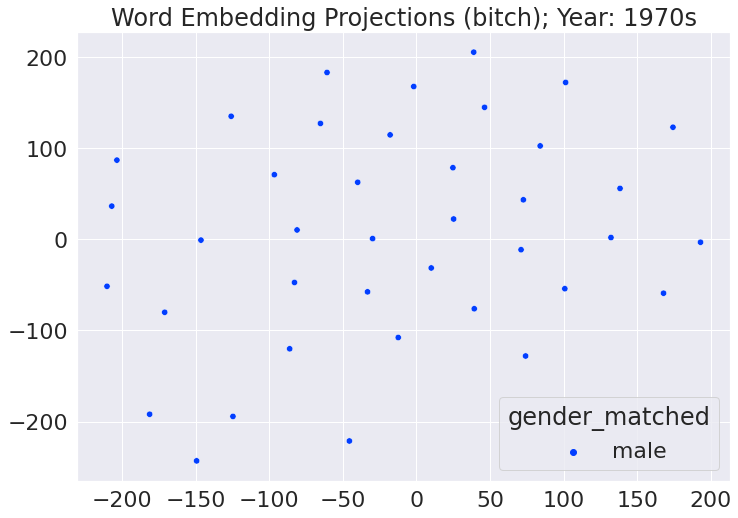

In [ ]:
    sns.scatterplot(tsne[:, 0], tsne[:, 1], hue = gender,\
                            palette="bright", s=40)

    #plt.tight_layout()
    plt.title(f"Word Embedding Projections ({word}); Year: {y_b}")
    #full_labels = ['male', 'female', 'non_binary']
    #plt.legend(title='Gender',labels=['male', 'female', 'non_binary'])
    #plt.legend(labels=[])
    plt.savefig(f"output/{word}_{y_b}.png")
    #plt.legend(labels=[])
    plt.show()

In [ ]:
!zip -r /content/file.zip /content/output
from google.colab import files
files.download("/content/file.zip")

  adding: content/output/ (stored 0%)
  adding: content/output/bitch_2000s.png (deflated 8%)
  adding: content/output/bitch_1990s.png (deflated 9%)
  adding: content/output/bitch_2010s.png (deflated 10%)
  adding: content/output/bitch_1970s.png (deflated 11%)
  adding: content/output/bitch_1980s.png (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
bitch_sample = bitch_df.groupby("gender_matched").sample(100, random_state=7).reset_index(drop=True)

In [ ]:
bitch_sample.head()

title              artist  \
0                                    Got Me Good               Ciara   
1                            All About That Bass      Meghan Trainor   
2         Bitch Better Have My Money - GTA Remix             Rihanna   
3                                         Vanity  Christina Aguilera   
4  My Type (feat. Becky G & Melii) - Latin Remix            Saweetie   

                                              lyrics  year  popularity    edm  \
0  You got me See I was out buying Chanel bags Wh...  2012         NaN  False   
1  Because you know I'm all about that bass 'Bout...  2015        70.0  False   
2  Yayo, yayo Mula-la Yayo Bitch better have my m...  2015         0.0   True   
3  I'm not cocky I just love myself bitch Mirror ...  2010         NaN  False   
4  Hennessy on my lips, take a little sip Privacy...  2019        56.0  False   

   latin    pop    r&b    rap   rock   Gender year_bin        artist_lower  \
0  False   True  False  False  False  Unknown    2010s               ciara   
1  False   True  False  False  False  Unknown    2010s      meghan trainor   
2  False  False  False  False  False  Unknown    2010s             rihanna   
3  False   True  False  False  False  Unknown    2010s  christina aguilera   
4   True  False  False  False  False  Unknown    2010s            saweetie   

  gender_matched                                          segmented  \
0         female  I can lie a bitch madder than motherfucker Bet...   
1         female  Hey, I'm bringing booty back Go ahead and tell...   
2         female                              my) Bitch better have   
3         female                           I just love myself bitch   
4         female                                          Bad bitch   

   song_index                                     tokenized_text  
0       13906  ['[CLS]', 'i', 'can', 'lie', 'a', 'bitch', 'ma...  
1        4439  ['[CLS]', 'hey', ',', 'i', "'", 'm', 'bringing...  
2        5403  ['[CLS]', 'my', ')', 'bitch', 'better', 'have'...  
3       31993  ['[CLS]', 'i', 'just', 'love', 'myself', 'bitc...  
4        3349                 ['[CLS]', 'bad', 'bitch', '[SEP]']

In [ ]:
sents = bitch_sample.segmented.values.tolist()

In [ ]:
len(sents)

300

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, bitch_lst, layers = [-2], model = "/content/lyrics-bert2") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

#### Visualize Embeddings

In [ ]:
len(emb_lst_b)

266

In [ ]:
len(na_lst)

34

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(266, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 44).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2, random_state = 7).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched

0      0
1      0
2      0
3      0
4      0
      ..
292    2
293    2
295    2
296    2
299    2
Name: gender_matched, Length: 266, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


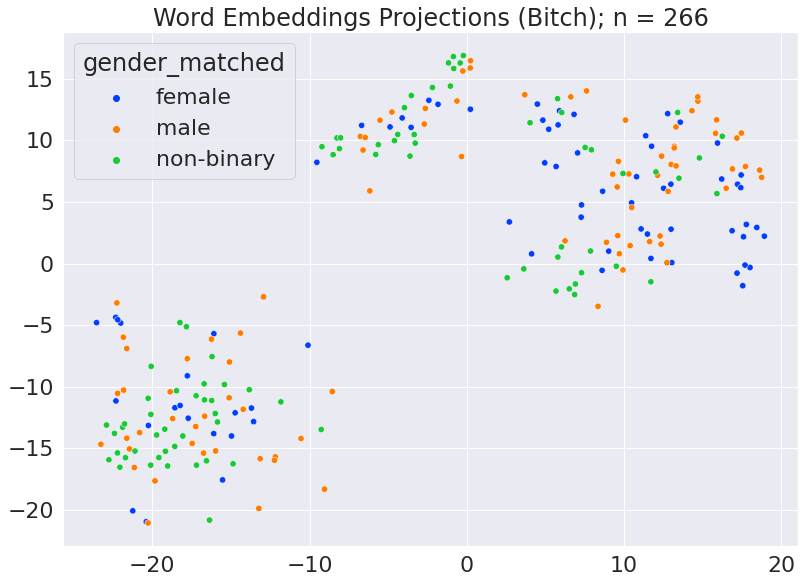

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1, hue = bitch_sample.loc[~bitch_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title(f"Word Embeddings Projections (Bitch); n = {len(emb_lst_b)}")
plt.savefig("b_word.png")

#### Clustering Analysis

Looks like there are three general clusters for "bitch". We use the reduced dimention data to perform k-means.

In [ ]:
tsneB_.shape #reduced the embeddings from 768 to 2-d

(266, 2)

In [ ]:
tsneB_df

0          1  label
0    25.509937  -8.714007      1
1    10.188588 -26.557081      1
2    46.858871 -57.558914      1
3   103.051720   3.015114      1
4    -9.680226 -48.001793      1
5    30.442999  28.851692      1
6    47.300640   5.491689      1
7    82.560287  22.079611      1
8    47.023911 -18.077553      1
9   -55.246788  18.937826      0
10   75.683868  -2.334906      1
11   12.605279  12.696823      1
12 -124.776543  15.415695      0
13  -13.832134   8.406882      1
14  -15.724462 -14.978491      1
15   91.098038 -22.525858      1
16 -132.248001 -33.041058      0
17   53.980877  33.919640      1
18   30.833187 -37.977821      1
19   61.722530 -35.412842      1
20    4.613424  35.916336      1
21    8.926763  86.316223      1
22  131.910187 -22.183933      1
23 -103.986595  57.829182      0
24  -68.528435  58.389759      0
25  -63.805058 -25.199099      0
26  -88.758980  25.095894      0
27   35.944515  92.648865      1
28  121.776299 -45.311001      1
29   55.107754  65.442192      1
30  -12.734761  64.444771      1
31   82.455299  64.147995      1
32  -88.470993 -58.046562      0
33   84.627281 -60.201828      1
34   18.306202 -69.965714      1
35   23.241909  56.459858      1
36  -72.595886   0.254025      0
37  -46.815556  -6.385273      0
38  -49.329414 -63.224209      0
39  -99.306374 -15.571250      0
40  111.545372  35.377190      1
41  -27.649088  37.793396      1

In [ ]:
tsneB_df.shape

(266, 3)

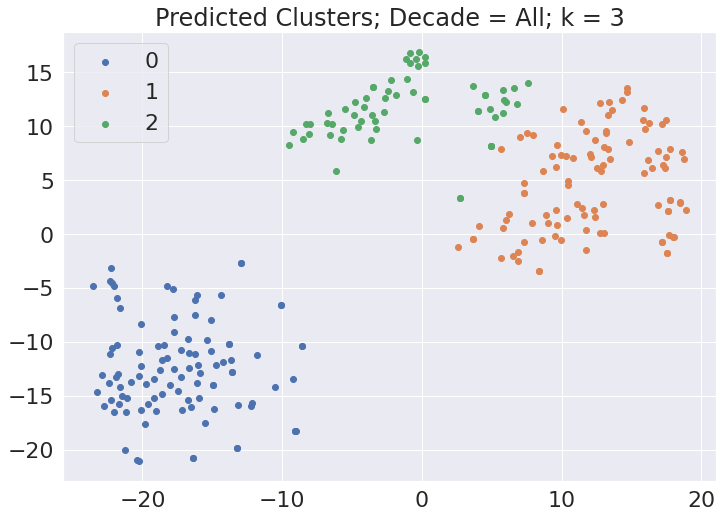

In [ ]:
numCluster = 3
numCategories = numCluster

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, random_state = 7, init='k-means++')
exampleKM.fit(tsneB_)

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
tsneB_df = pd.DataFrame(tsneB_)
tsneB_df['label'] = exampleKM.labels_
fig, ax = plt.subplots()

for i in range(3):
  scatter = ax.scatter(tsneB_df[tsneB_df.label == i].iloc[:, 0], tsneB_df[tsneB_df.label == i].iloc[:, 1],\
                      alpha = 1, label = i)
plt.legend()

plt.title('Predicted Clusters; Decade = All; k = {}'.format(numCategories))
plt.savefig("b_word_cluster.png")
plt.show()


In [ ]:
bitch_fetched = bitch_sample.loc[~bitch_sample.index.isin(na_lst)].reset_index()

In [ ]:
bitch_fetched.shape

(266, 19)

In [ ]:
bitch_fetched['tsne_1'] = tsneB_[:,1]
bitch_fetched['tsne_0'] = tsneB_[:,0]
#bitch_fetched = pd.concat([bitch_fetched, tsneB_df], axis=1)

In [ ]:
from scipy.spatial.distance import cdist
min_dist = np.min(cdist(tsneB_, exampleKM.cluster_centers_, 'euclidean'), axis=1)
bitch_fetched['dist_center'] = min_dist

In [ ]:
metrics.homogeneity_score(bitch_fetched['gender_matched'], bitch_fetched['label'])

0.019974134718399032

In [ ]:
metrics.completeness_score(bitch_fetched['gender_matched'], bitch_fetched['label'])

0.020384780086862033

In [ ]:
bitch_fetched['label'] = exampleKM.labels_
grouped = bitch_fetched[['dist_center', 'label', 'gender_matched']].groupby(['label', 'gender_matched'])
grouped.idxmin()

dist_center
label gender_matched             
0     female                   15
      male                    128
      non-binary              261
1     female                   51
      male                    161
      non-binary              239
2     female                   41
      male                    104
      non-binary              200

In [ ]:
bitch_fetched.iloc[15]

index                                                            16
title                                                          Only
artist                                                  Nicki Minaj
lyrics            Nicki Minaj\nYo, I never fucked Wayne, I never...
year                                                           2015
popularity                                                      NaN
edm                                                           False
latin                                                         False
pop                                                            True
r&b                                                           False
rap                                                            True
rock                                                          False
Gender                                                       female
year_bin                                                      2010s
artist_lower                                    

In [ ]:
bitch_fetched.iloc[128]

index                                                           140
title                                                          Ffoe
artist                                                     Big Sean
lyrics            The best drinks good tree and bad bitches I go...
year                                                           2012
popularity                                                      NaN
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                           False
rap                                                            True
rock                                                          False
Gender                                                      Unknown
year_bin                                                      2010s
artist_lower                                    

In [ ]:
bitch_fetched.iloc[261]

index                                                           295
title                                                      New York
artist                                                   Angel Haze
lyrics            I'm running running through the jungle Running...
year                                                           2013
popularity                                                      NaN
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                           False
rap                                                            True
rock                                                          False
Gender                                                      Unknown
year_bin                                                      2010s
artist_lower                                    

In [ ]:
bitch_fetched.iloc[51]

index                                                            57
title                                                  Barbie Tingz
artist                                                  Nicki Minaj
lyrics            Dem-dem-dem-dem dem-dem Dem-dem-dem-dem Dem-de...
year                                                           2018
popularity                                                     65.0
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                            True
rap                                                           False
rock                                                          False
Gender                                                      Unknown
year_bin                                                      2010s
artist_lower                                    

In [ ]:
bitch_fetched.iloc[161]

index                                                           179
title                                                       Tourist
artist                                                    Dj Khaled
lyrics            We The Best Music How many times the merry go ...
year                                                           2016
popularity                                                      NaN
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                           False
rap                                                            True
rock                                                          False
Gender                                                      Unknown
year_bin                                                      2010s
artist_lower                                    

In [ ]:
bitch_fetched.iloc[239]

index                                                           270
title                                                Black Skinhead
artist                                                   Angel Haze
lyrics             Verse Back in the booth and I'm bout to attac...
year                                                           2013
popularity                                                      NaN
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                           False
rap                                                            True
rock                                                          False
Gender                                                      Unknown
year_bin                                                      2010s
artist_lower                                    

In [ ]:
bitch_fetched.iloc[41]

index                                                            45
title                                                        Trophy
artist                                                   Charli Xcx
lyrics             I wanna win I want that trophy Woo woo Throw ...
year                                                           2016
popularity                                                      NaN
edm                                                           False
latin                                                         False
pop                                                            True
r&b                                                           False
rap                                                           False
rock                                                          False
Gender                                                      Unknown
year_bin                                                      2010s
artist_lower                                    

In [ ]:
bitch_fetched.iloc[104]

index                                                           114
title                                                     No Target
artist                                                    21 Savage
lyrics            21 21 21 Ya ya ya ya I got dope fiends and tas...
year                                                           2016
popularity                                                      NaN
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                           False
rap                                                            True
rock                                                          False
Gender                                                      Unknown
year_bin                                                      2010s
artist_lower                                    

In [ ]:
bitch_fetched.iloc[200]

index                                                           223
title                                                Black Skinhead
artist                                                   Angel Haze
lyrics             Verse Back in the booth and I'm bout to attac...
year                                                           2013
popularity                                                      NaN
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                           False
rap                                                            True
rock                                                          False
Gender                                                      Unknown
year_bin                                                      2010s
artist_lower                                    

### Random Sampling for Analysis for time slices 90s, 10s and 11s (no incident of female using bitch before 90s or non-binary before 10s)

### 90s


In [ ]:
ninety = bitch_df.loc[bitch_df.year_bin == "1990s"]
ninety.gender_matched.value_counts()

male      417
female     21
Name: gender_matched, dtype: int64

In [ ]:
ninety_sample = ninety.groupby("gender_matched").sample(21, random_state=7).reset_index(drop=True)

In [ ]:
ninety_sample.head()

title           artist  \
0  I'm Real - Murder Remix   Jennifer Lopez   
1  I'm Real - Murder Remix   Jennifer Lopez   
2  I'm Real - Murder Remix   Jennifer Lopez   
3                    Bitch  Meredith Brooks   
4               U.N.I.T.Y.    Queen Latifah   

                                              lyrics  year  popularity    edm  \
0  Uh, what? Uh, uh, uh Let's go Called you on th...  1999         1.0  False   
1  Uh, what? Uh, uh, uh Let's go Called you on th...  1999         1.0  False   
2  Uh, what? Uh, uh, uh Let's go Called you on th...  1999         1.0  False   
3  I hate the world today\nYou're so good to me\n...  1997         NaN  False   
4  (uh)U-N-I-T-Y\nU-N-I-T-Y (That's a unity)\nU-N...  1994         NaN  False   

   latin    pop    r&b    rap   rock   Gender year_bin     artist_lower  \
0  False  False   True  False  False  Unknown    1990s   jennifer lopez   
1  False  False   True  False  False  Unknown    1990s   jennifer lopez   
2  False  False   True  False  False  Unknown    1990s   jennifer lopez   
3  False   True  False  False   True   female    1990s  meredith brooks   
4  False  False  False   True  False   female    1990s    queen latifah   

  gender_matched                                          segmented  \
0         female                           (She's a bad, bad bitch)   
1         female                           (She's a bad, bad bitch)   
2         female                           (She's a bad, bad bitch)   
3         female                                        I'm a bitch   
4         female  Then the little one said (Yeah me bitch) and l...   

   song_index                                     tokenized_text  
0        1242  ['[CLS]', '(', 'she', "'", 's', 'a', 'bad', ',...  
1        1242  ['[CLS]', '(', 'she', "'", 's', 'a', 'bad', ',...  
2        1242  ['[CLS]', '(', 'she', "'", 's', 'a', 'bad', ',...  
3        7430    ['[CLS]', 'i', "'", 'm', 'a', 'bitch', '[SEP]']  
4        7335  ['[CLS]', 'then', 'the', 'little', 'one', 'sai...

In [ ]:
sents = ninety_sample.segmented.values.tolist()

In [ ]:
len(sents)

42

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, bitch_lst, layers = [-2], model = "/content/lyrics-bert2") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

#### Visualize Embeddings

In [ ]:
len(emb_lst_b)

42

In [ ]:
len(na_lst)

0

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(42, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 42).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2, random_state = 7).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


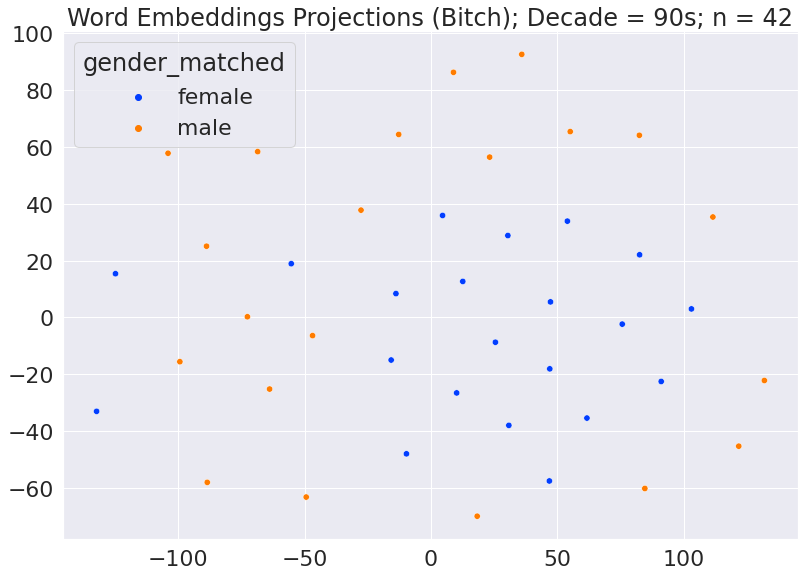

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1, hue = ninety_sample .loc[~ninety_sample .index.isin(na_lst)].gender_matched, \
                palette="bright")
plt.tight_layout()
plt.title(f"Word Embeddings Projections (Bitch); Decade = 90s; n = {len(emb_lst_b)}")
plt.savefig("b_word_90s.png")

#### Clustering Analysis

Looks like there are 2 general clusters for "bitch". We use the reduced dimention data to perform k-means.

In [ ]:
tsneB_.shape #reduced the embeddings from 768 to 2-d

(42, 2)

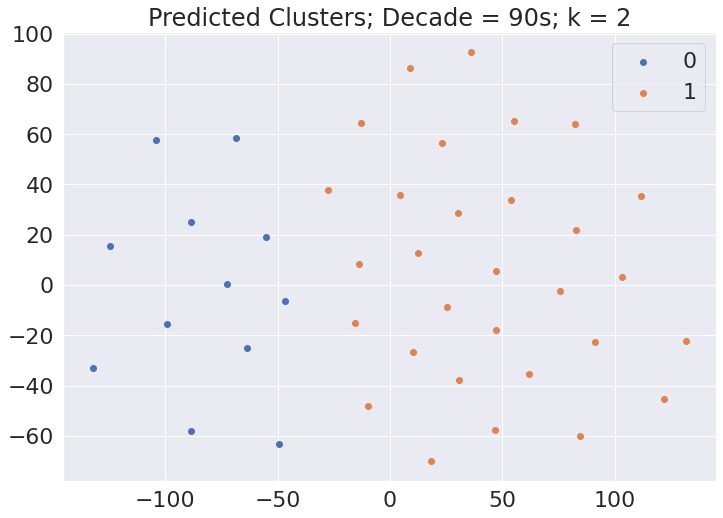

In [ ]:
numCluster = 2
numCategories = numCluster

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, random_state = 7, init='k-means++')
exampleKM.fit(embs_B)

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
tsneB_df = pd.DataFrame(tsneB_)
tsneB_df['label'] = exampleKM.labels_
fig, ax = plt.subplots()

for i in range(numCluster):
  scatter = ax.scatter(tsneB_df[tsneB_df.label == i].iloc[:, 0], tsneB_df[tsneB_df.label == i].iloc[:, 1],\
                      alpha = 1, label = i)
plt.legend()

plt.title('Predicted Clusters; Decade = 90s; k = {}'.format(numCategories))
plt.savefig("b_word_cluster_90s.png")
plt.show()


In [ ]:
ninety_fetched = ninety_sample.loc[~ninety_sample.index.isin(na_lst)]

In [ ]:
ninety_fetched.shape

(42, 18)

In [ ]:
ninety_fetched['tsne_1'] = tsneB_[:,1]
ninety_fetched['tsne_0'] = tsneB_[:,0]

In [ ]:
from scipy.spatial.distance import cdist
min_dist = np.min(cdist(embs_B, exampleKM.cluster_centers_, 'euclidean'), axis=1)
ninety_fetched['dist_center'] = min_dist

In [ ]:
metrics.homogeneity_score(ninety_fetched['gender_matched'], ninety_fetched['label'])

0.07467011125834154

In [ ]:
sklearn.metrics.completeness_score(ninety_fetched['gender_matched'], ninety_fetched['label'])

0.08651179681923798

In [ ]:
ninety_fetched['label'] = exampleKM.labels_
grouped = ninety_fetched[['dist_center', 'label', 'gender_matched']].groupby(['label', 'gender_matched'])
grouped.idxmin()

dist_center
label gender_matched             
0     female                    9
      male                     25
1     female                    0
      male                     34

In [ ]:
ninety_fetched.iloc[0]

title                                       I'm Real - Murder Remix
artist                                               Jennifer Lopez
lyrics            Uh, what? Uh, uh, uh Let's go Called you on th...
year                                                           1999
popularity                                                      1.0
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                            True
rap                                                           False
rock                                                          False
Gender                                                      Unknown
year_bin                                                      1990s
artist_lower                                         jennifer lopez
gender_matched                                  

In [ ]:
ninety_fetched.iloc[34]

title                                            I Ain't Mad At Cha
artist                                                         2Pac
lyrics            Change, shit I guess change is good for any of...
year                                                           1996
popularity                                                     58.0
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                           False
rap                                                            True
rock                                                          False
Gender                                                      Unknown
year_bin                                                      1990s
artist_lower                                                   2pac
gender_matched                                  

In [ ]:
ninety_fetched.iloc[9]

title                                                       No Time
artist                                                     Lil' Kim
lyrics            I got no time for fake niggas\nJust sip some c...
year                                                           1997
popularity                                                      NaN
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                           False
rap                                                            True
rock                                                          False
Gender                                                       female
year_bin                                                      1990s
artist_lower                                                lil kim
gender_matched                                  

In [ ]:
ninety_fetched.iloc[25]

title                                            The World Is Yours
artist                                                          Nas
lyrics            NA (It's yours) Whose world is this? The world...
year                                                           1994
popularity                                                     60.0
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                            True
rap                                                           False
rock                                                          False
Gender                                                      Unknown
year_bin                                                      1990s
artist_lower                                                    nas
gender_matched                                  

### 00s


In [ ]:
twothou = bitch_df.loc[bitch_df.year_bin == "2000s"]
twothou.gender_matched.value_counts()

male      4860
female     111
Name: gender_matched, dtype: int64

In [ ]:
twothou_sample = twothou.groupby("gender_matched").sample(twothou.gender_matched.value_counts().min(), random_state=7).reset_index(drop=True)

In [ ]:
twothou_sample.head()

title              artist  \
0                       Gimme More      Britney Spears   
1              Til T Cha Head Back  Christina Aguilera   
2                        Freakshow      Britney Spears   
3              Keep Getting Better  Christina Aguilera   
4  Gimme More Paul Oakenfold Remix      Britney Spears   

                                              lyrics  year  popularity    edm  \
0   It's Britney bitch I see you And I just want ...  2007         NaN  False   
1  Somebody give me a bass line Yeah that stuff D...  2007         NaN  False   
2  Ten p m ten to four And I came to hit the floo...  2007         NaN  False   
3  Step back gonna come at ya fast I'm driving ou...  2008         NaN  False   
4   It's Britney bitch I see you And I just want ...  2007         NaN  False   

   latin   pop    r&b    rap   rock   Gender year_bin        artist_lower  \
0  False  True  False  False  False  Unknown    2000s      britney spears   
1  False  True  False  False  False  Unknown    2000s  christina aguilera   
2  False  True  False  False  False  Unknown    2000s      britney spears   
3  False  True  False  False  False  Unknown    2000s  christina aguilera   
4  False  True  False  False  False  Unknown    2000s      britney spears   

  gender_matched                                          segmented  \
0         female                                 It's Britney bitch   
1         female  so I got a little bit of that a little bit of ...   
2         female        that boy so fast Make dem other bitches mad   
3         female    Some days I'm a super bitch Up to my old tricks   
4         female                                 It's Britney bitch   

   song_index                                     tokenized_text  
0       20130  ['[CLS]', 'it', "'", 's', 'britney', 'bitch', ...  
1       31959  ['[CLS]', 'so', 'i', 'got', 'a', 'little', 'bi...  
2       20162  ['[CLS]', 'that', 'boy', 'so', 'fast', 'make',...  
3       32177  ['[CLS]', 'some', 'days', 'i', "'", 'm', 'a', ...  
4       20159  ['[CLS]', 'it', "'", 's', 'britney', 'bitch', ...

In [ ]:
sents = twothou_sample.segmented.values.tolist()

In [ ]:
len(sents)

222

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, bitch_lst, layers = [-2], model = "/content/lyrics-bert2") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

#### Visualize Embeddings

In [ ]:
len(emb_lst_b)

204

In [ ]:
len(na_lst)

18

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(204, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 42).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2, random_state = 7).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


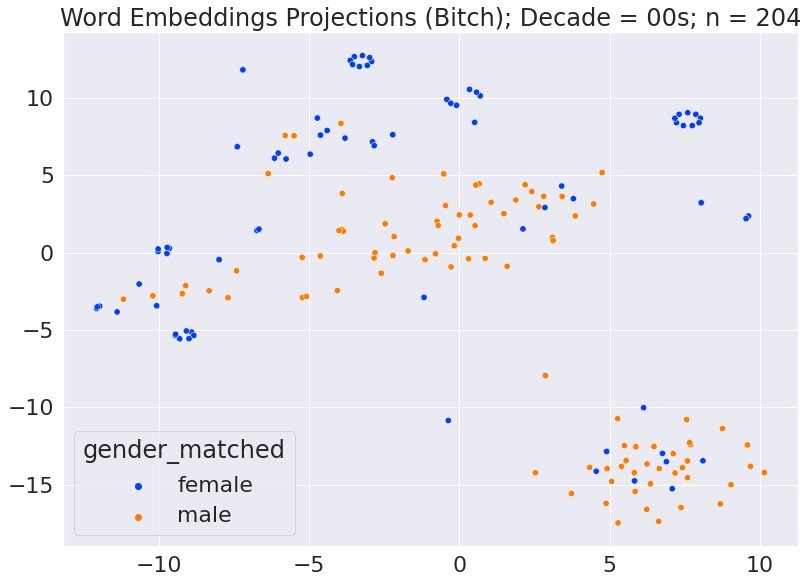

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1, hue = twothou_sample.loc[~twothou_sample .index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title(f"Word Embeddings Projections (Bitch); Decade = 00s; n = {len(emb_lst_b)}")
plt.savefig("b_word_00s.png")

#### Clustering Analysis

Looks like there are 4 general clusters for "bitch". We use the reduced dimention data to perform k-means.

In [ ]:
tsneB_.shape #reduced the embeddings from 768 to 2-d

(204, 2)

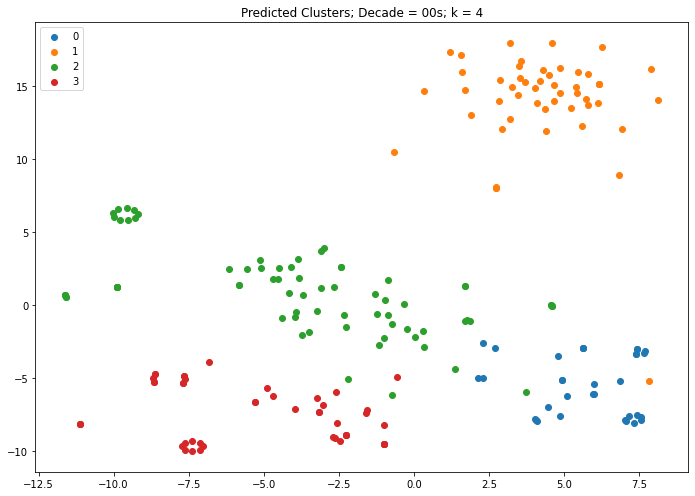

In [ ]:
numCluster = 4
numCategories = numCluster

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, random_state = 7, init='k-means++')
exampleKM.fit(embs_B)

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
tsneB_df = pd.DataFrame(tsneB_)
tsneB_df['label'] = exampleKM.labels_
fig, ax = plt.subplots()

for i in range(numCluster):
  scatter = ax.scatter(tsneB_df[tsneB_df.label == i].iloc[:, 0], tsneB_df[tsneB_df.label == i].iloc[:, 1],\
                      alpha = 1, label = i)
plt.legend()

plt.title('Predicted Clusters; Decade = 00s; k = {}'.format(numCategories))
plt.savefig("b_word_cluster_00s.png")
plt.show()


In [ ]:
twothou_fetched = twothou_sample.loc[~twothou_sample.index.isin(na_lst)].reset_index(drop = True)

In [ ]:
twothou_fetched['tsne_1'] = tsneB_[:,1]
twothou_fetched['tsne_0'] = tsneB_[:,0]
twothou_fetched['label'] = exampleKM.labels_

In [ ]:
from scipy.spatial.distance import cdist
min_dist = np.min(cdist(embs_B, exampleKM.cluster_centers_, 'euclidean'), axis=1)
twothou_fetched['dist_center'] = min_dist

In [ ]:
metrics.homogeneity_score(twothou_fetched['gender_matched'], twothou_fetched['label'])

0.18006513139659983

In [ ]:
sklearn.metrics.completeness_score(twothou_fetched['gender_matched'], twothou_fetched['label'])

0.09241406129592303

In [ ]:
#twothou_fetched = twothou_fetched.drop(index=13).reset_index(drop = True)
twothou_fetched = twothou_fetched.loc[(twothou_fetched.title != "I M A Bitch I M A Lover") & (twothou_fetched.title != "Im A Bitch")].reset_index(drop = True)

In [ ]:
grouped = twothou_fetched[['dist_center', 'label', 'gender_matched']].groupby(['label', 'gender_matched'])
grouped.idxmin()

dist_center
label gender_matched             
0     female                    0
      male                    121
1     female                   82
      male                    161
2     female                    8
      male                    106
3     female                   75
      male                    158

In [ ]:
twothou_fetched.iloc[grouped.idxmin()['dist_center'].values.tolist()]

title              artist  \
0        Gimme More      Britney Spears   
121     Go To Sleep              Eminem   
82         Gorgeous   Alanis Morissette   
161        Superman              Eminem   
8       Bad Romance           Lady Gaga   
106           Roses             OutKast   
75   Shut Up Eminem  Christina Aguilera   
158      Sexy Bitch        David Guetta   

                                                lyrics  year  popularity  \
0     It's Britney bitch I see you And I just want ...  2007         NaN   
121  I ain't gonna eat I ain't gonna sleep Ain't go...  2007         NaN   
82   Testosterone in large amounts Your little sist...  2006         NaN   
161  Spoken\n(Mmmhh)\nYou high baby? (Yeah)\nYeah? ...  2003         NaN   
8    Oh-oh-oh-oh-oh-oh-oh-oh-oh-oh-oh-oh Caught in ...  2009        26.0   
106  Caroline (Caroline), see, Caroline All the guy...  2003        71.0   
75   You've got some nerve now baby don't you I nev...  2008         NaN   
158  Yes I can see her Cause every girl in here wan...  2009         NaN   

       edm  latin    pop    r&b    rap  ...  year_bin        artist_lower  \
0    False  False   True  False  False  ...     2000s      britney spears   
121  False  False  False  False   True  ...     2000s              eminem   
82   False  False  False  False  False  ...     2000s   alanis morissette   
161  False  False   True  False   True  ...     2000s              eminem   
8     True  False  False  False  False  ...     2000s           lady gaga   
106  False  False  False  False   True  ...     2000s             outkast   
75   False  False   True  False  False  ...     2000s  christina aguilera   
158   True  False  False  False  False  ...     2000s        david guetta   

    gender_matched                                          segmented  \
0           female                                 It's Britney bitch   
121           male                          ya eyes Go to sleep bitch   
82          female  You make it hard for us bitches inconsequentia...   
161           male  Bitches they come they go\nSaturday through Su...   
8           female  , move that bitch crazy Walk, walk, fashion, b...   
106           male                      Crazy bitch (A bitch's bitch)   
75          female                                    Call me a bitch   
158           male                                 who's a sexy bitch   

    song_index                                     tokenized_text     tsne_1  \
0        20130  ['[CLS]', 'it', "'", 's', 'britney', 'bitch', ...  -7.544475   
121      32540  ['[CLS]', 'ya', 'eyes', 'go', 'to', 'sleep', '...  -6.069469   
82        9440  ['[CLS]', 'you', 'make', 'it', 'hard', 'for', ...  15.426865   
161       7785  ['[CLS]', 'bitch', '##es', 'they', 'come', 'th...  13.869770   
8         1039  ['[CLS]', ',', 'move', 'that', 'bitch', 'crazy...   1.207573   
106       5033  ['[CLS]', 'crazy', 'bitch', '(', 'a', 'bitch',...  -1.120147   
75       32179     ['[CLS]', 'call', 'me', 'a', 'bitch', '[SEP]']  -8.060502   
158      14471  ['[CLS]', 'who', "'", 's', 'a', 'sexy', 'bitch...  -7.401377   

       tsne_0  label  dist_center  
0    7.425747      0     6.572570  
121  6.007465      0     7.701854  
82   2.875838      1     7.749843  
161  4.118042      1     7.948844  
8   -9.898225      2     8.264965  
106  1.707406      2     7.830150  
75  -2.560012      3     7.006697  
158 -1.599884      3     7.719078  

[8 rows x 22 columns]

#### Sihouette

For n_clusters = 2 The average silhouette_score is : 0.58718336
For n_clusters = 3 The average silhouette_score is : 0.48858082
For n_clusters = 4 The average silhouette_score is : 0.5591139
For n_clusters = 5 The average silhouette_score is : 0.5764055
For n_clusters = 6 The average silhouette_score is : 0.5725934


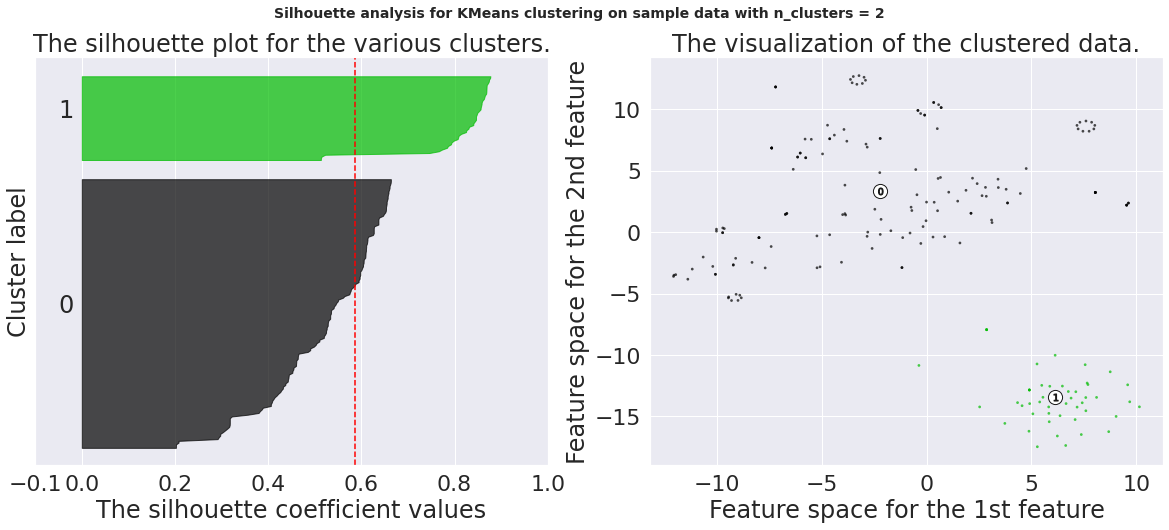

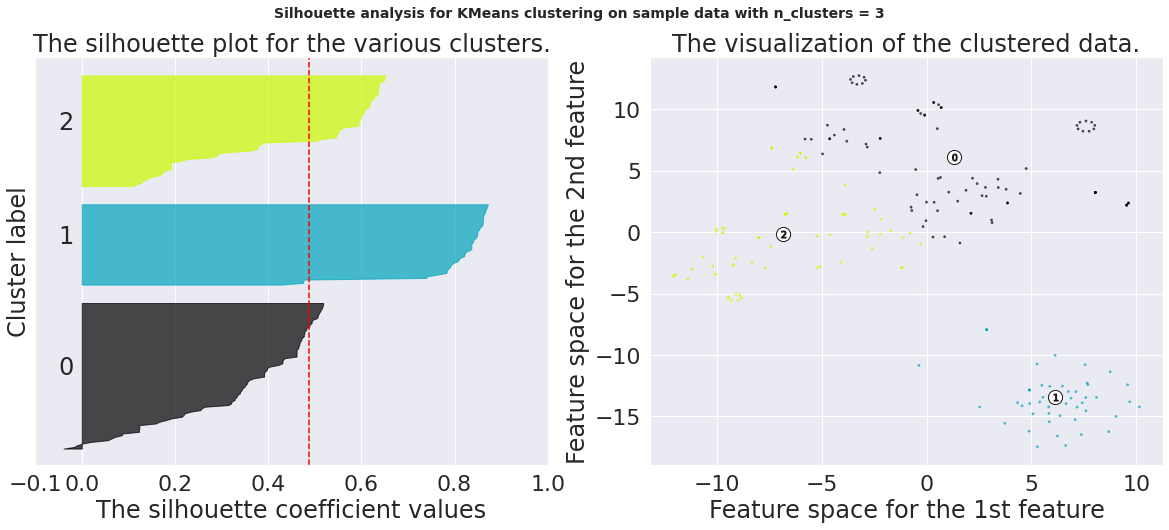

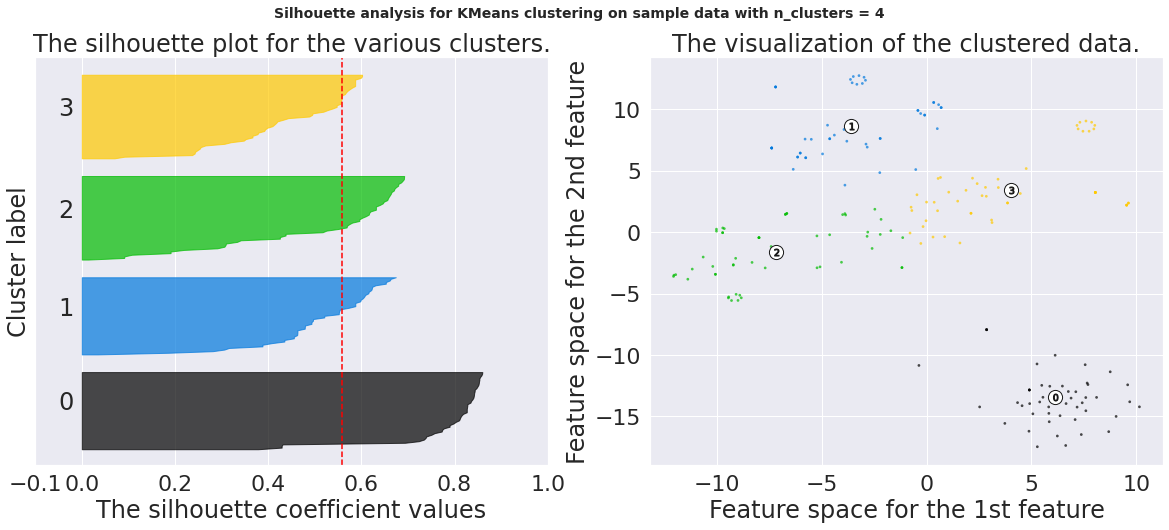

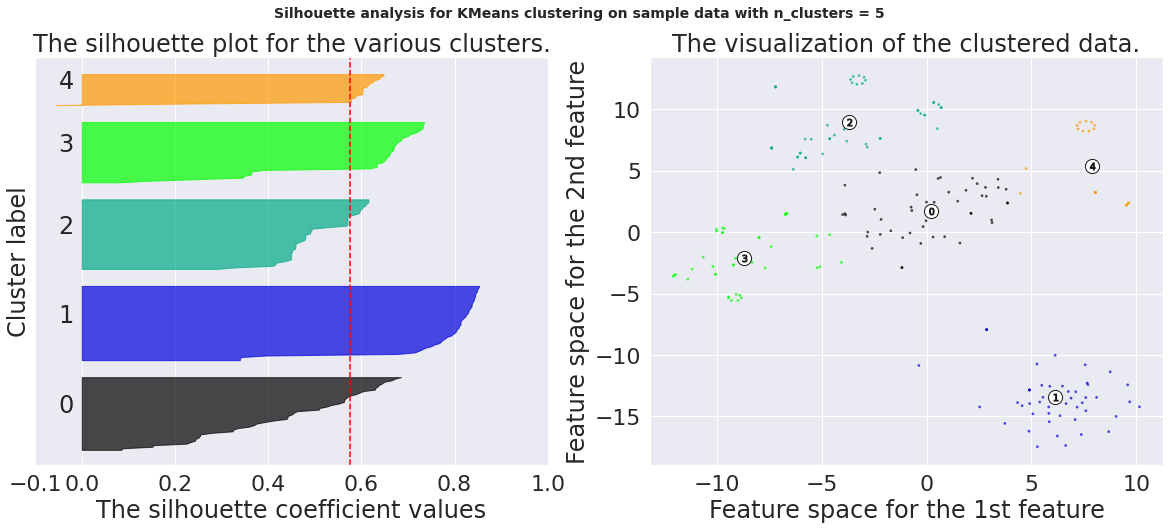

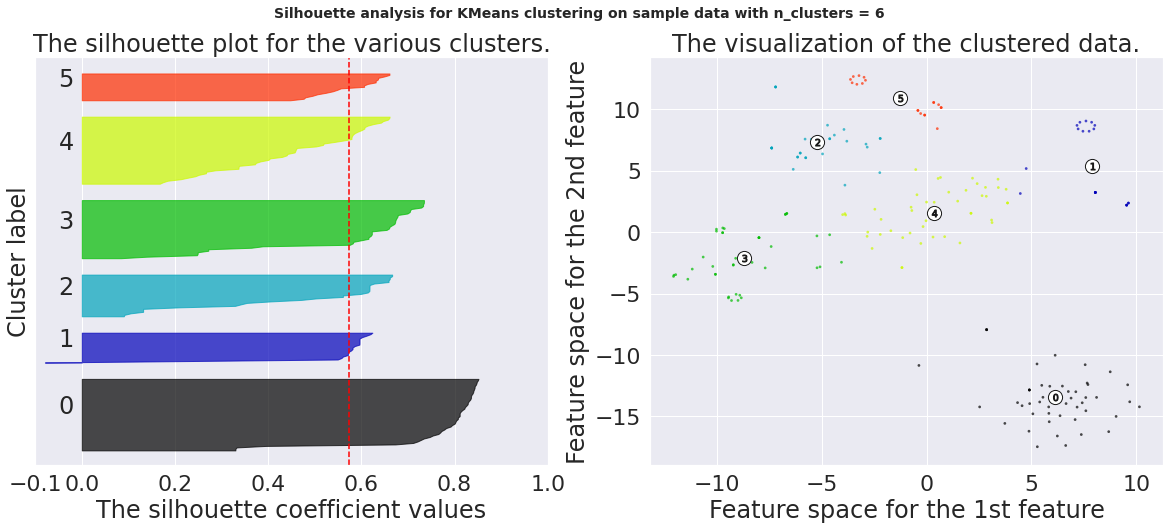

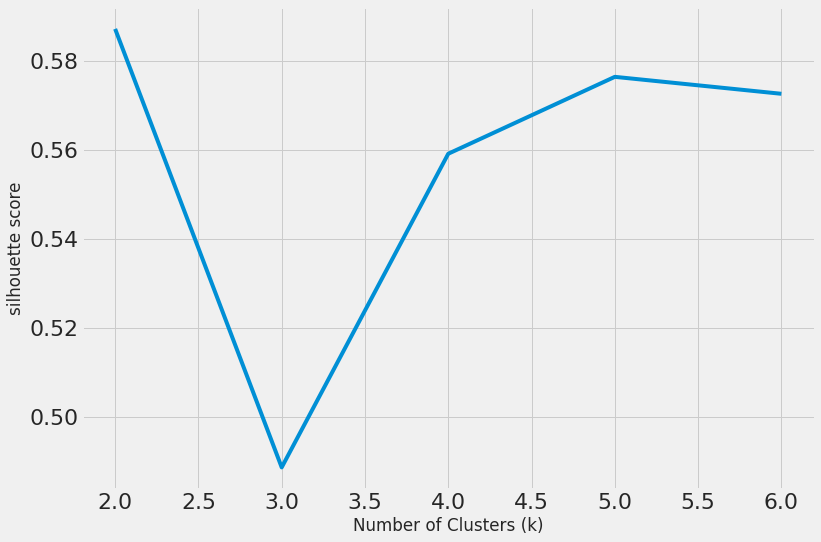

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(tsneB_) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(tsneB_)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(tsneB_, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(tsneB_, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tsneB_[:, 0], tsneB_[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

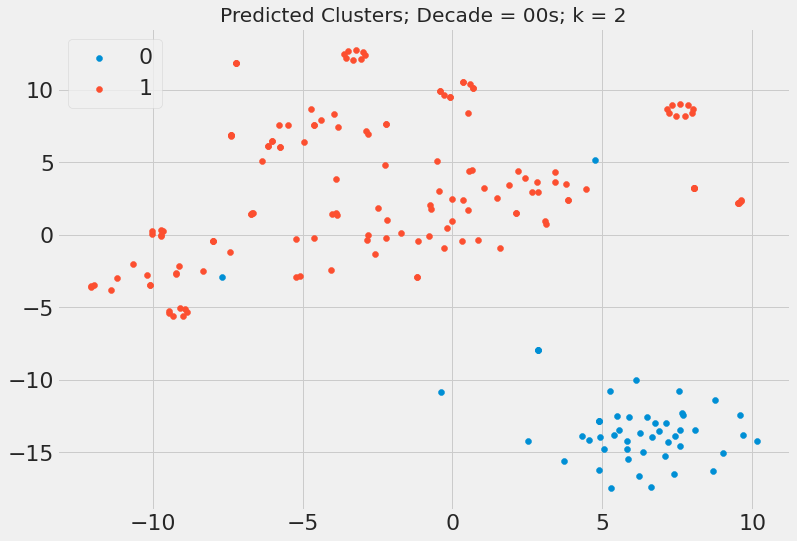

In [ ]:
numCluster = 2
numCategories = numCluster

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, random_state = 7, init='k-means++')
exampleKM.fit(embs_B)

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
tsneB_df = pd.DataFrame(tsneB_)
tsneB_df['label'] = exampleKM.labels_
fig, ax = plt.subplots()

for i in range(numCluster):
  scatter = ax.scatter(tsneB_df[tsneB_df.label == i].iloc[:, 0], tsneB_df[tsneB_df.label == i].iloc[:, 1],\
                      alpha = 1, label = i)
plt.legend()

plt.title('Predicted Clusters; Decade = 00s; k = {}'.format(numCategories))
plt.savefig("b_word_cluster_00s.png")
plt.show()

In [ ]:
twothou_fetched = twothou_sample.loc[~twothou_sample.index.isin(na_lst)].reset_index()
twothou_fetched['tsne_1'] = tsneB_[:,1]
twothou_fetched['tsne_0'] = tsneB_[:,0]
twothou_fetched['label'] = exampleKM.labels_

min_dist = np.min(cdist(embs_B, exampleKM.cluster_centers_, 'euclidean'), axis=1)
twothou_fetched['dist_center'] = min_dist

print("homogenity:", metrics.homogeneity_score(twothou_fetched['gender_matched'], twothou_fetched['label']))
print("completeness:", metrics.completeness_score(twothou_fetched['gender_matched'], twothou_fetched['label']))

grouped = twothou_fetched[['dist_center', 'label', 'gender_matched', 'title']].groupby(['label', 'gender_matched'])

twothou_fetched.iloc[grouped.idxmin()['dist_center'].values.tolist()]

homogenity: 0.07490584565221362
completeness: 0.09210006965962368


/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


index           title              artist  \
87      90        Gorgeous   Alanis Morissette   
169    182        Superman              Eminem   
80      83  Shut Up Eminem  Christina Aguilera   
114    117           Roses             OutKast   

                                                lyrics  year  popularity  \
87   Testosterone in large amounts Your little sist...  2006         NaN   
169  Spoken\n(Mmmhh)\nYou high baby? (Yeah)\nYeah? ...  2003         NaN   
80   You've got some nerve now baby don't you I nev...  2008         NaN   
114  Caroline (Caroline), see, Caroline All the guy...  2003        71.0   

       edm  latin    pop    r&b  ...  year_bin        artist_lower  \
87   False  False  False  False  ...     2000s   alanis morissette   
169  False  False   True  False  ...     2000s              eminem   
80   False  False   True  False  ...     2000s  christina aguilera   
114  False  False  False  False  ...     2000s             outkast   

    gender_matched                                          segmented  \
87          female  You make it hard for us bitches inconsequentia...   
169           male  Bitches they come they go\nSaturday through Su...   
80          female                                    Call me a bitch   
114           male                      Crazy bitch (A bitch's bitch)   

    song_index                                     tokenized_text     tsne_1  \
87        9440  ['[CLS]', 'you', 'make', 'it', 'hard', 'for', ... -13.455524   
169       7785  ['[CLS]', 'bitch', '##es', 'they', 'come', 'th... -14.948299   
80       32179     ['[CLS]', 'call', 'me', 'a', 'bitch', '[SEP]']   6.378372   
114       5033  ['[CLS]', 'crazy', 'bitch', '(', 'a', 'bitch',...   1.400523   

       tsne_0 label  dist_center  
87   8.107350     0     7.749843  
169  6.364625     0     7.948844  
80  -4.966286     1     8.413325  
114 -3.864120     1     7.714285  

[4 rows x 23 columns]

### 10s


In [ ]:
ten = bitch_df.loc[bitch_df.year_bin == "2010s"]
ten.gender_matched.value_counts()

male          10869
female          785
non-binary      213
Name: gender_matched, dtype: int64

In [ ]:
ten_sample = ten.groupby("gender_matched").sample(ten.gender_matched.value_counts().min(), random_state=7).reset_index(drop=True)

In [ ]:
ten_sample.head()

title      artist  \
0  Bitch Better Have My Money - R3hab Remix     Rihanna   
1                                     Money     Cardi B   
2                Bitch Better Have My Money     Rihanna   
3                                Cloud Aura  Charli Xcx   
4                                    Say So    Doja Cat   

                                              lyrics  year  popularity    edm  \
0  Yayo, yayo Mula-la Yayo Bitch better have my m...  2015         1.0   True   
1  Look, my bitches all bad, my niggas all real I...  2018        79.0  False   
2  Yayo, yayo Mula-la Yayo Bitch better have my m...  2015        75.0  False   
3  Baby what hurts the most is when you become so...  2012         NaN  False   
4  Day to night to morning, keep with me in the m...  2019        88.0  False   

   latin    pop    r&b    rap   rock   Gender year_bin artist_lower  \
0  False  False  False  False  False  Unknown    2010s      rihanna   
1   True  False  False  False  False  Unknown    2010s      cardi b   
2  False  False  False   True  False  Unknown    2010s      rihanna   
3  False   True  False  False  False  Unknown    2010s   charli xcx   
4   True  False  False  False  False  Unknown    2010s     doja cat   

  gender_matched                                          segmented  \
0         female         my money Bitch better have my money Pay me   
1         female           All a bad bitch need is the (Money flow)   
2         female   what you owe me, don't act like you forgot Bitch   
3         female  but now I just regret shit Log into your email...   
4         female                         All of them bitches hating   

   song_index                                     tokenized_text  
0        4852  ['[CLS]', 'my', 'money', 'bitch', 'better', 'h...  
1        1996  ['[CLS]', 'all', 'a', 'bad', 'bitch', 'need', ...  
2         492  ['[CLS]', 'what', 'you', 'owe', 'me', ',', 'do...  
3       33432  ['[CLS]', 'but', 'now', 'i', 'just', 'regret',...  
4        2741  ['[CLS]', 'all', 'of', 'them', 'bitch', '##es'...

In [ ]:
sents = ten_sample.segmented.values.tolist()

In [ ]:
len(sents)

639

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, bitch_lst, layers = [-2], model = "/content/lyrics-bert2") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

#### Visualize Embeddings

In [ ]:
len(emb_lst_b)

565

In [ ]:
len(na_lst)

74

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(565, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 42).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2, random_state = 7).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


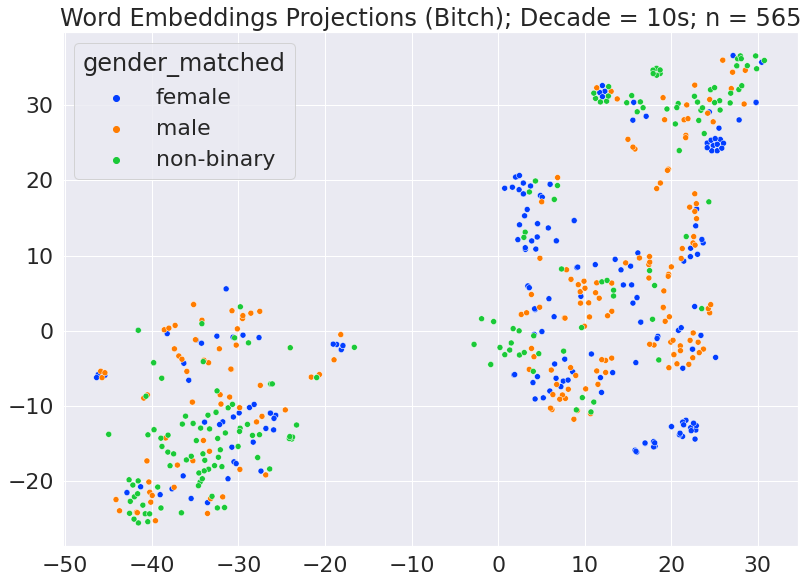

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1, hue = ten_sample.loc[~ten_sample.index.isin(na_lst)].gender_matched, \
                palette="bright")
plt.tight_layout()
plt.title(f"Word Embeddings Projections (Bitch); Decade = 10s; n = {len(emb_lst_b)}")
plt.savefig("b_word_10s.png")

#### Clustering Analysis

Clusters here is not distinguishable by eyeballing. We will use silhouette score to select the appropriate number.

In [ ]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(tsneB_[:, 0], tsneB_[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    projected_centers = clusterer.cluster_centers_
    #projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

For n_clusters = 2 The average silhouette_score is : 0.6565215
For n_clusters = 3 The average silhouette_score is : 0.61101323
For n_clusters = 4 The average silhouette_score is : 0.5097433
For n_clusters = 5 The average silhouette_score is : 0.44323653
For n_clusters = 6 The average silhouette_score is : 0.4761953


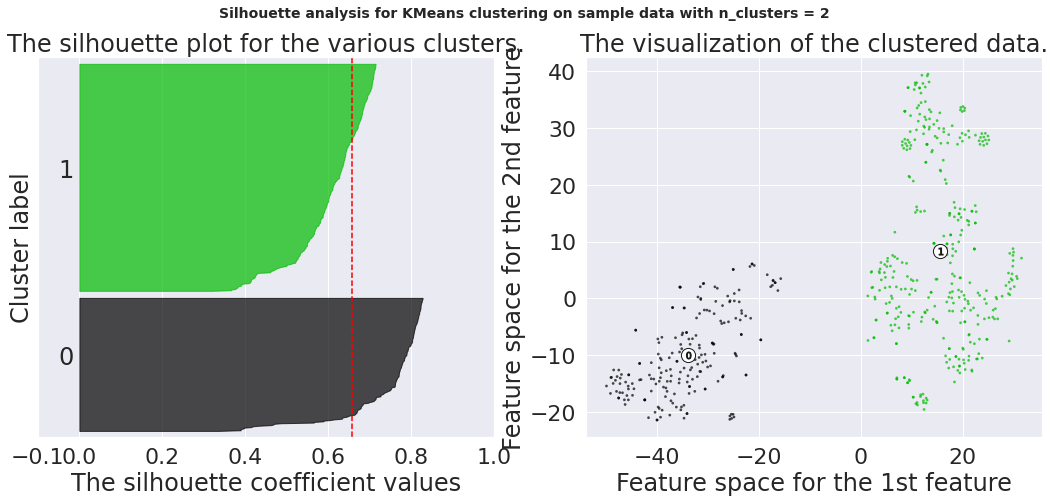

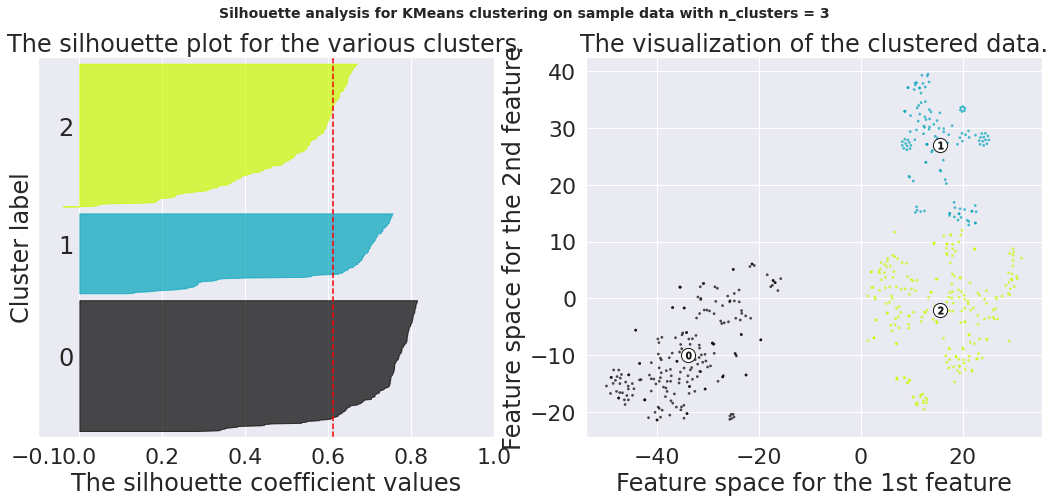

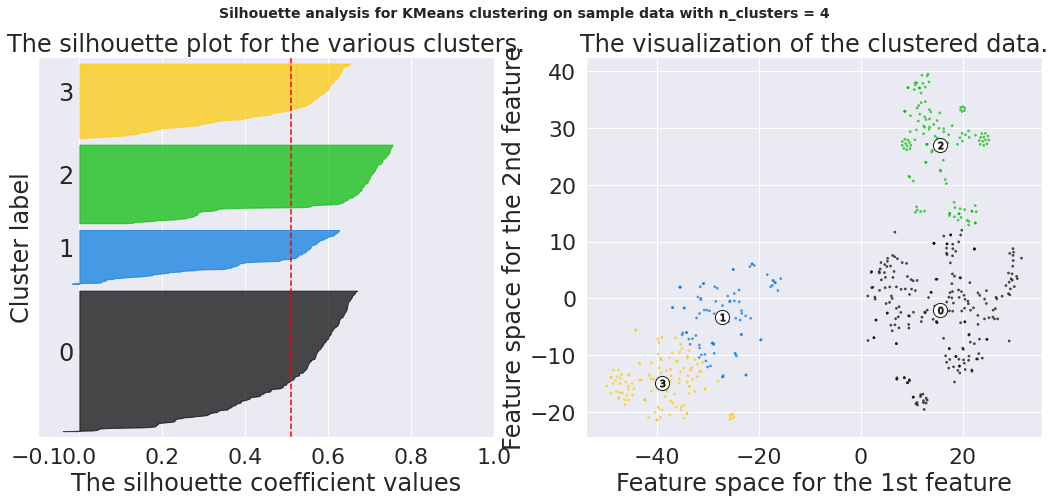

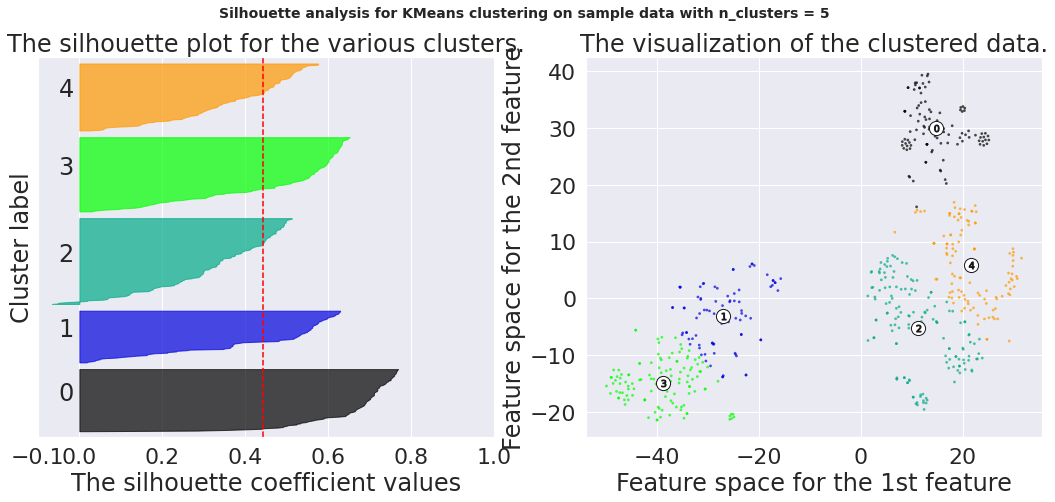

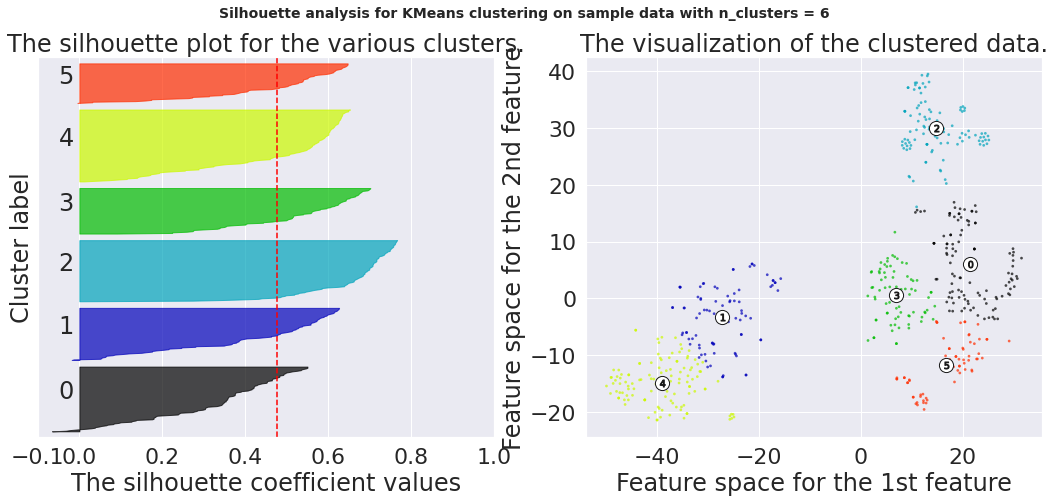

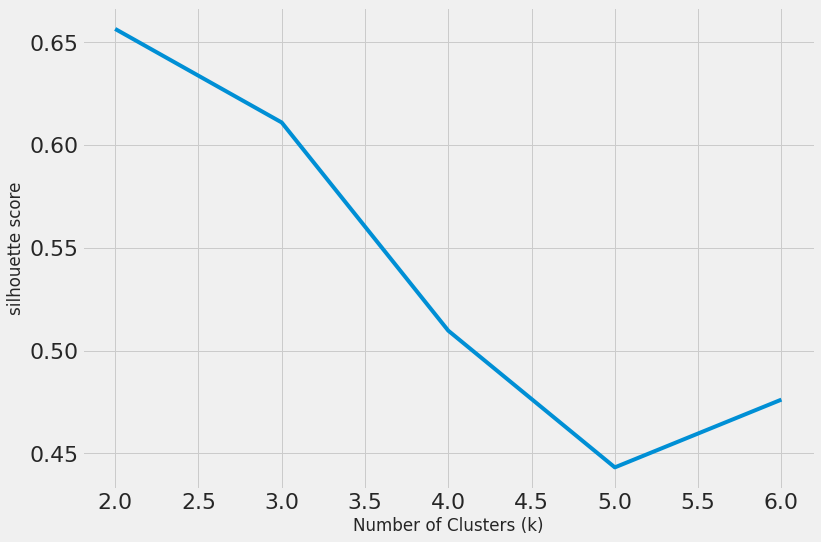

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(tsneB_) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(tsneB_)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(tsneB_, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(tsneB_, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(tsneB_[:, 0], tsneB_[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

In [ ]:
tsneB_.shape #reduced the embeddings from 768 to 2-d

(565, 2)

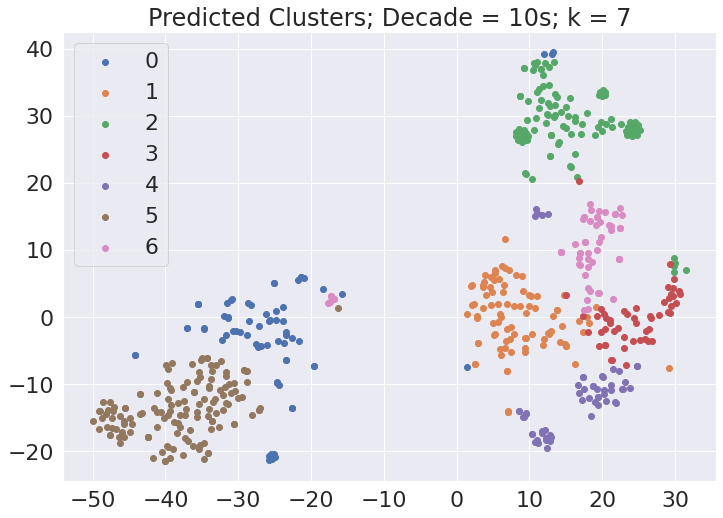

In [ ]:
numCluster = 7
numCategories = numCluster

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, random_state = 1000, init='k-means++')
exampleKM.fit(embs_B)

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
tsneB_df = pd.DataFrame(tsneB_)
tsneB_df['label'] = exampleKM.labels_
fig, ax = plt.subplots()

for i in range(numCluster):
  scatter = ax.scatter(tsneB_df[tsneB_df.label == i].iloc[:, 0], tsneB_df[tsneB_df.label == i].iloc[:, 1],\
                      alpha = 1, label = i)
plt.legend()

plt.title('Predicted Clusters; Decade = 10s; k = {}'.format(numCategories))
plt.savefig("b_word_cluster_10s.png")
plt.show()


In [ ]:
ten_fetched = ten_sample.loc[~ten_sample.index.isin(na_lst)].reset_index()

In [ ]:
ten_fetched.shape

(565, 19)

In [ ]:
ten_fetched['tsne_1'] = tsneB_[:,1]
ten_fetched['tsne_0'] = tsneB_[:,0]
ten_fetched['label'] = exampleKM.labels_

In [ ]:
#from scipy.spatial.distance import cdist
min_dist = np.min(cdist(embs_B, exampleKM.cluster_centers_, 'euclidean'), axis=1)
ten_fetched['dist_center'] = min_dist

In [ ]:
metrics.homogeneity_score(ten_fetched['gender_matched'], ten_fetched['label'])

0.09907911472793758

In [ ]:
sklearn.metrics.completeness_score(ten_fetched['gender_matched'], ten_fetched['label'])

0.05776597435669073

In [ ]:
grouped = ten_fetched[['dist_center', 'label', 'gender_matched', 'title']].groupby(['label', 'gender_matched'])
grouped.idxmin()

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


dist_center
label gender_matched             
0     female                   10
      male                    377
      non-binary              512
1     female                   49
      male                    335
      non-binary              540
2     female                  128
      male                    263
      non-binary              404
3     female                   95
      male                    312
      non-binary              484
4     female                   20
      male                    254
      non-binary              451
5     female                  186
      male                    270
      non-binary              455
6     female                   93
      male                    237
      non-binary              447

In [ ]:
ten_fetched.iloc[grouped.idxmin()['dist_center'].values.tolist()]

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


index                                     title              artist  \
10      10                                     Money             Cardi B   
377    422                  Loyal West Coast Version         Chris Brown   
512    579                        A Tribe Called Red          Angel Haze   
49      52                              Barbie Tingz         Nicki Minaj   
335    374                Ima Boss (feat. Rick Ross)           Meek Mill   
540    611                              Gossip Folks          Angel Haze   
128    140                                    Vanity  Christina Aguilera   
263    292                            Look At Me Now         Chris Brown   
404    451                              Werkin Girls          Angel Haze   
95     103                      Ring (feat. Kehlani)             Cardi B   
312    350          Mona Lisa (feat. Kendrick Lamar)           Lil Wayne   
484    548                              Gossip Folks          Angel Haze   
20      20  Bitch Better Have My Money - R3hab Remix             Rihanna   
254    283                                   Woke Up            Big Sean   
451    504                       Echelon It S My Way          Angel Haze   
186    204                                    Jackie               Ciara   
270    299                          Change Locations               Drake   
455    508            On The Edge Azealia Banks Diss          Angel Haze   
93     101                                     Alarm          Anne Marie   
237    261                            All Night Long               Drake   
447    500                                   So Long          Angel Haze   

                                                lyrics  year  popularity  \
10   Look, my bitches all bad, my niggas all real I...  2018        79.0   
377  Young Mula baby I woke up all last night I kno...  2014         NaN   
512  "I remember being asked a lot by a lot of diff...  2013         NaN   
49   Dem-dem-dem-dem dem-dem Dem-dem-dem-dem Dem-de...  2018        65.0   
335  Woo! Woo!M-M-Maybach Music Look I be ridin' th...  2011        65.0   
540  Angel Haze is coming through I heard Angel Haz...  2012         NaN   
128  I'm not cocky I just love myself bitch Mirror ...  2010         NaN   
263  I don't see how you can hate from outside of t...  2011         NaN   
404  Okay I'm Rambo I ramshack I'm next to that che...  2012         NaN   
95   Ooh, ooh Ring, ring, ring, ring You don't hit ...  2018        71.0   
312  I got a story to tell, you know that I cherish...  2018        71.0   
484  Angel Haze is coming through I heard Angel Haz...  2012         NaN   
20   Yayo, yayo Mula-la Yayo Bitch better have my m...  2015         1.0   
254  I woke up Boy its time to get it Walking to th...  2012         NaN   
451  I'm in that new school G5 wagon Color Komodo d...  2013         NaN   
186  Jackie was a girl more than just a girl She al...  2015         NaN   
270  Yeah know how nights like this go Ovofbg 60 Na...  2015         NaN   
455  All up in my black All up in my black All up i...  2013         NaN   
93   You're lay here with me you're shutting down I...  2016         NaN   
237  Kush rolled glass full I prefer the better thi...  2010         NaN   
447  All I wanted was to love you you had to make i...  2013         NaN   

       edm  latin    pop    r&b  ...  year_bin        artist_lower  \
10   False   True  False  False  ...     2010s             cardi b   
377  False  False  False  False  ...     2010s         chris brown   
512  False  False  False  False  ...     2010s          angel haze   
49   False  False  False   True  ...     2010s         nicki minaj   
335  False  False  False  False  ...     2010s           meek mill   
540  False  False  False  False  ...     2010s          angel haze   
128  False  False   True  False  ...     2010s  christina aguilera   
263  False  False  False  False  ...     2010s         chris brown   
404  False  False  False  Fal

#### 3 Cluster

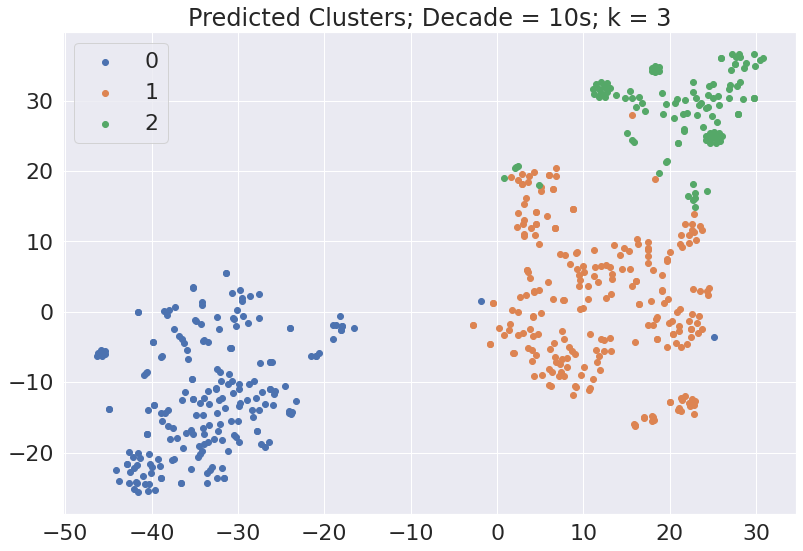

In [ ]:
numCluster = 3
numCategories = numCluster

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, random_state = 1000, init='k-means++')
exampleKM.fit(embs_B)

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
tsneB_df = pd.DataFrame(tsneB_)
tsneB_df['label'] = exampleKM.labels_
fig, ax = plt.subplots()

for i in range(numCluster):
  scatter = ax.scatter(tsneB_df[tsneB_df.label == i].iloc[:, 0], tsneB_df[tsneB_df.label == i].iloc[:, 1],\
                      alpha = 1, label = i)
plt.legend()

plt.title('Predicted Clusters; Decade = 10s; k = {}'.format(numCategories))
plt.savefig("b_word_cluster_10s.png")
plt.show()

In [ ]:
ten_fetched.iloc[186]['lyrics']

"Jackie was a girl more than just a girl She always had big dreams To see the whole world fall in love And do what her heart believed But mama said baby girl be tough Everything ain't what it seems I had to go through the things she went through I now know what it means Harmony drop that beat I'm a bad mah'fucker I'm a bad mah'fucker Can't even hate cause you know this shit hot Yeah I'm that bitch like it or not Better get ready cause I'm not gon stop stop stop Let that beat drop A lot of these bitches they came and they went I got a few things I'ma get off my chest Please don't act like you ain't heard what I said heard what I said You heard what I said I'ma B M F Shawty put my initials on it on it I'ma B M F I'ma put you all up on it on it I'ma B M F Shawty put my initials on it on it I'ma B M F I'ma put you all up on it on it Imagine delivering a 9 pound 10 ounce baby I'm a bad motherfucker Turn up I'm bad I'm bad I'm a bad mah'fucker I'm a bad mah'fucker This song's for you And you

In [ ]:
ten_fetched = ten_sample.loc[~ten_sample.index.isin(na_lst)].reset_index()
ten_fetched['tsne_1'] = tsneB_[:,1]
ten_fetched['tsne_0'] = tsneB_[:,0]
ten_fetched['label'] = exampleKM.labels_

min_dist = np.min(cdist(embs_B, exampleKM.cluster_centers_, 'euclidean'), axis=1)
ten_fetched['dist_center'] = min_dist

print("homogenity:", metrics.homogeneity_score(ten_fetched['gender_matched'], ten_fetched['label']))
print("completeness:", metrics.completeness_score(ten_fetched['gender_matched'], ten_fetched['label']))

grouped = ten_fetched[['dist_center', 'label', 'gender_matched', 'title']].groupby(['label', 'gender_matched'])

ten_fetched.iloc[grouped.idxmin()['dist_center'].values.tolist()]

homogenity: 0.04158967063993175
completeness: 0.04343074581589075


/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


index                           title              artist  \
186    204                          Jackie               Ciara   
270    299                Change Locations               Drake   
455    508  On The Edge Azealia Banks Diss          Angel Haze   
121    132                           Fancy         Iggy Azalea   
212    233           I Don't Fuck With You            Big Sean   
451    504             Echelon It S My Way          Angel Haze   
128    140                          Vanity  Christina Aguilera   
263    292                  Look At Me Now         Chris Brown   
404    451                    Werkin Girls          Angel Haze   

                                                lyrics  year  popularity  \
186  Jackie was a girl more than just a girl She al...  2015         NaN   
270  Yeah know how nights like this go Ovofbg 60 Na...  2015         NaN   
455  All up in my black All up in my black All up i...  2013         NaN   
121  Iggy\nFirst things first, I'm the realest (rea...  2014         NaN   
212  NA Uh, fuck, I don't fuck with you You lil' st...  2015         5.0   
451  I'm in that new school G5 wagon Color Komodo d...  2013         NaN   
128  I'm not cocky I just love myself bitch Mirror ...  2010         NaN   
263  I don't see how you can hate from outside of t...  2011         NaN   
404  Okay I'm Rambo I ramshack I'm next to that che...  2012         NaN   

       edm  latin    pop    r&b  ...  year_bin        artist_lower  \
186  False  False   True  False  ...     2010s               ciara   
270  False  False  False  False  ...     2010s               drake   
455  False  False  False  False  ...     2010s          angel haze   
121   True  False   True  False  ...     2010s         iggy azalea   
212  False  False  False  False  ...     2010s            big sean   
451  False  False  False  False  ...     2010s          angel haze   
128  False  False   True  False  ...     2010s  christina aguilera   
263  False  False  False  False  ...     2010s         chris brown   
404  False  False  False  False  ...     2010s          angel haze   

    gender_matched                                          segmented  \
186         female                             A lot of these bitches   
270           male                           them bitches gonna holla   
455     non-binary  I want you bitches so scared that your mental ...   
121         female         You should want a bad bitch like this (ha)   
212           male           dumb ass bitch, I ain't fuckin' with you   
451     non-binary                                     My bitch looks   
128         female                           I just love myself bitch   
263           male                           I'm out of my head bitch   
404     non-binary                     what you on All about me bitch   

    song_index                                     tokenized_text     tsne_1  \
186      13962  ['[CLS]', 'a', 'lot', 'of', 'these', 'bitch', ... -20.828051   
270      28846  ['[CLS]', 'them', 'bitch', '##es', 'gonna', 'h... -16.092115   
455       9974  ['[CLS]', 'i', 'want', 'you', 'bitch', '##es',... -17.295784   
121       8474  ['[CLS]', 'you', 'should', 'want', 'a', 'bad',...   4.240194   
212       3999  ['[CLS]', 'dumb', 'ass', 'bitch', ',', 'i', 'a...  -5.267242   
451       9971         ['[CLS]', 'my', 'bitch', 'looks', '[SEP]']  -3.922305   
128      31993  ['[CLS]', 'i', 'just', 'love', 'myself', 'bitc...  29.138077   
263      16310  ['[CLS]', 'i', "'", 'm', 'out', 'of', 'my', 'h...  28.970774   
404       9979  ['[CLS]', 'what', 'you', 'on', 'all', 'about',...  29.678656   

        tsne_0 label  dist_center  
186 -41.298531     0     6.726994  
270 -33.343140     0     6.701681  
455 -33.883228     0     6.789808  
121   5.875418     1     7.825489  
212   6.147437     1     8.136869  
451  18.566010     1     8.380200  
128  24.403637     2     6.293001  
263  24.213362     2     7.174275  
404  23.615000     2     6

#### 2 Cluster

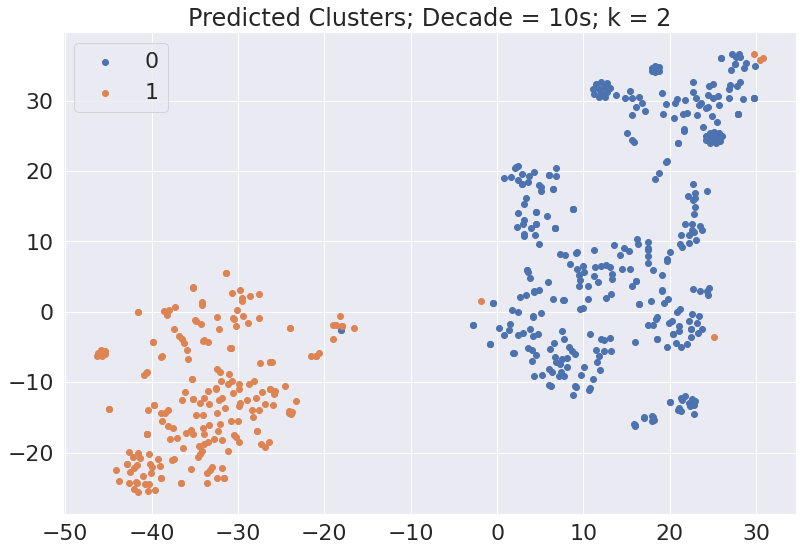

In [ ]:
numCluster = 2
numCategories = numCluster

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, random_state = 1000, init='k-means++')
exampleKM.fit(embs_B)

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
tsneB_df = pd.DataFrame(tsneB_)
tsneB_df['label'] = exampleKM.labels_
fig, ax = plt.subplots()

for i in range(numCluster):
  scatter = ax.scatter(tsneB_df[tsneB_df.label == i].iloc[:, 0], tsneB_df[tsneB_df.label == i].iloc[:, 1],\
                      alpha = 1, label = i)
plt.legend()

plt.title('Predicted Clusters; Decade = 10s; k = {}'.format(numCategories))
plt.savefig("b_word_cluster_10s_.png")
plt.show()

In [ ]:
ten_fetched = ten_sample.loc[~ten_sample.index.isin(na_lst)].reset_index()
ten_fetched['tsne_1'] = tsneB_[:,1]
ten_fetched['tsne_0'] = tsneB_[:,0]
ten_fetched['label'] = exampleKM.labels_

min_dist = np.min(cdist(embs_B, exampleKM.cluster_centers_, 'euclidean'), axis=1)
ten_fetched['dist_center'] = min_dist

print("homogenity:", metrics.homogeneity_score(ten_fetched['gender_matched'], ten_fetched['label']))
print("completeness:", metrics.completeness_score(ten_fetched['gender_matched'], ten_fetched['label']))

grouped = ten_fetched[['dist_center', 'label', 'gender_matched', 'title']].groupby(['label', 'gender_matched'])

ten_fetched.iloc[grouped.idxmin()['dist_center'].values.tolist()]

homogenity: 0.023911824833996773
completeness: 0.03969302191167742


/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


index                           title      artist  \
139    151                          Trophy  Charli Xcx   
220    243                World S Greatest         Dmx   
529    596                         So Long  Angel Haze   
186    204                          Jackie       Ciara   
270    299                Change Locations       Drake   
455    508  On The Edge Azealia Banks Diss  Angel Haze   

                                                lyrics  year  popularity  \
139   I wanna win I want that trophy Woo woo Throw ...  2016         NaN   
220   It's the world's greatest Ruff Ryders Make yo...  2011         NaN   
529  All I wanted was to love you you had to make i...  2013         NaN   
186  Jackie was a girl more than just a girl She al...  2015         NaN   
270  Yeah know how nights like this go Ovofbg 60 Na...  2015         NaN   
455  All up in my black All up in my black All up i...  2013         NaN   

       edm  latin    pop    r&b  ...  year_bin  artist_lower gender_matched  \
139  False  False   True  False  ...     2010s    charli xcx         female   
220  False  False  False  False  ...     2010s           dmx           male   
529  False  False  False  False  ...     2010s    angel haze     non-binary   
186  False  False   True  False  ...     2010s         ciara         female   
270  False  False  False  False  ...     2010s         drake           male   
455  False  False  False  False  ...     2010s    angel haze     non-binary   

                                             segmented song_index  \
139                           I want that trophy Bitch      33440   
220           You know me playing kiss with your bitch      16828   
529                                 FUCKING BABY BITCH       9972   
186                             A lot of these bitches      13962   
270                           them bitches gonna holla      28846   
455  I want you bitches so scared that your mental ...       9974   

                                        tokenized_text     tsne_1     tsne_0  \
139  ['[CLS]', 'i', 'want', 'that', 'trophy', 'bitc...  13.950065  22.833605   
220  ['[CLS]', 'you', 'know', 'me', 'playing', 'kis...   2.922646  24.280100   
529     ['[CLS]', 'fucking', 'baby', 'bitch', '[SEP]']  29.694996  16.752041   
186  ['[CLS]', 'a', 'lot', 'of', 'these', 'bitch', ... -20.828051 -41.298531   
270  ['[CLS]', 'them', 'bitch', '##es', 'gonna', 'h... -16.092115 -33.343140   
455  ['[CLS]', 'i', 'want', 'you', 'bitch', '##es',... -17.295784 -33.883228   

    label  dist_center  
139     0     8.297450  
220     0     8.197096  
529     0     8.113161  
186     1     6.743555  
270     1     6.784286  
455     1     6.849513  

[6 rows x 23 columns]

In [ ]:
binary = ten_fetched.loc[ten_fetched.gender_matched != 'non-binary']

In [ ]:
print("homogenity:", metrics.homogeneity_score(binary['gender_matched'], binary['label']))
print("completeness:", metrics.completeness_score(binary['gender_matched'], binary['label']))

homogenity: 0.009540406272313166
completeness: 0.010757111835022249


### 70s


In [ ]:
seven = bitch_df.loc[bitch_df.year_bin == "1970s"].reset_index()
seven.gender_matched.value_counts()

male    40
Name: gender_matched, dtype: int64

In [ ]:
seven

index                                   title                   artist  \
0       0  Let Me Entertain You - Remastered 2011                    Queen   
1     548                               Rich Girl  Daryl Hall & John Oates   
2     549                               Rich Girl  Daryl Hall & John Oates   
3     550                               Rich Girl  Daryl Hall & John Oates   
4     551                               Rich Girl  Daryl Hall & John Oates   
5    1529                                Big Shot               Billy Joel   
6    2940                       The Bitch Is Back               Elton John   
7    2941                       The Bitch Is Back               Elton John   
8    2942                       The Bitch Is Back               Elton John   
9    2943                       The Bitch Is Back               Elton John   
10   2944                       The Bitch Is Back               Elton John   
11   2945                       The Bitch Is Back               Elton John   
12   2946                       The Bitch Is Back               Elton John   
13   2947                       The Bitch Is Back               Elton John   
14   2948                       The Bitch Is Back               Elton John   
15   2949                       The Bitch Is Back               Elton John   
16   2950                       The Bitch Is Back               Elton John   
17   2951                       The Bitch Is Back               Elton John   
18   2952                       The Bitch Is Back               Elton John   
19   2953                       The Bitch Is Back               Elton John   
20   2954                       The Bitch Is Back               Elton John   
21   2955                       The Bitch Is Back               Elton John   
22   2956                       The Bitch Is Back               Elton John   
23   2957                       The Bitch Is Back               Elton John   
24   2958                       The Bitch Is Back               Elton John   
25   3235                           Tumbling Dice       The Rolling Stones   
26   5155        Moonage Daydream - 2012 Remaster              David Bowie   
27   6389                               Bad Blood              Neil Sedaka   
28   6390                               Bad Blood              Neil Sedaka   
29   9728                            Diamond Dogs              David Bowie   
30   9730                    Oh You Pretty Things              David Bowie   
31   9731                        Moonage Daydream              David Bowie   
32   9732          Moonage Daydream 2012 Remaster              David Bowie   
33   9733                          Ziggy Stardust              David Bowie   
34   9734            Ziggy Stardust 2012 Remaster              David Bowie   
35  13264                               Rich Girl    Daryl Hall John Oates   
36  13265                               Rich Girl    Daryl Hall John Oates   
37  13266                               Rich Girl    Daryl Hall John Oates   
38  16614                       Dirty Little Girl               Elton John   
39  16615                       Dirty Little Girl               Elton John   

                                               lyrics  year  popularity  \
0   Hey, it's a sellout! Hey! Let me welcome you, ...  1978        41.0   
1   You're a rich girl, and you've gone too far Ca...  1976        70.0   
2   You're a rich girl, and you've gone too far Ca...  1976        70.0   
3   You're a rich girl, and you've gone too far Ca...  1976        70.0   
4   You're a rich girl, and you've gone too far Ca...  1976        70.0   
5   Well, you went uptown ridin' in your limousine...  1978        56.0   
6   I was justified when I was five Raising Cain, ...  1974        59.0   
7   I was justified when I was five Raising Cain, ...  1974        59.0   
8   I was justified when I was five Raising Cain, ...  1974        59.0   
9   I was justified when I was five Raising Cain, ...  

In [ ]:
sents = seven.segmented.values.tolist()

In [ ]:
len(seven)

40

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, bitch_lst, layers = [-2], model = "/content/lyrics-bert2") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

#### Visualize Embeddings

In [ ]:
len(emb_lst_b)

39

In [ ]:
len(na_lst)
na_lst

[8]

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(39, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 2).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2, random_state = 7).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


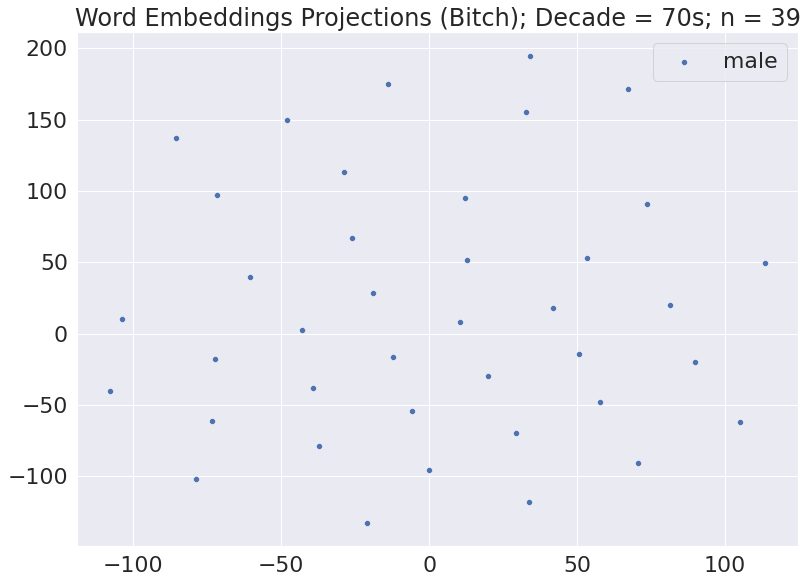

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1,\
                palette="bright")
plt.tight_layout()
plt.legend(['male'])
plt.title(f"Word Embeddings Projections (Bitch); Decade = 70s; n = {len(emb_lst_b)}")
plt.savefig("b_word_70s.png")

#### Clustering Analysis

In [ ]:
tsneB_.shape #reduced the embeddings from 768 to 2-d

(39, 2)

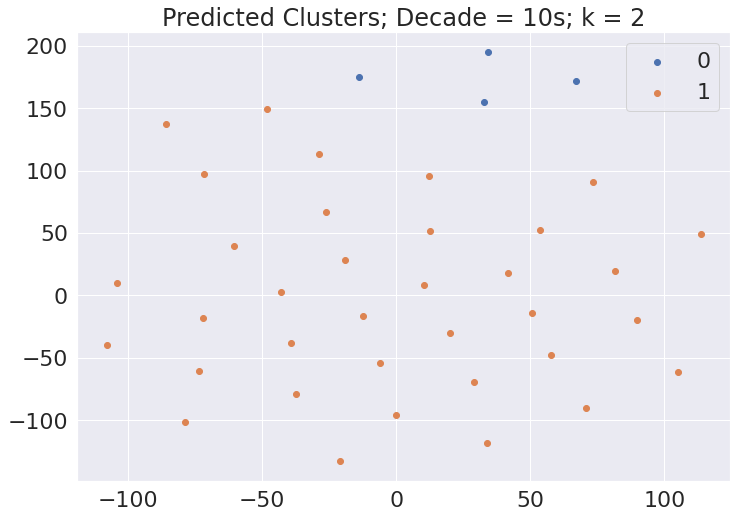

In [ ]:
numCluster = 2
numCategories = numCluster

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, random_state = 1000, init='k-means++')
exampleKM.fit(embs_B)

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
tsneB_df = pd.DataFrame(tsneB_)
tsneB_df['label'] = exampleKM.labels_
fig, ax = plt.subplots()

for i in range(numCluster):
  scatter = ax.scatter(tsneB_df[tsneB_df.label == i].iloc[:, 0], tsneB_df[tsneB_df.label == i].iloc[:, 1],\
                      alpha = 1, label = i)
plt.legend()

plt.title('Predicted Clusters; Decade = 70s; k = {}'.format(numCategories))
plt.savefig("b_word_cluster_10s.png")
plt.show()


In [ ]:
seven_fetched = seven.loc[~seven.index.isin(na_lst)].reset_index()

In [ ]:
seven_fetched.shape

(39, 20)

In [ ]:
seven_fetched['tsne_1'] = tsneB_[:,1]
seven_fetched['tsne_0'] = tsneB_[:,0]
seven_fetched['label'] = exampleKM.labels_

In [ ]:
from scipy.spatial.distance import cdist
min_dist = np.min(cdist(embs_B, exampleKM.cluster_centers_, 'euclidean'), axis=1)
seven_fetched['dist_center'] = min_dist

In [ ]:
metrics.homogeneity_score(seven_fetched['gender_matched'], seven_fetched['label'])

1.0

In [ ]:
sklearn.metrics.completeness_score(seven_fetched['gender_matched'], seven_fetched['label'])

0.0

In [ ]:
grouped = seven_fetched[['dist_center', 'label', 'gender_matched', 'title']].groupby(['label', 'gender_matched'])
grouped.idxmin()

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


dist_center
label gender_matched             
0     male                     30
1     male                     11

In [ ]:
seven_fetched.iloc[grouped.idxmin()['dist_center'].values.tolist()]

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


level_0  index              title       artist  \
30       31   9731   Moonage Daydream  David Bowie   
11       12   2946  The Bitch Is Back   Elton John   

                                               lyrics  year  popularity  \
30  I'm an alligator I'm a mama papa coming for yo...  1972         NaN   
11  I was justified when I was five Raising Cain, ...  1974        59.0   

      edm  latin    pop  ...  year_bin  artist_lower  gender_matched  \
30  False  False  False  ...     1970s   david bowie            male   
11  False  False  False  ...     1970s    elton john            male   

                                segmented song_index  \
30  I'll be a rock n rollin bitch for you      15666   
11         (oh) I'm a bitch, I'm a bitch,       3301   

                                       tokenized_text      tsne_1     tsne_0  \
30  ['[CLS]', 'i', "'", 'll', 'be', 'a', 'rock', '...  194.799332  34.094570   
11  ['[CLS]', '(', 'oh', ')', 'i', "'", 'm', 'a', ...  -14.124191  50.574635   

    label dist_center  
30      0    5.806831  
11      1    7.516424  

[2 rows x 24 columns]

In [ ]:
seven_fetched.iloc[11]

level_0                                                          11
index                                                          2945
title                                             The Bitch Is Back
artist                                                   Elton John
lyrics            I was justified when I was five Raising Cain, ...
year                                                           1974
popularity                                                     59.0
edm                                                           False
latin                                                         False
pop                                                           False
r&b                                                           False
rap                                                           False
rock                                                           True
Gender                                                      Unknown
year_bin                                        

### 80s


In [ ]:
eight = bitch_df.loc[bitch_df.year_bin == "1980s"].reset_index()
eight.gender_matched.value_counts()

male    13
Name: gender_matched, dtype: int64

In [ ]:
eight.title.unique()

array(['Rock You Like A Hurricane', 'Used To Love Her',
       'Rock You Like a Hurricane - 2015 - Remaster', "It's So Easy",
       'Life Is Real (Song For Lennon) - Remastered 2011',
       'Gotta Lotta Nerve Perfect Perfect',
       'Looking Down The Barrel Of A Gun', 'White Lady White Powder'],
      dtype=object)

In [ ]:
sents = eight.segmented.values.tolist()

In [ ]:
len(eight)

13

In [ ]:
emb_lst_b = []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, bitch_lst, layers = [-2], model = "/content/lyrics-bert2") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst_b.append(emb)

#### Visualize Embeddings

In [ ]:
len(emb_lst_b)

13

In [ ]:
len(na_lst)
na_lst

[]

In [ ]:
embs_B = torch.stack(emb_lst_b).numpy()
embs_B.shape

(13, 768)

In [ ]:
embs_B=embs_B.astype(np.float64)

In [ ]:
pcaB_= decomposition.PCA(n_components = 2).fit(embs_B)
reducedB_ = pcaB_.transform(embs_B)
tsneB_ = manifold.TSNE(n_components = 2, random_state = 7).fit_transform(reducedB_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


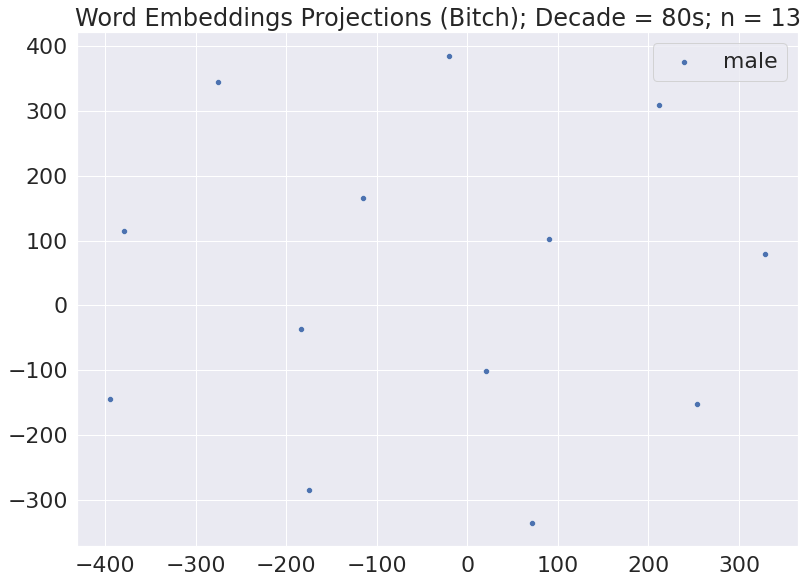

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsneB_[:, 0], tsneB_[:, 1], alpha =1,\
                palette="bright")
plt.tight_layout()
plt.legend(['male'])
plt.title(f"Word Embeddings Projections (Bitch); Decade = 80s; n = {len(emb_lst_b)}")
plt.savefig("b_word_80s.png")

#### Clustering Analysis

In [ ]:
tsneB_.shape #reduced the embeddings from 768 to 2-d

(13, 2)

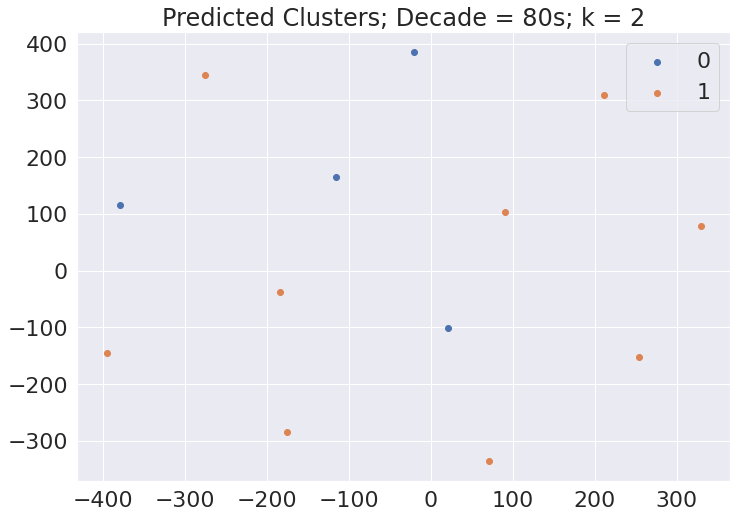

In [ ]:
numCluster = 2
numCategories = numCluster

exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, random_state = 1000, init='k-means++')
exampleKM.fit(embs_B)

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]
tsneB_df = pd.DataFrame(tsneB_)
tsneB_df['label'] = exampleKM.labels_
fig, ax = plt.subplots()

for i in range(numCluster):
  scatter = ax.scatter(tsneB_df[tsneB_df.label == i].iloc[:, 0], tsneB_df[tsneB_df.label == i].iloc[:, 1],\
                      alpha = 1, label = i)
plt.legend()

plt.title('Predicted Clusters; Decade = 80s; k = {}'.format(numCategories))
plt.savefig("b_word_cluster_80s.png")
plt.show()


In [ ]:
eight_fetched = seven.loc[~seven.index.isin(na_lst)].reset_index()

In [ ]:
seven_fetched.shape

(39, 20)

In [ ]:
eight['tsne_1'] = tsneB_[:,1]
eight['tsne_0'] = tsneB_[:,0]
eight['label'] = exampleKM.labels_

In [ ]:
from scipy.spatial.distance import cdist
min_dist = np.min(cdist(embs_B, exampleKM.cluster_centers_, 'euclidean'), axis=1)
eight['dist_center'] = min_dist

In [ ]:
metrics.homogeneity_score(eight['gender_matched'], eight['label'])

1.0

In [ ]:
sklearn.metrics.completeness_score(eight['gender_matched'], eight['label'])

0.0

In [ ]:
grouped = eight[['dist_center', 'label', 'gender_matched', 'title']].groupby(['label', 'gender_matched'])
grouped.idxmin()

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


dist_center
label gender_matched             
0     male                     10
1     male                      0

In [ ]:
eight.iloc[grouped.idxmin()['dist_center'].values.tolist()]

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/groupby.py:1309: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  keys, values, mutated = self.grouper.apply(f, data, self.axis)


index                              title                 artist  \
10  13263  Gotta Lotta Nerve Perfect Perfect  Daryl Hall John Oates   
0     689          Rock You Like A Hurricane              Scorpions   

                                               lyrics  year  popularity  \
10  I've gotta lotta nerve a Gotta lotta do do do ...  1980         NaN   
0   It's early morning, the sun comes out Last nig...  1984        14.0   

      edm  latin    pop    r&b  ...  year_bin           artist_lower  \
10  False  False  False  False  ...     1980s  daryl hall john oates   
0   False  False   True  False  ...     1980s              scorpions   

   gender_matched                                          segmented  \
10           male                   Oh no stop bitching indiscretion   
0            male  The bitch is hungry, she needs to tell So give...   

   song_index                                     tokenized_text      tsne_1  \
10      22761  ['[CLS]', 'oh', 'no', 'stop', 'bitch', '##ing'...  384.973175   
0         737  ['[CLS]', 'the', 'bitch', 'is', 'hungry', ',',...  -36.658543   

        tsne_0 label  dist_center  
10  -19.847826     0     9.405561  
0  -183.444931     1     2.852219  

[2 rows x 23 columns]

##F word

### Ramdom Sample lines of lyrics from male (0), female(1) and non-binary artists(2).

In [ ]:
fuck_df = pd.read_csv("fuck_df.csv")

In [ ]:
fuck_df.gender_matched.value_counts()

0    23061
1      874
2      193
Name: gender_matched, dtype: int64

In [ ]:
fuck_sample = fuck_df.groupby("gender_matched").sample(193, random_state=42).reset_index(drop=True)

In [ ]:
fuck_sample

title                     artist  \
0                          Lemme Freak                  Lil Dicky   
1                            Freestyle                        Dmx   
2        Instagram - Bassjackers Remix  Dimitri Vegas & Like Mike   
3                        Tiimmy Turner                  Desiigner   
4                              Burn Mf    Five Finger Death Punch   
..                                 ...                        ...   
574                        After Party               Adore Delano   
575  The Way (feat. Chance the Rapper)                    Kehlani   
576                            Echelon                 Angel Haze   
577  The Way (feat. Chance the Rapper)                    Kehlani   
578                        After Party               Adore Delano   

                                                lyrics  year  popularity  \
0    Drunk, faded Browned out, looking all shady Tw...  2015        63.0   
1    Uh uh uh Niggaz gettin trampled on what's all ...  2006         NaN   
2    NA Just bought a black Ferrari House in the hi...  2019        21.0   
3    Yeah, yeah, yeah, yeah Grrrrraaaah Yeah, yeah,...  2016        72.0   
4    My heart is frozen My soul's been broken The w...  2013         NaN   
..                                                 ...   ...         ...   
574  It's 2 AM your fingertips are running down my ...  2016         NaN   
575  You so damn important Everything you do shows ...  2015        66.0   
576  I'm in that new school G5 wagon Color Komodo d...  2013         NaN   
577  You so damn important Everything you do shows ...  2015        66.0   
578  It's 2 AM your fingertips are running down my ...  2016         NaN   

       edm  latin    pop    r&b    rap   rock   Gender year_bin  \
0    False  False  False  False   True  False  Unknown    2010s   
1    False  False  False  False   True  False  Unknown    2000s   
2     True  False  False  False  False  False  Unknown    2010s   
3    False  False  False  False   True  False  Unknown    2010s   
4    False  False  False  False  False  False  Unknown    2010s   
..     ...    ...    ...    ...    ...    ...      ...      ...   
574  False  False   True  False  False  False  Unknown    2010s   
575  False  False  False   True  False  False  Unknown    2010s   
576  False  False  False  False   True  False  Unknown    2010s   
577  False  False  False   True  False  False  Unknown    2010s   
578  False  False   True  False  False  False  Unknown    2010s   

                artist_lower  gender_matched  \
0                  lil dicky               0   
1                        dmx               0   
2    dimitri vegas like mike               0   
3                  desiigner               0   
4    five finger death punch               0   
..                       ...             ...   
574             adore delano               2   
575                  kehlani               2   
576               angel haze               2   
577                  kehlani               2   
578             adore delano               2   

                                             segmented  song_index  \
0    then I don't work with these people," she star...         235   
1         And then I snuff em out four to the mid fuck       16686   
2    I don't give a fuck about your Instagram Fly a...        1453   
3             , she fuckin' for BET Wildin' for wallet        2984   
4                                   mother fucker burn       27056   
..                                                 ...         ...   
574                           and I'll fuck who I want        9695   
575          when we fuck, RE/MAXIt get hot than a mug        5335   
576                                   I'm on that fuck        9967   
577  It's the way you love, the way you fuck, the w...        5335   
578  and I'll fuck who I want Fuck who I want fuck ...        9695   

                                        tokenized_text  
0    [[CLS]

In [ ]:
sents = fuck_sample.segmented.values.tolist()

In [ ]:
len(sents)

579

In [ ]:
emb_lst= []
na_lst = []
for i, sent in enumerate(sents):
    emb = bert_utils.main(sent, fuck_lst, layers = [-2], model = "/content/lyrics-bert") #use the second to last layer as word embedding
    if torch.isnan(emb).any().numpy():
        na_lst.append(i)
    else:
        emb_lst.append(emb)


### Visualize Embeddings

In [ ]:
embs_f = torch.stack(emb_lst).numpy()
embs_f.shape

(549, 768)

In [ ]:
len(na_lst)

30

In [ ]:
embs_f=embs_f.astype(np.float64)

In [ ]:
pca = decomposition.PCA(n_components = 44).fit(embs_f)
reduced= pca.transform(embs_f)
tsne= manifold.TSNE(n_components = 2).fit_transform(reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


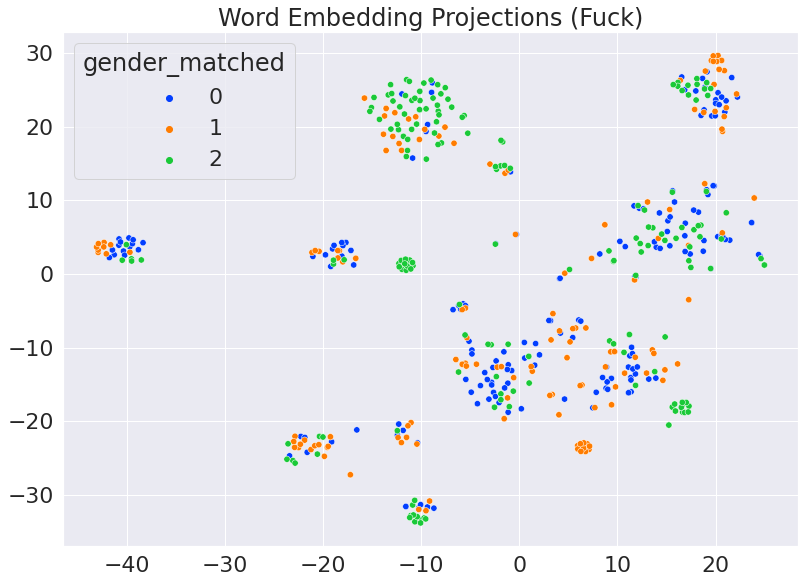

In [ ]:
sns.set(font_scale=2)
sns.scatterplot(tsne[:, 0], tsne[:, 1], alpha =1, hue = fuck_sample.loc[~fuck_sample.index.isin(na_lst)].gender_matched, \
                palette="bright", s=40)
plt.tight_layout()
plt.title("Word Embedding Projections (Fuck)")
plt.savefig("plot/f_word.png")